# Forecasting Crude Oil Price

In [1]:
# importing libraries
import pandas as pd
import numpy as np

# to Visualize
import seaborn as sns
import matplotlib.pyplot as plt

from pandas import Grouper
from pandas import DataFrame

from pandas.plotting import lag_plot
import statsmodels.graphics.tsaplots as tsa_plots
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

# For stationarity check
from statsmodels.tsa.stattools import adfuller
#Model Building
import statsmodels.formula.api as smf 
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import math
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential

In [2]:
# loading dataset
df=pd.read_excel('Crude_oil_price.xlsx',parse_dates=True)
df

Date  Price
0    1996-01-01  19.55
1    1996-01-02  19.81
2    1996-01-03  19.89
3    1996-01-04  19.91
4    1996-01-05  20.26
...         ...    ...
7387 2017-12-24  58.47
7388 2017-12-25  58.59
7389 2017-12-26  59.97
7390 2017-12-27  59.64
7391 2017-12-28  59.84

[7392 rows x 2 columns]

Dataset is Univarient Time Series Data i.e Date Vs Target

Before doing anything else with the data let's see if there are any null values (missing data) in any of the columns.

## EDA

In [3]:
df.shape

(7392, 2)

dataset has 7392 rows and 2 columns.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7392 entries, 0 to 7391
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    7392 non-null   datetime64[ns]
 1   Price   7392 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 115.6 KB


In [5]:
df.isnull().sum()

Date     0
Price    0
dtype: int64

No Missing values and datatype also identified accuretly

In [6]:
df.duplicated().sum()

0

In [7]:
df.describe()

Date        Price
count                           7392  7392.000000
mean   2006-12-29 17:27:16.363636480    54.111653
min              1996-01-01 00:00:00    10.720000
25%              2001-06-30 06:00:00    27.567500
50%              2006-12-30 00:00:00    48.820000
75%              2012-06-28 18:00:00    78.912500
max              2017-12-28 00:00:00   145.290000
std                              NaN    29.945796

Summary of numerical attributes:
In essence, it is descriptive statistics (count, mean, standard deviation, minimum value, maximum value, and 25% - 50% - 75% percentile)

## Visualization

### Box and Whisker Plots by Interval

In [8]:
data=pd.read_excel('Crude_oil_price.xlsx',parse_dates=True)

In [9]:
data

Date  Price
0    1996-01-01  19.55
1    1996-01-02  19.81
2    1996-01-03  19.89
3    1996-01-04  19.91
4    1996-01-05  20.26
...         ...    ...
7387 2017-12-24  58.47
7388 2017-12-25  58.59
7389 2017-12-26  59.97
7390 2017-12-27  59.64
7391 2017-12-28  59.84

[7392 rows x 2 columns]

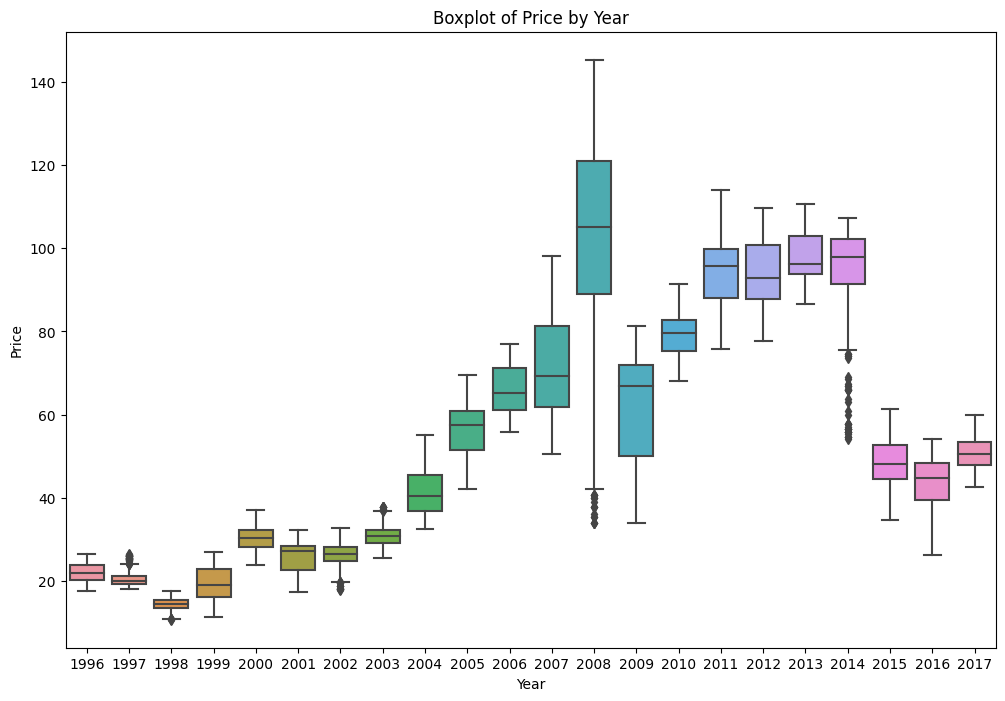

In [10]:
plt.figure(figsize=(12,8))
data['Date'] = pd.to_datetime(data['Date'])

data['Year'] = data['Date'].dt.year

# Generate box plots for each year
sns.boxplot(data=data, x='Year', y='Price')

# Treat outliers using winsorization
q1 = data['Price'].quantile(0.25)
q3 = data['Price'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

data['Price'] = data['Price'].clip(lower=lower_bound, upper=upper_bound)

plt.title('Boxplot of Price by Year')
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

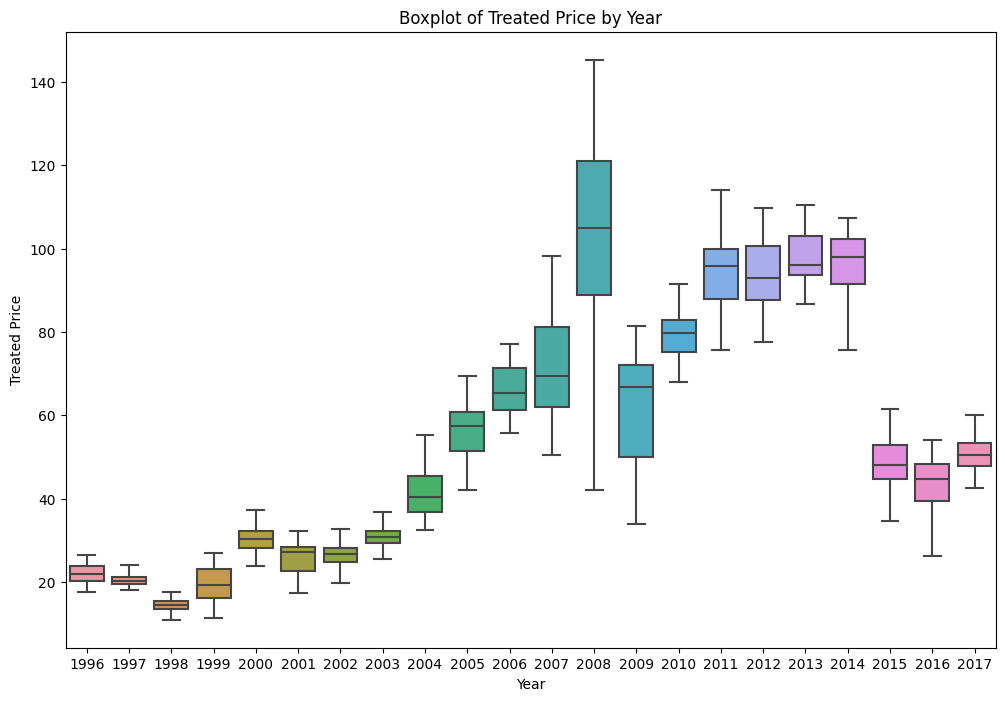

In [11]:
# Treat outliers using IQR method
plt.figure(figsize=(12,8))
q1 = data['Price'].quantile(0.25)
q3 = data['Price'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

data['Treated_Price'] = data['Price'].clip(lower=lower_bound, upper=upper_bound)

# Generate box plot of treated data
sns.boxplot(data=data, x='Year', y='Treated_Price', showfliers=False)

# Set the title and labels for the plot
plt.title('Boxplot of Treated Price by Year')
plt.xlabel('Year')
plt.ylabel('Treated Price')

# Show the plot
plt.show()


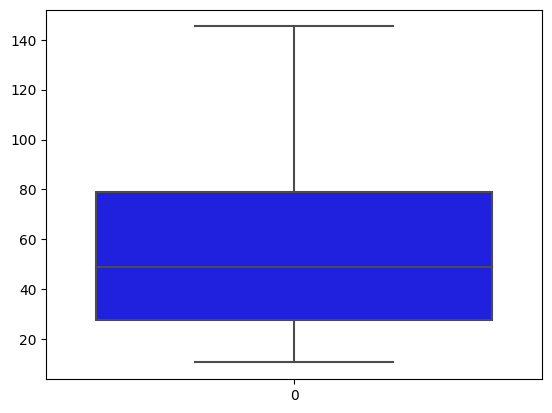

In [12]:
# Boxplot for overall price
sns.boxplot(data=data['Treated_Price'],color='blue')
plt.show()

Price colunm is slightly right skewed with majority of data is in range of 35 to 80 with median value is 54 Rs

In [13]:
data.shape

(7392, 4)

In [14]:
data.head()

Date  Price  Year  Treated_Price
0 1996-01-01  19.55  1996          19.55
1 1996-01-02  19.81  1996          19.81
2 1996-01-03  19.89  1996          19.89
3 1996-01-04  19.91  1996          19.91
4 1996-01-05  20.26  1996          20.26

In [15]:
# Save column as Excel
#data['Treated_Price'].to_excel('D:/Data Science/Projects/Oil_Price_Forecasting/OIL_PRICE_MY_FILE/column_data.xlsx', index=False)

### Upsampling(Average method)
       # only for visualization purpous
        converting Days into months

In [16]:
# to set Date column name as index 
df.set_index('Date',inplace=True)

In [17]:
resample = df.resample('M')
df_visu = resample.mean()
df_visu

Price
Date                 
1996-01-31  18.933214
1996-02-29  18.673929
1996-03-31  21.047500
1996-04-30  23.390714
1996-05-31  21.185000
...               ...
2017-08-31  48.402143
2017-09-30  49.426786
2017-10-31  51.305000
2017-11-30  56.762857
2017-12-31  57.860357

[264 rows x 1 columns]

### Line plot

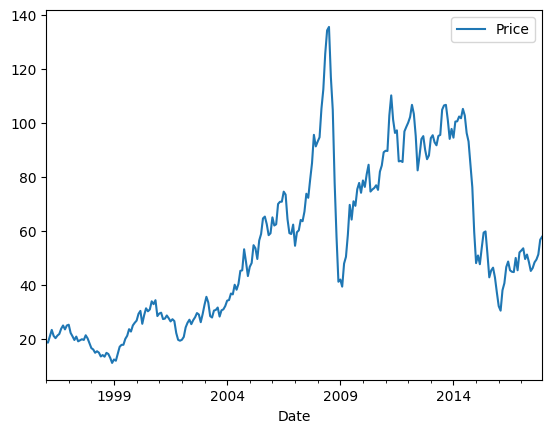

In [18]:
df_visu.plot()
plt.show()

It shows dataset has Polynomial trend with non seasonal

### Histogram and Density Plots of target column

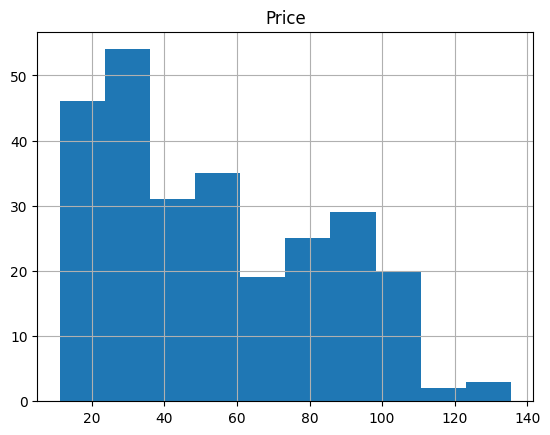

In [19]:
# target should be normally distributed if not ten treat it
df_visu.hist()
plt.show()

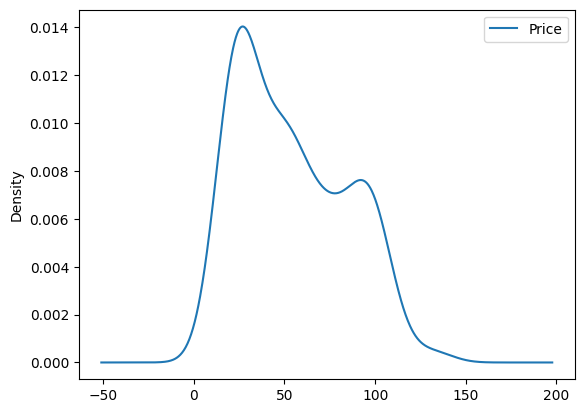

In [20]:
# create a density plot
df_visu.plot(kind='kde')
plt.show()


Price column is slightly Right skewed.

Price have average value between 54 and standard deviation is in range of 20-80.

In [21]:
df_visu.skew()

Price    0.480807
dtype: float64

Generally, skewness values if within -0.5 to 0.5 then said distribution can be considered Normally skewed distribution and within this range, it can be also considered as approximately normally distributed.

### Lag plot

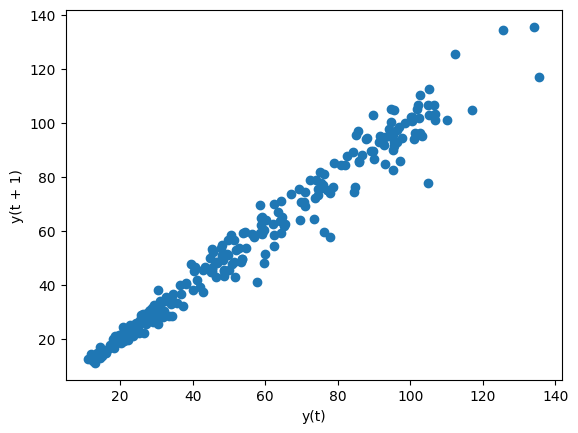

In [22]:
# lagplot-it is scatterplot between target Vs target with 1 delay(lag)
lag_plot(df_visu)
plt.show()

from above lag plot it shows that,feature and target are highly positively correlated with each other,That means Forecasting for Prices are possible

### Moving Average

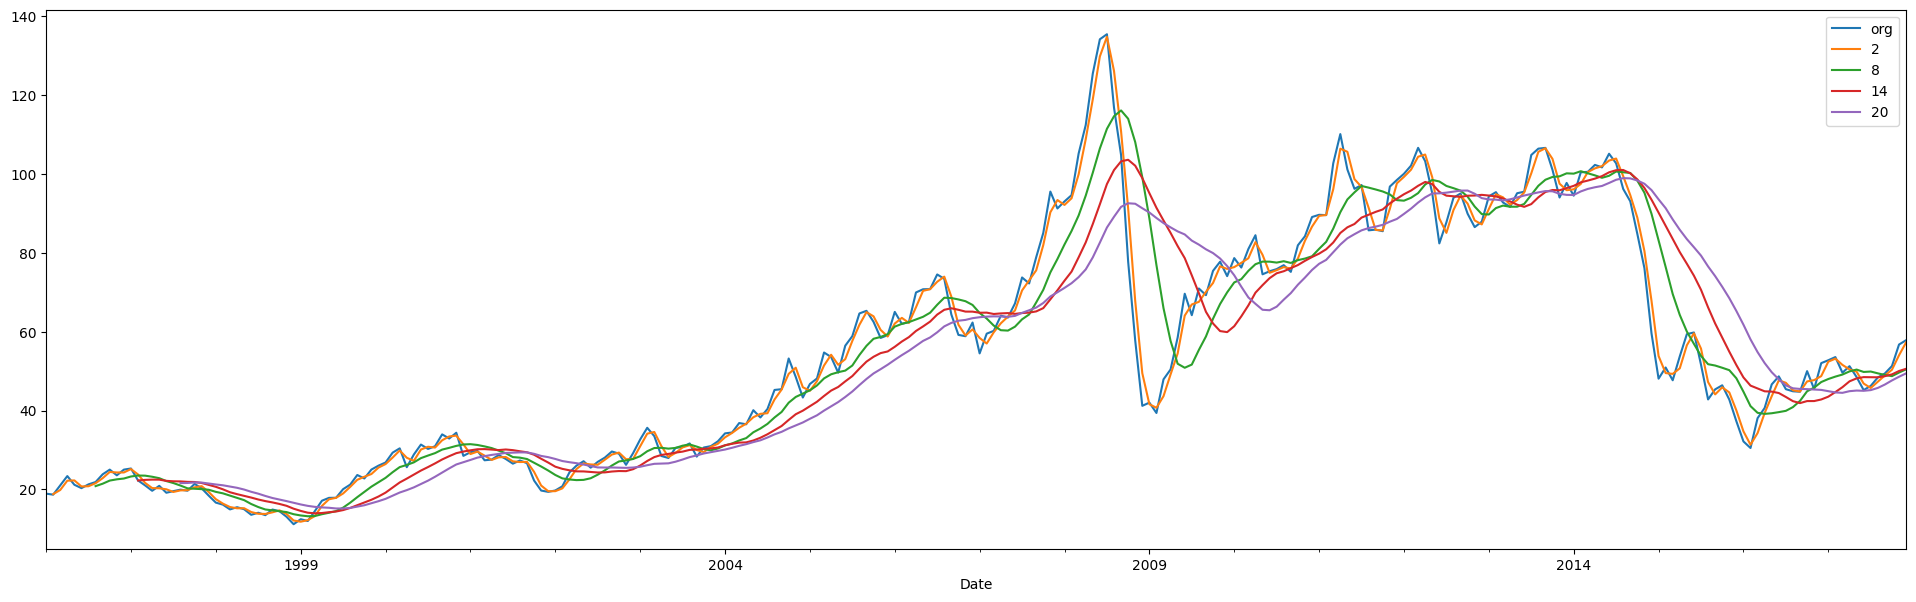

In [23]:
plt.figure(figsize=(24,7))
df_visu['Price'].plot(label="org")
for i in range(2,24,6):
    #plt.figure(figsize=(24,7))
    df_visu['Price'].rolling(i).mean().plot(label=str(i))
    #plt.title("MA"+str(i))
plt.legend(loc='best')
plt.show()

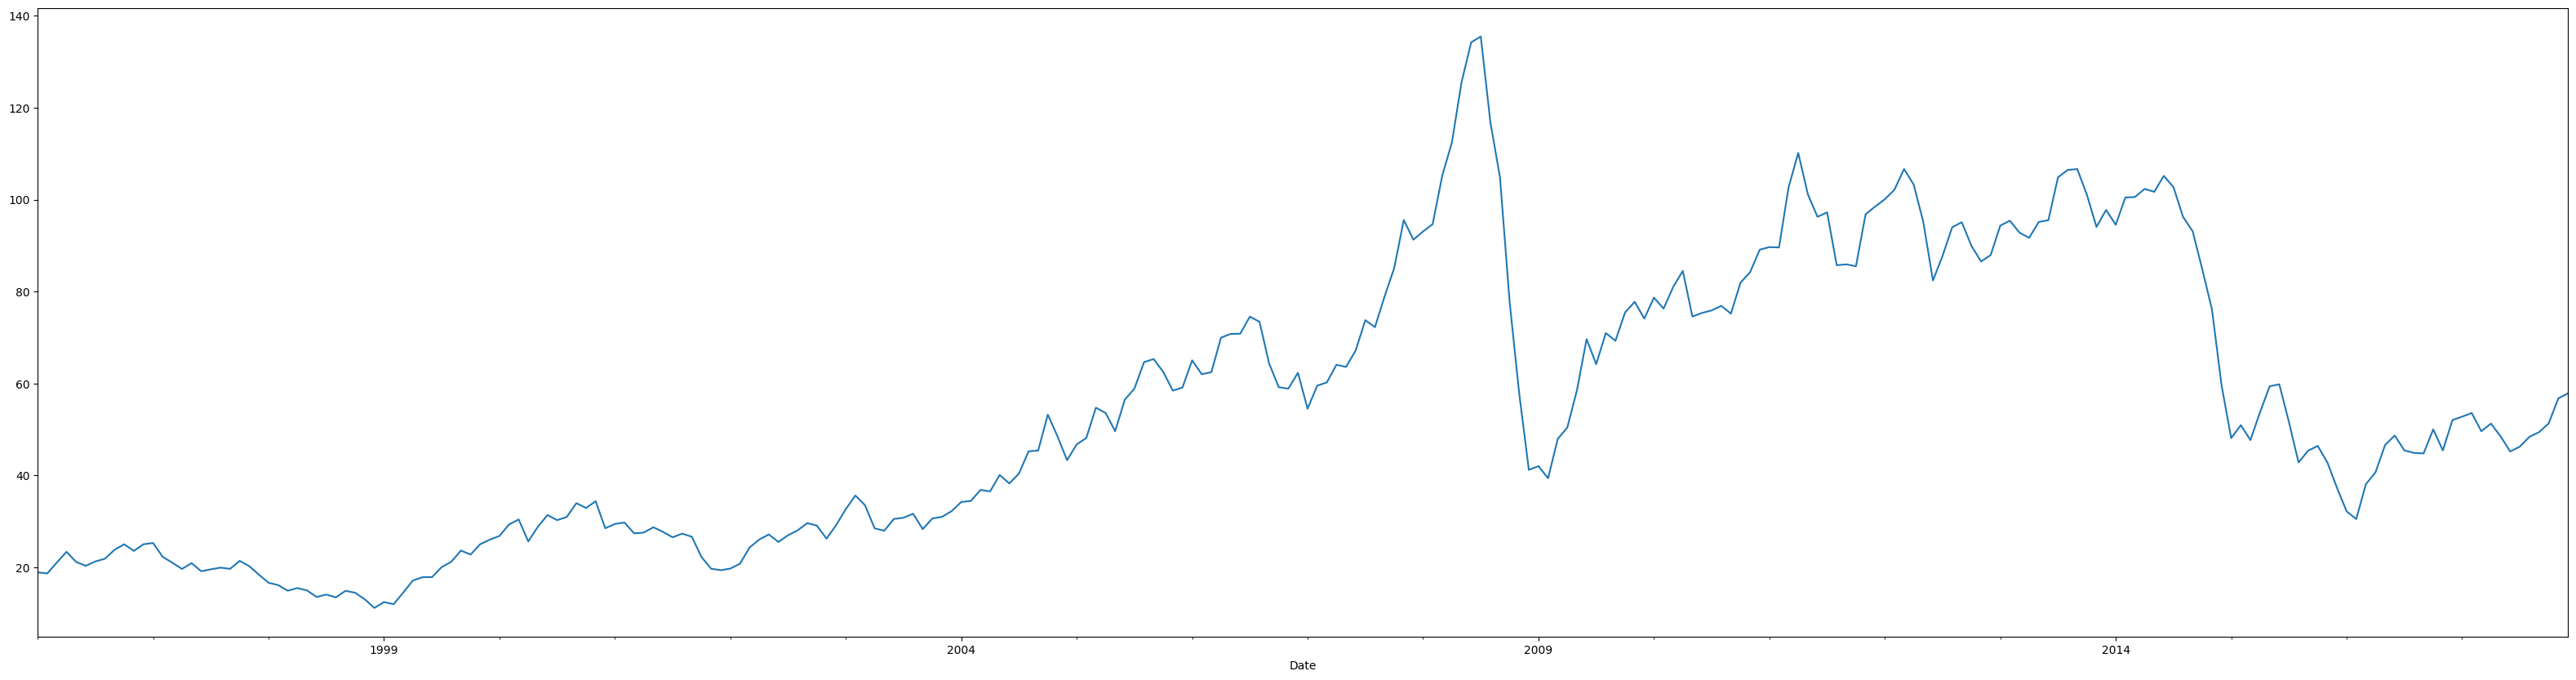

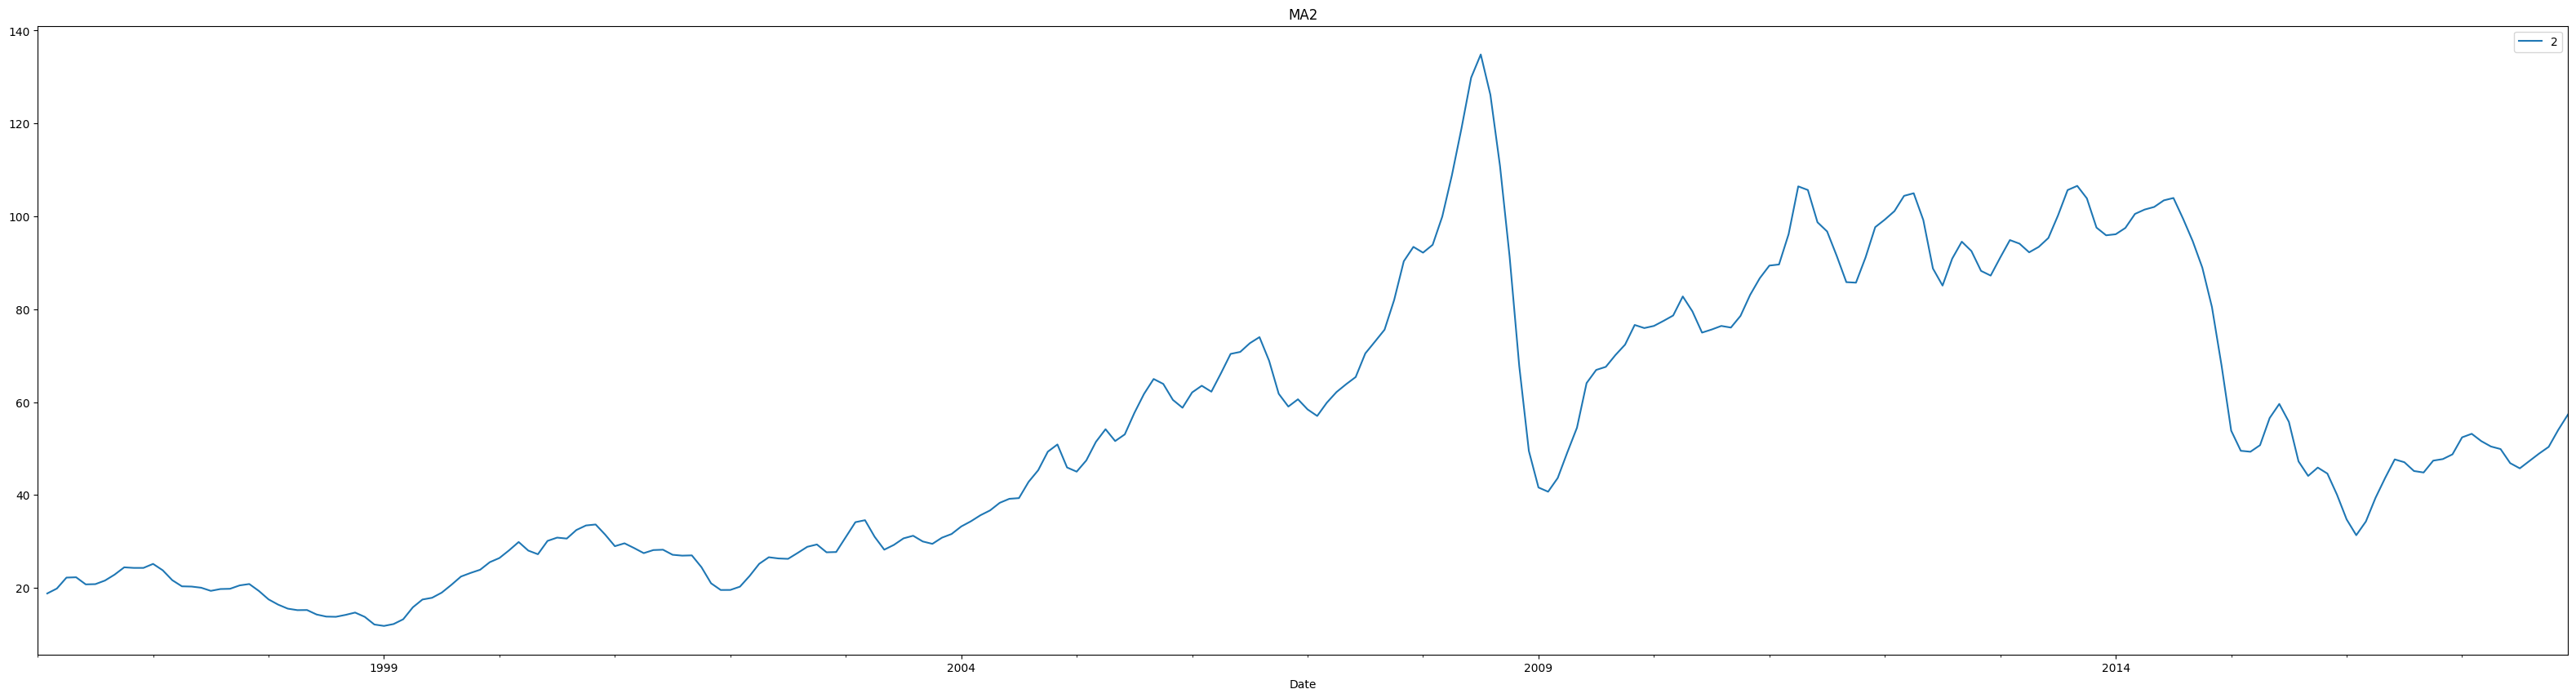

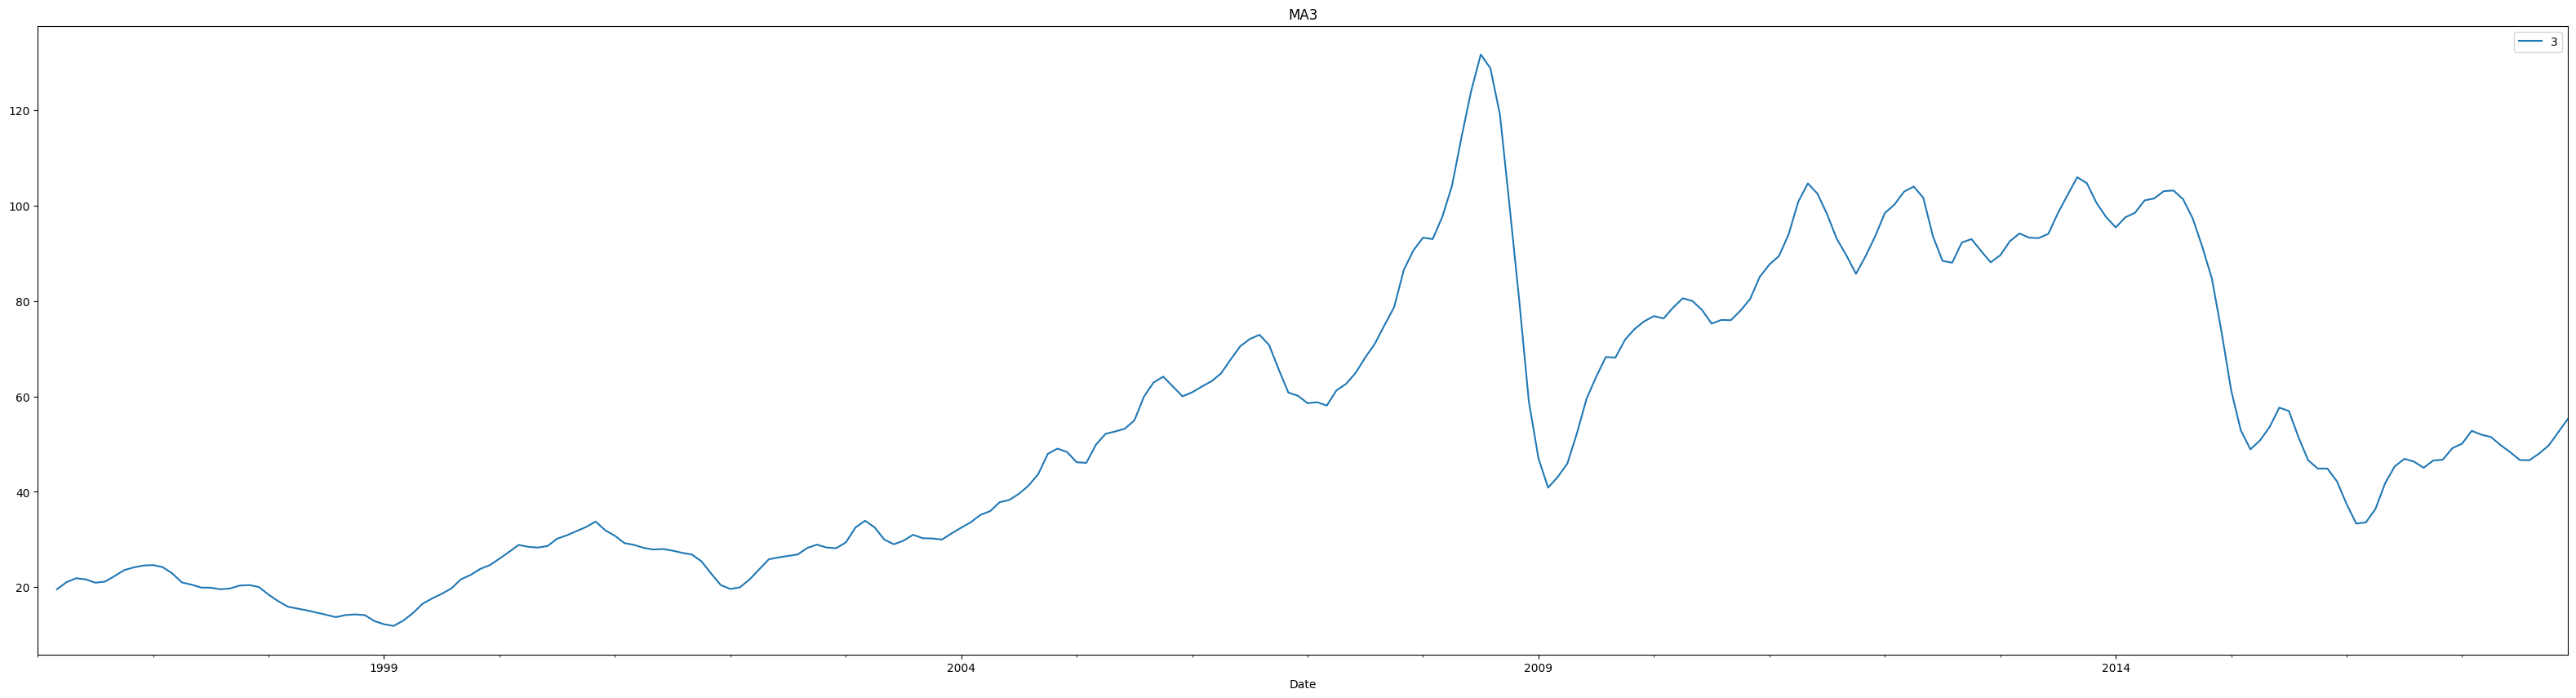

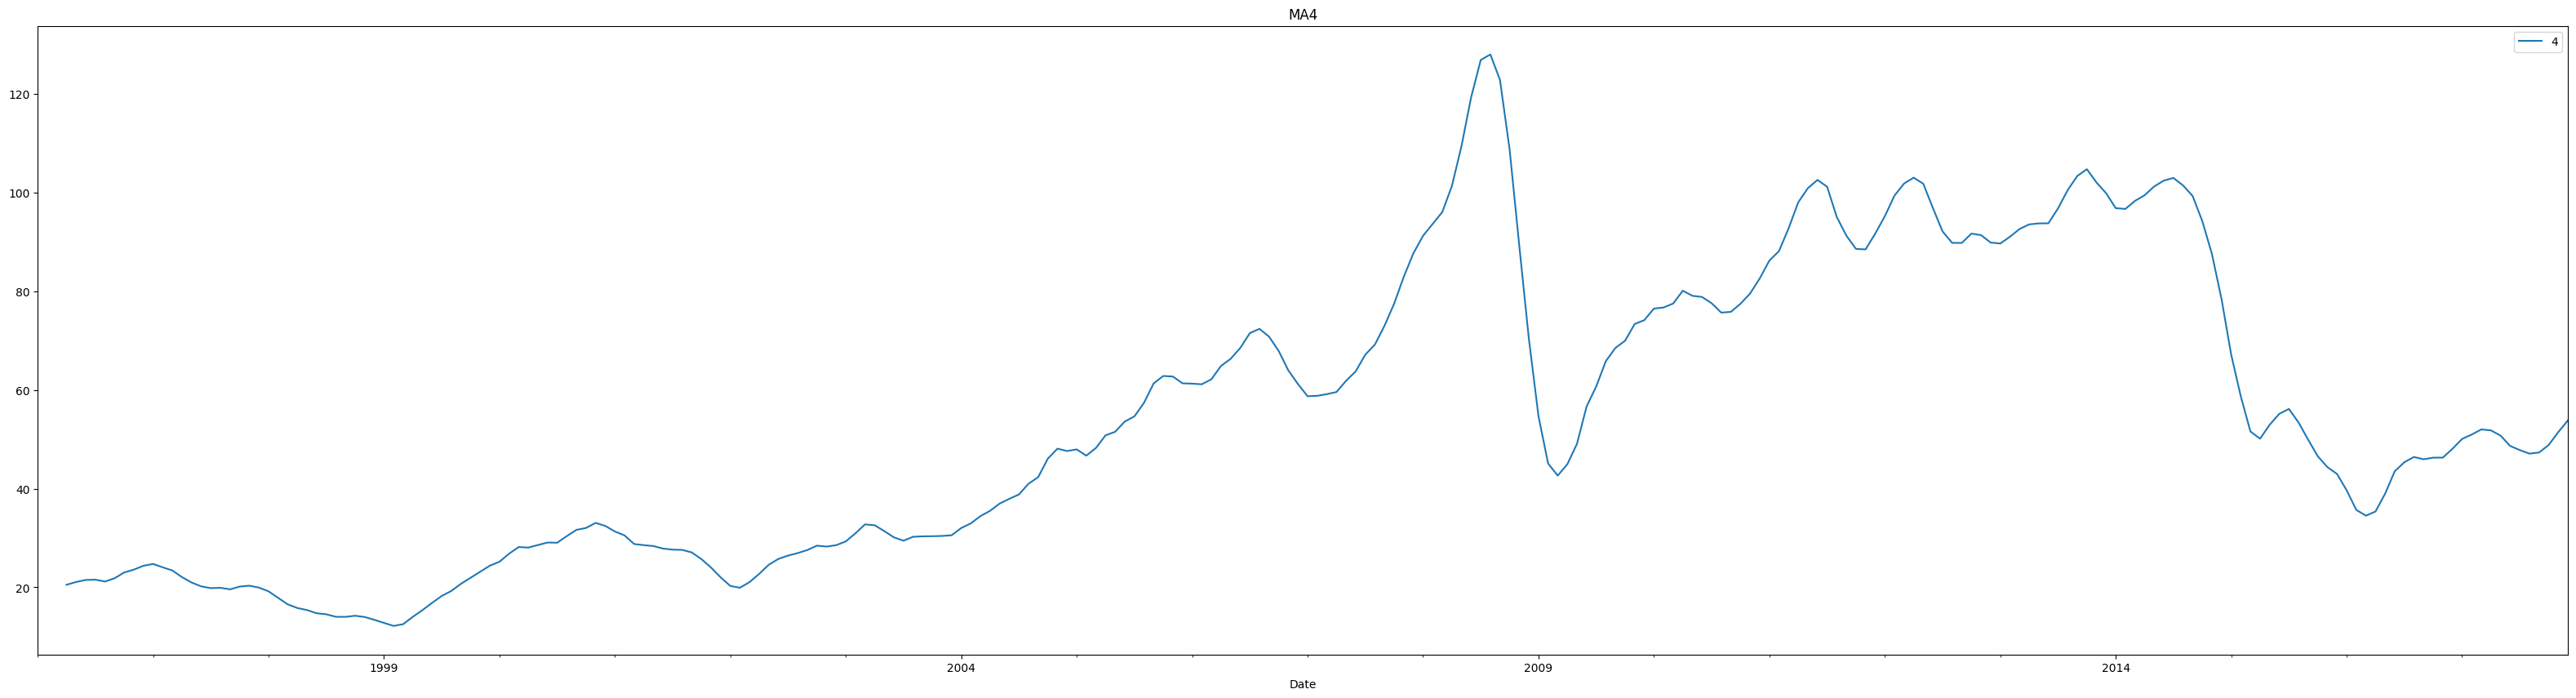

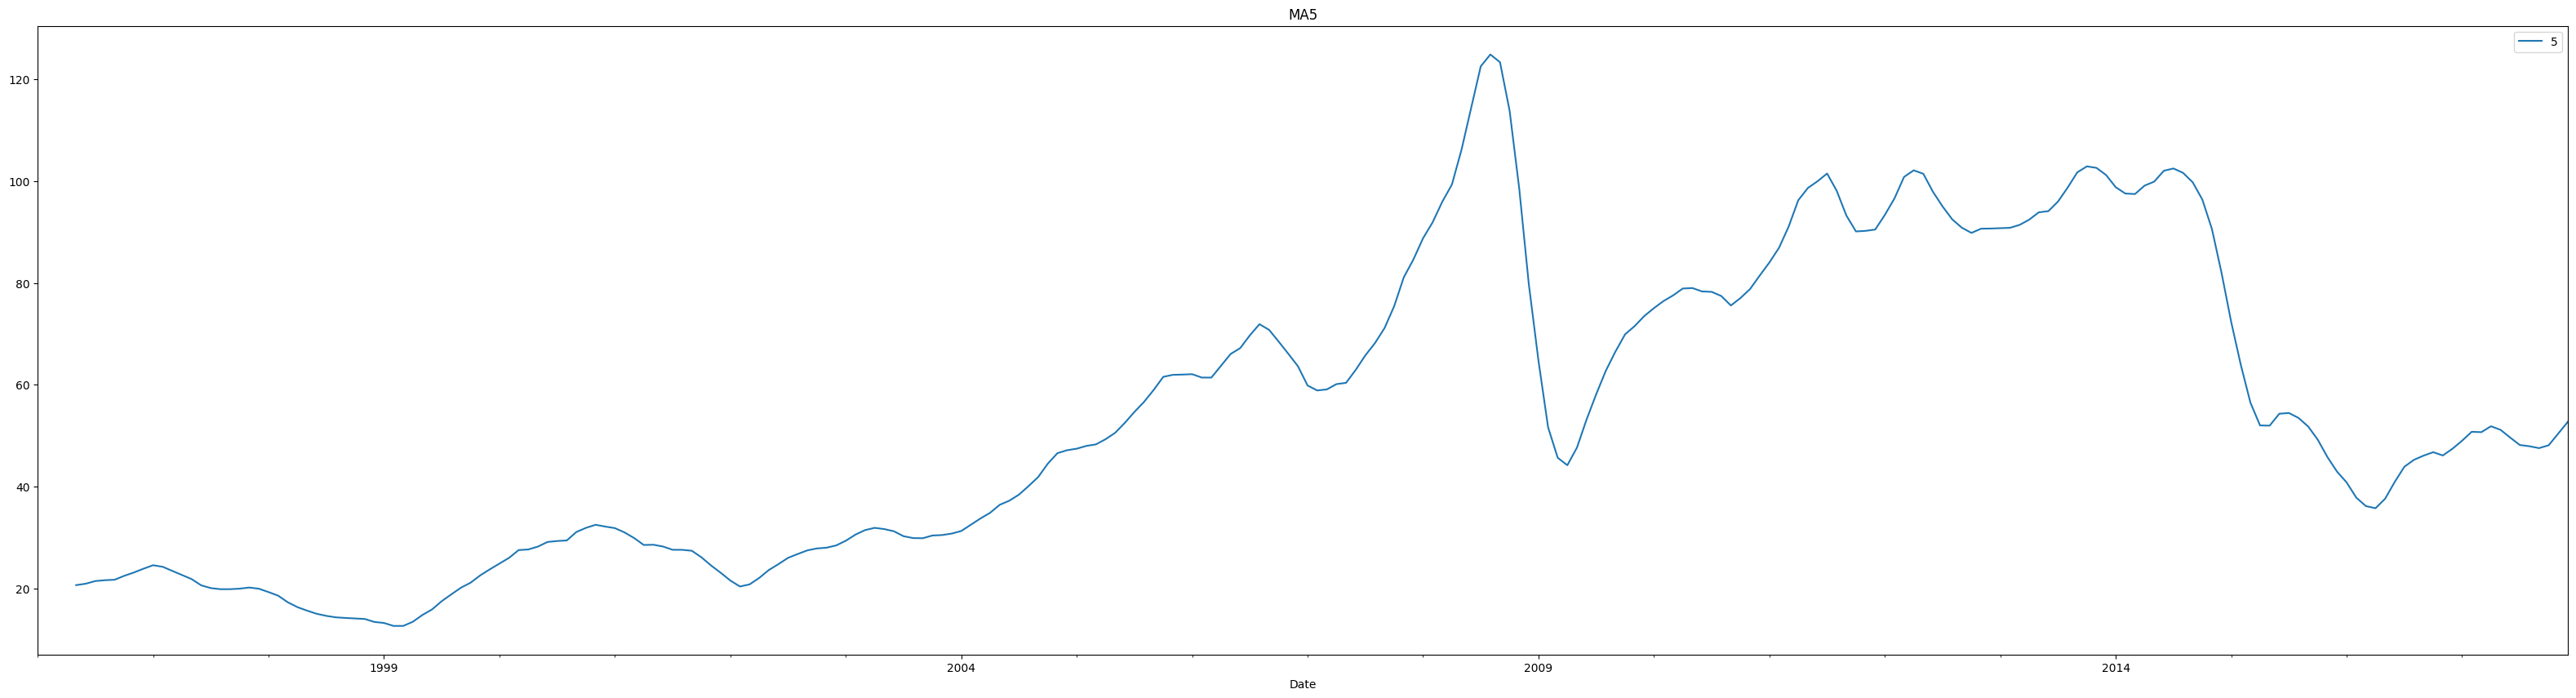

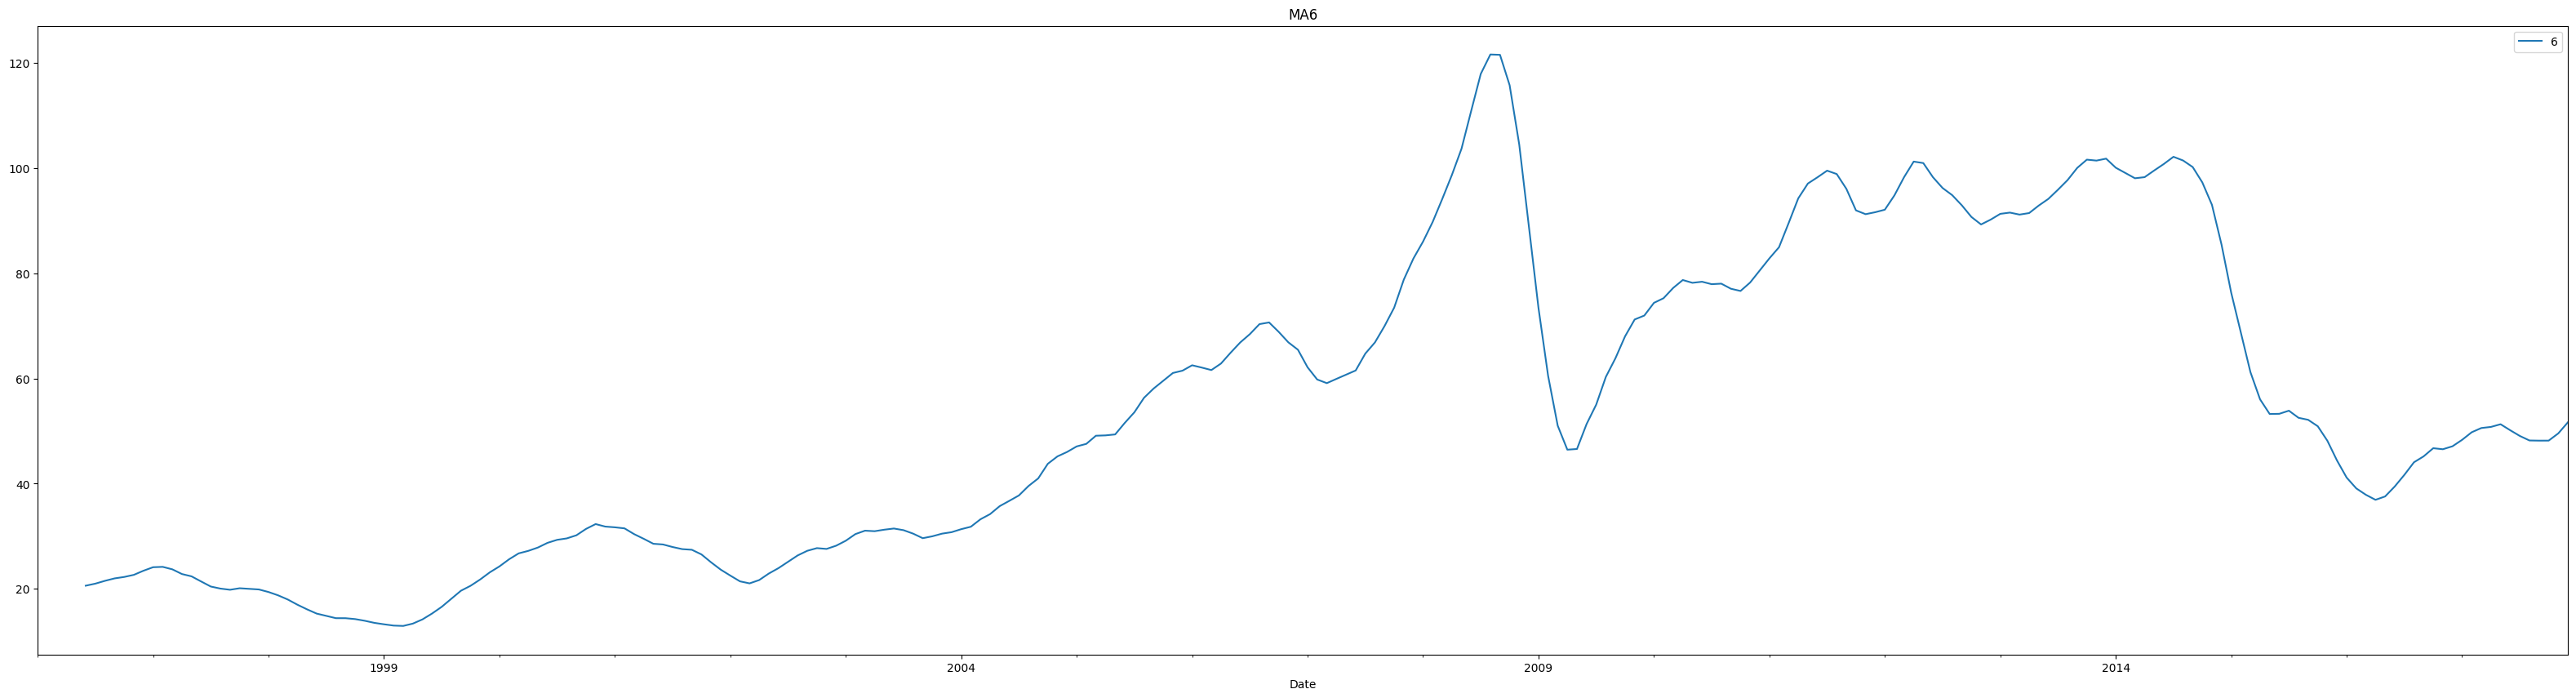

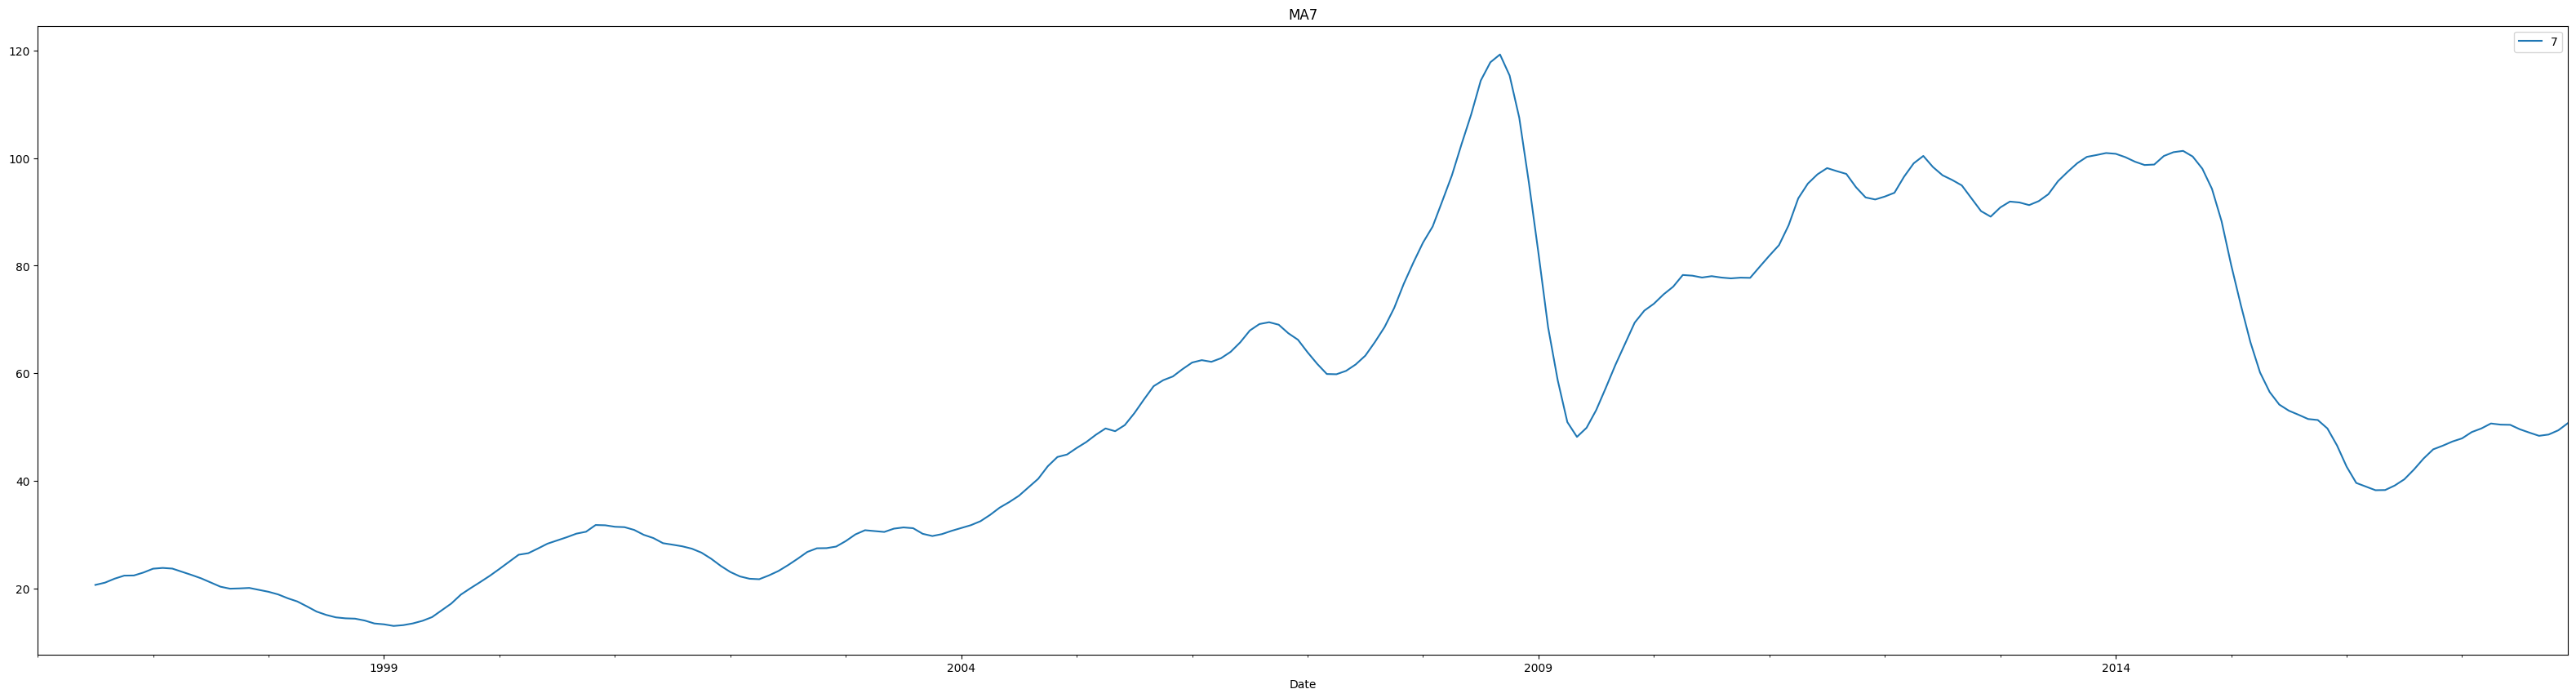

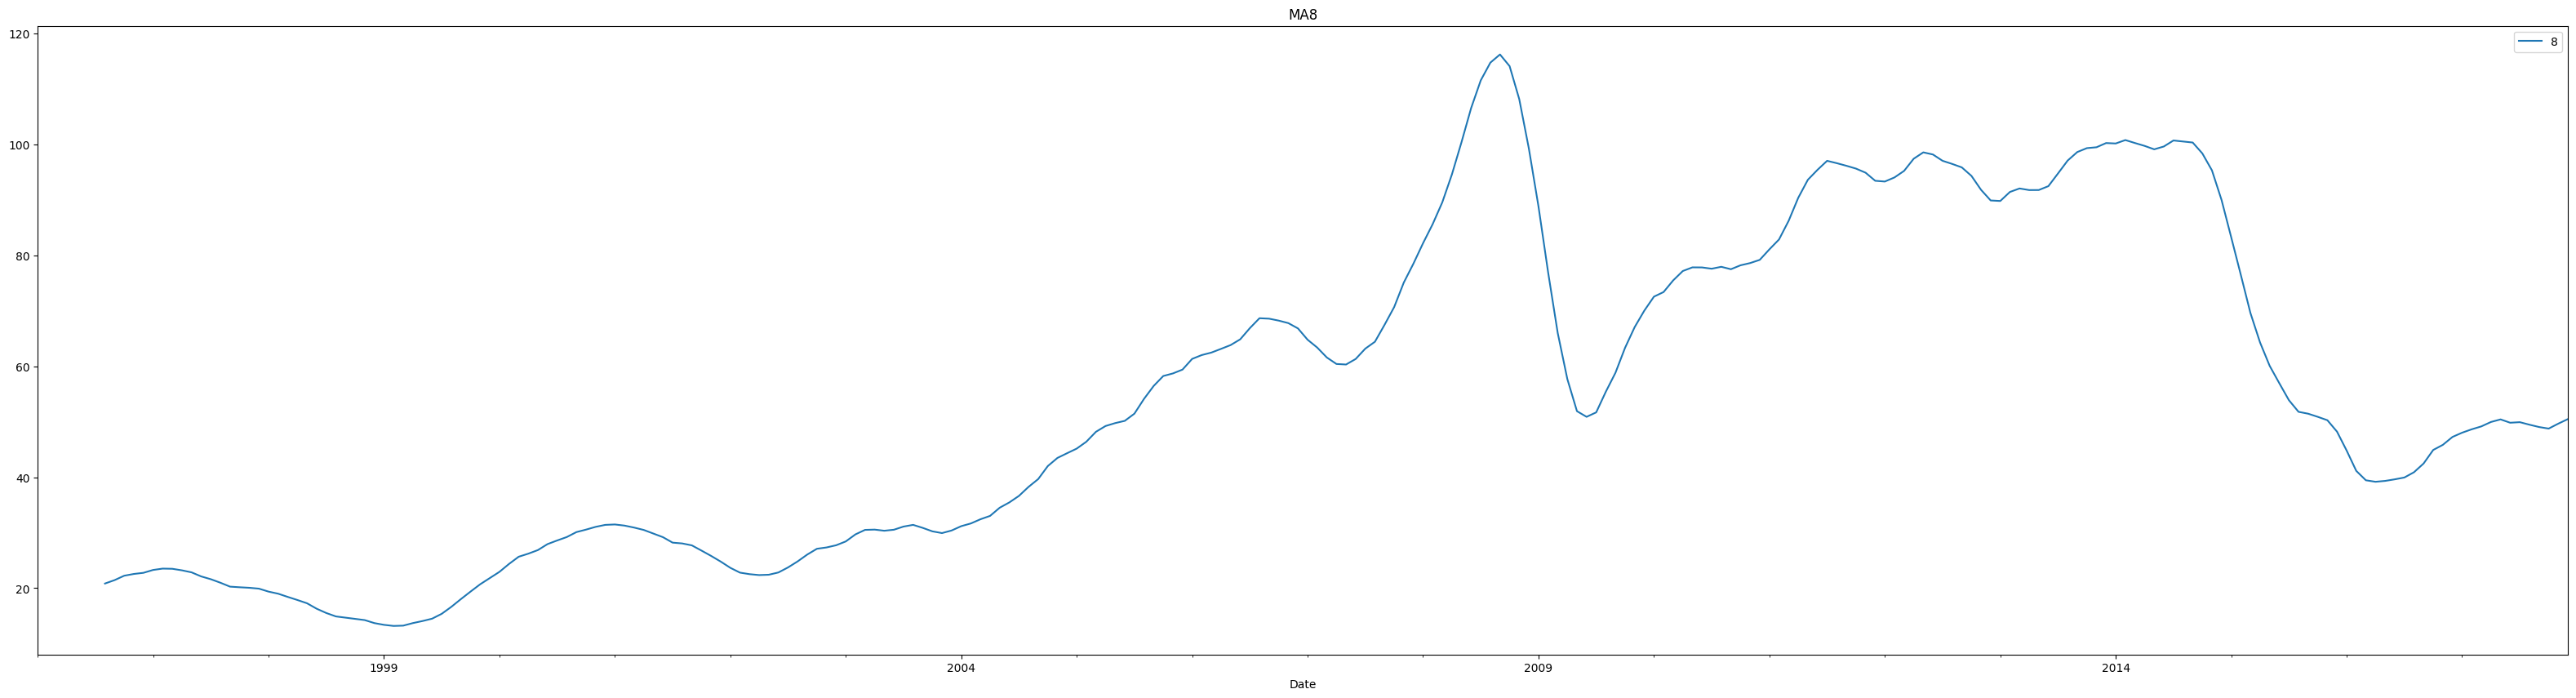

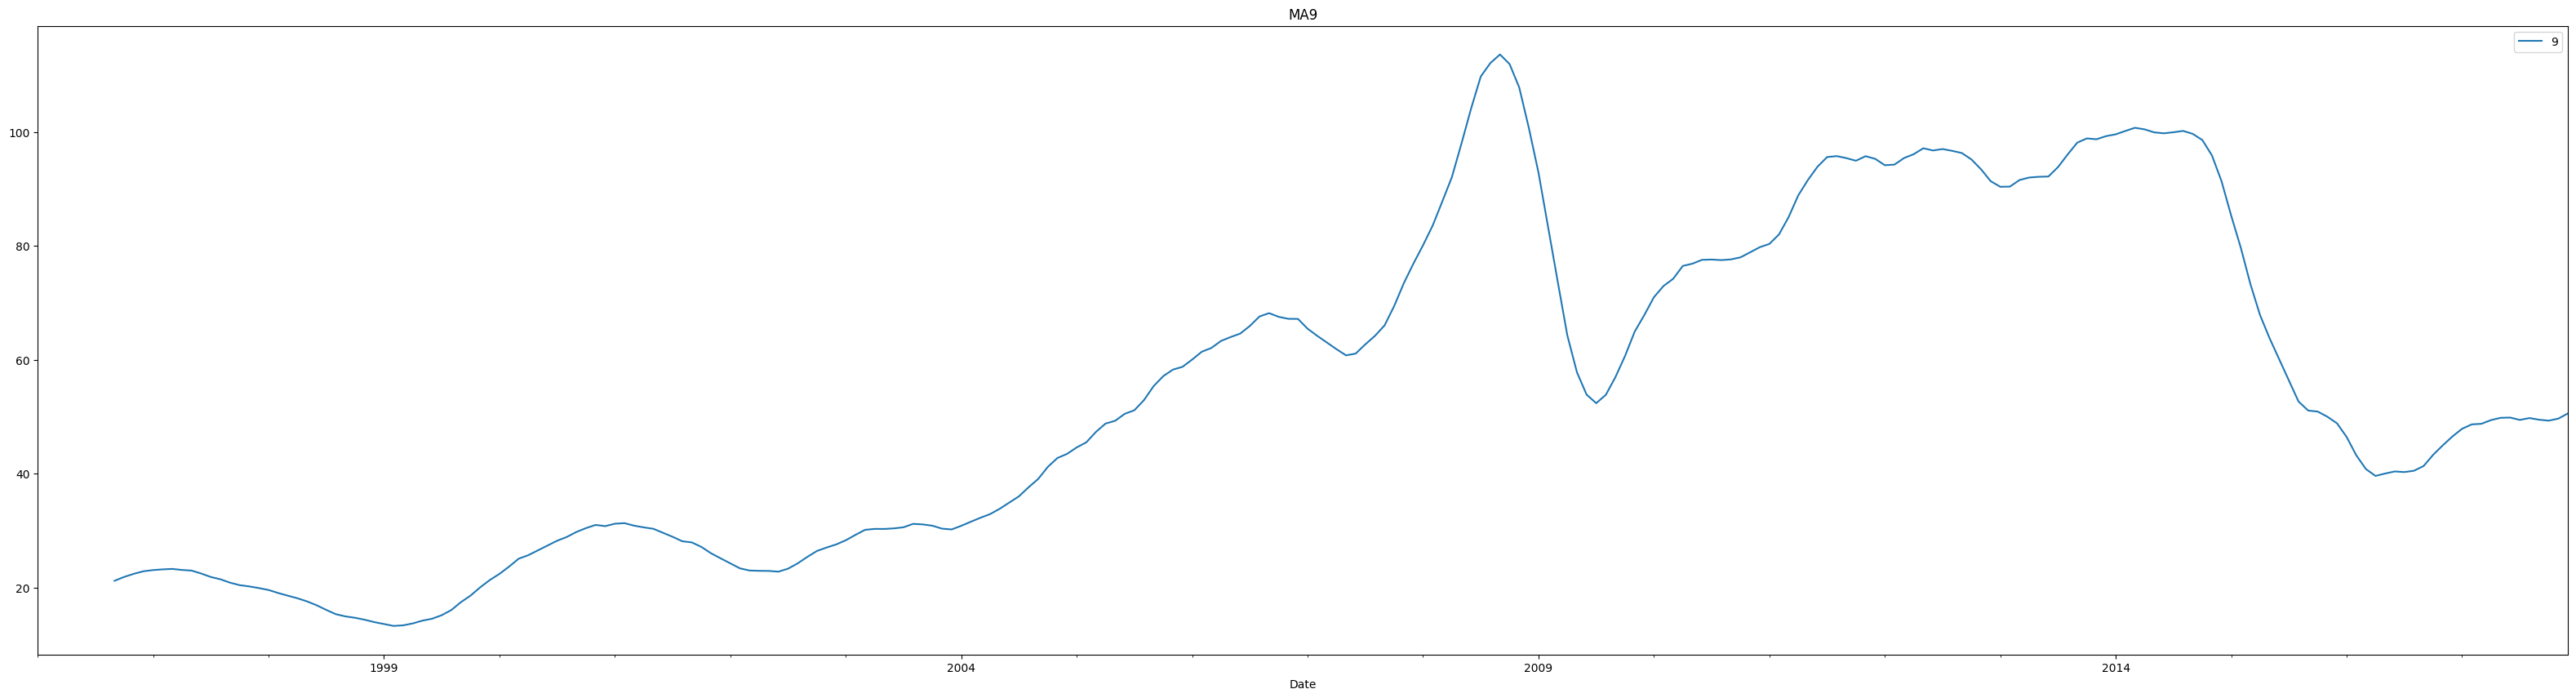

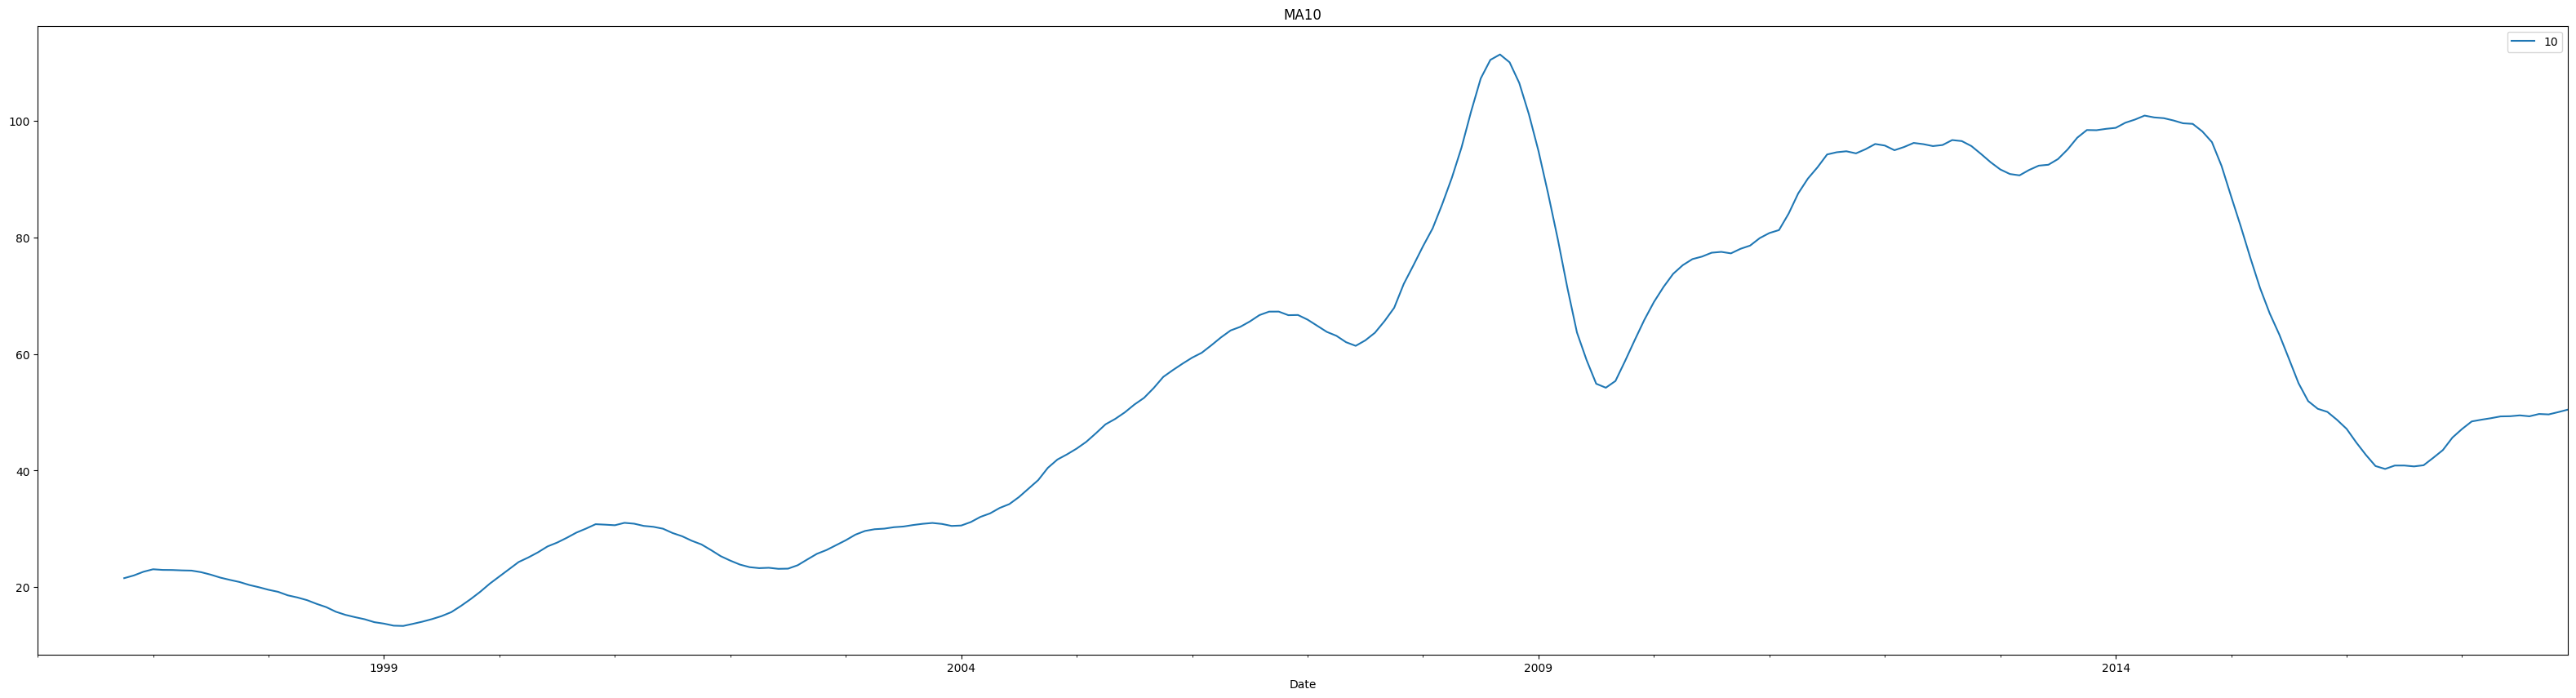

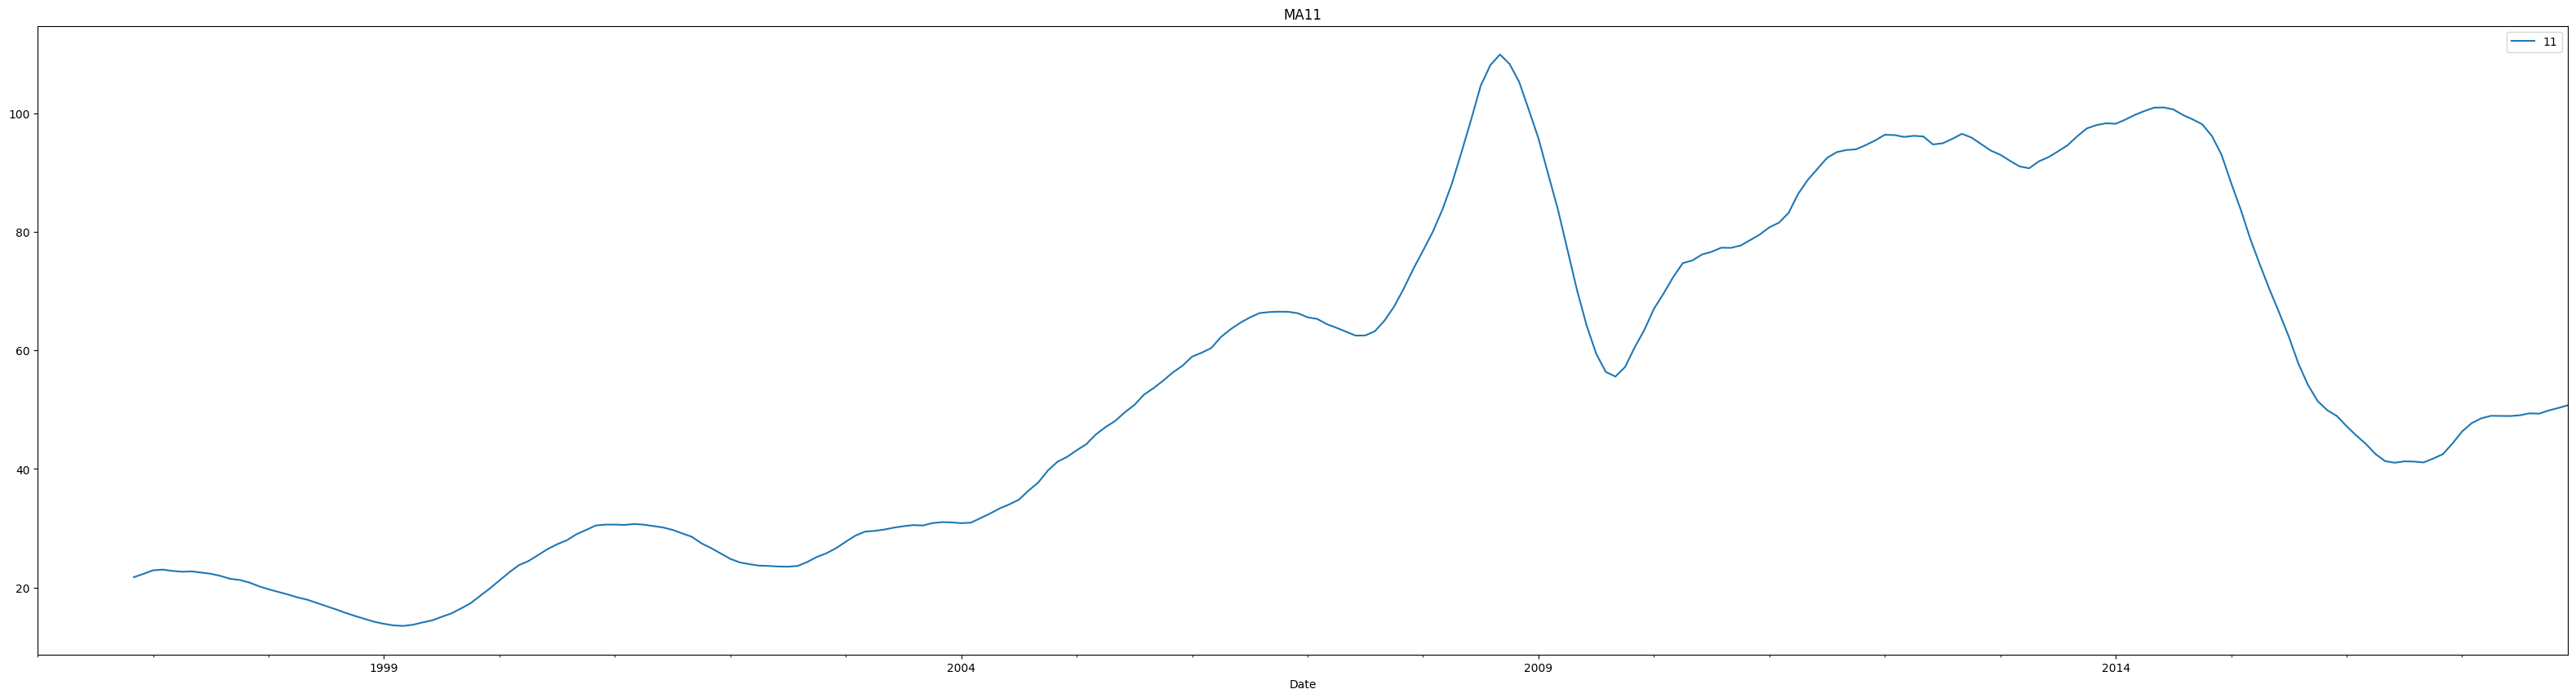

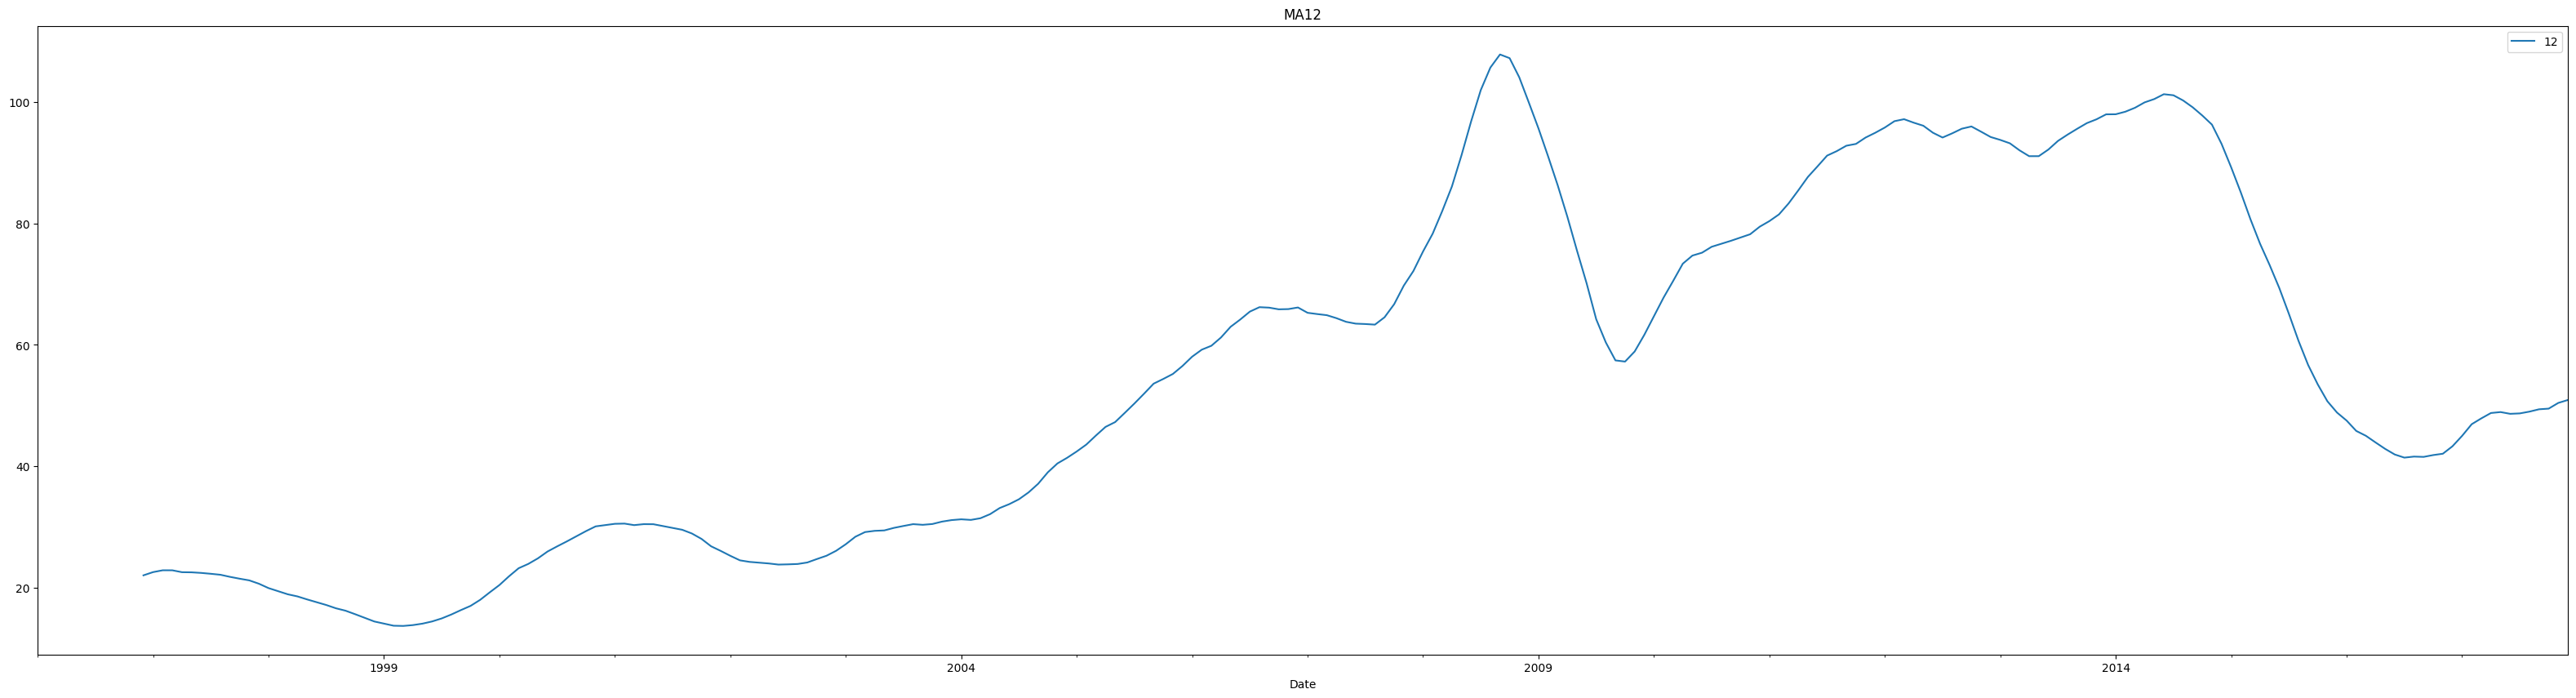

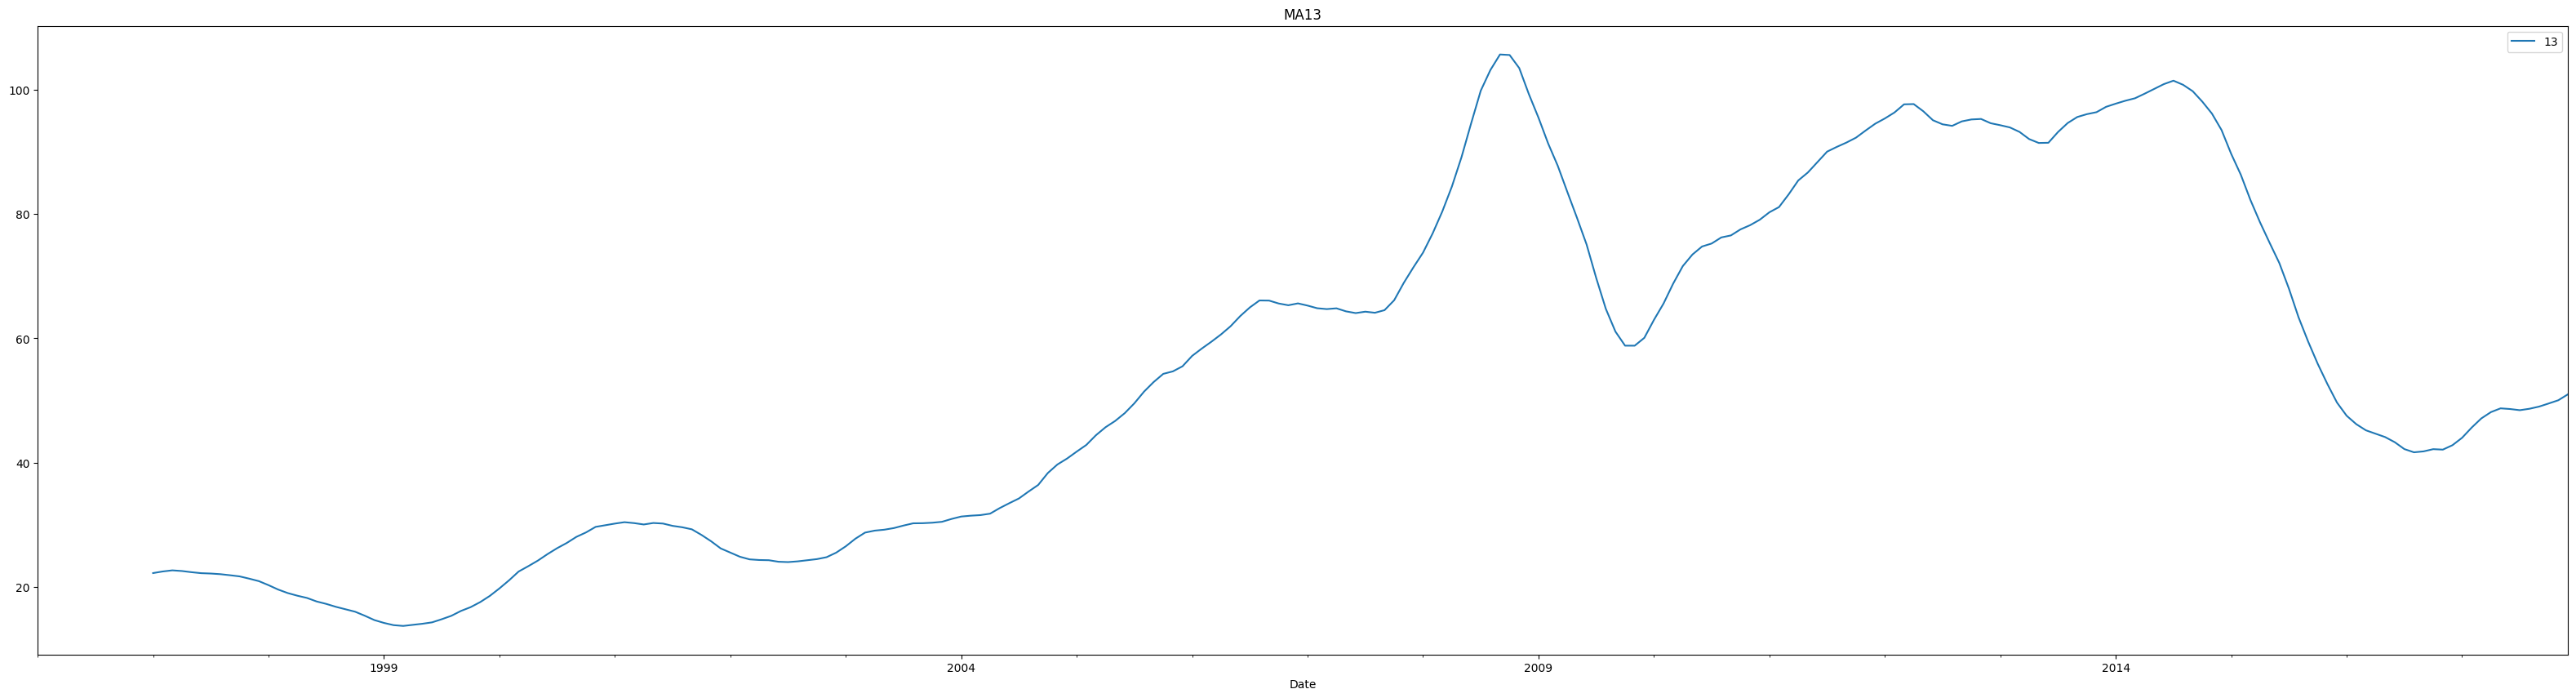

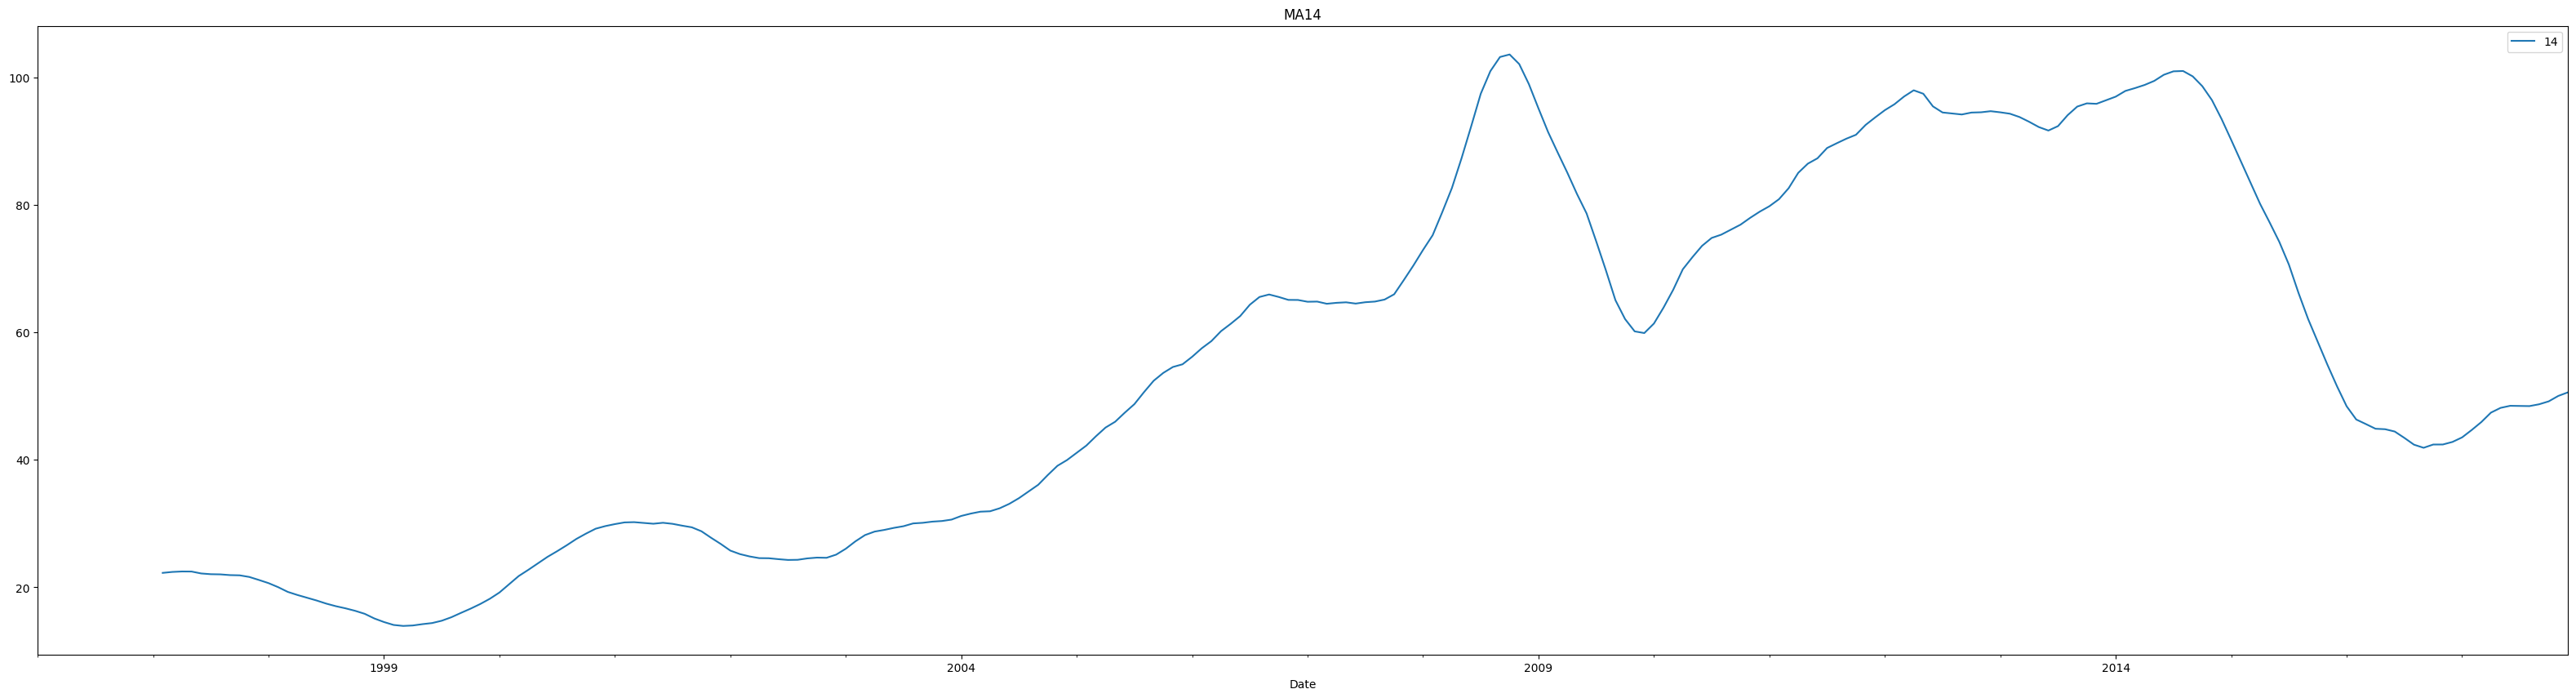

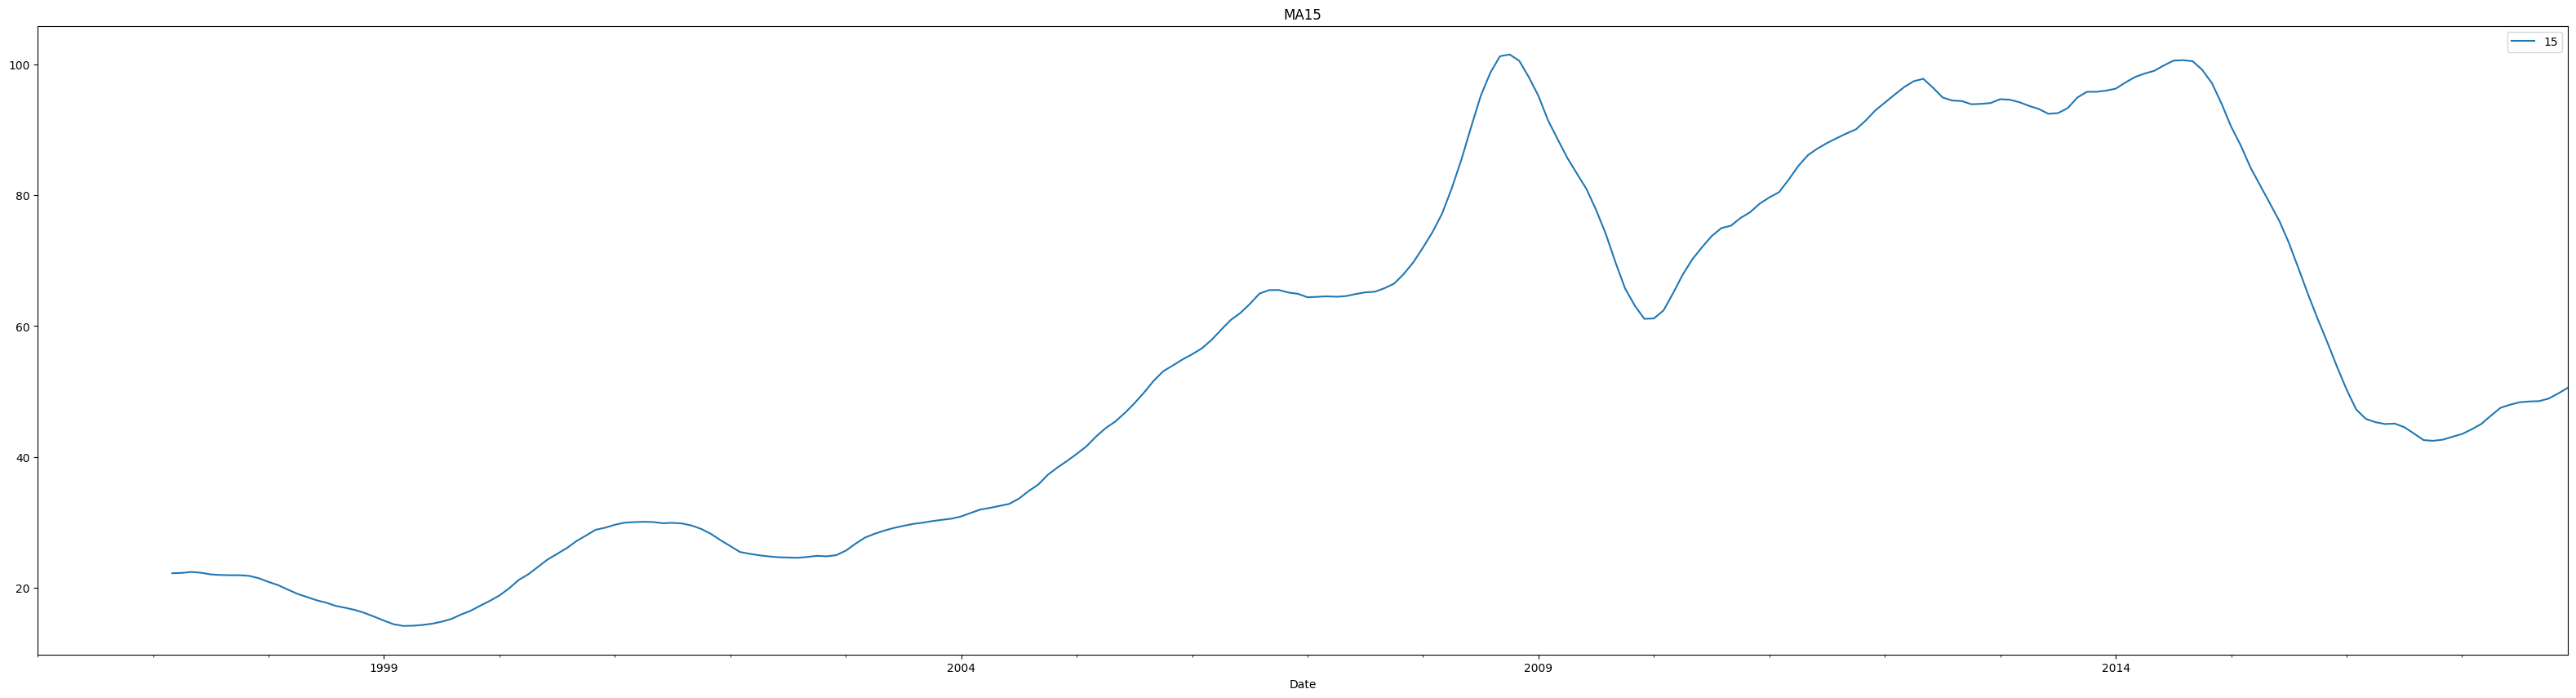

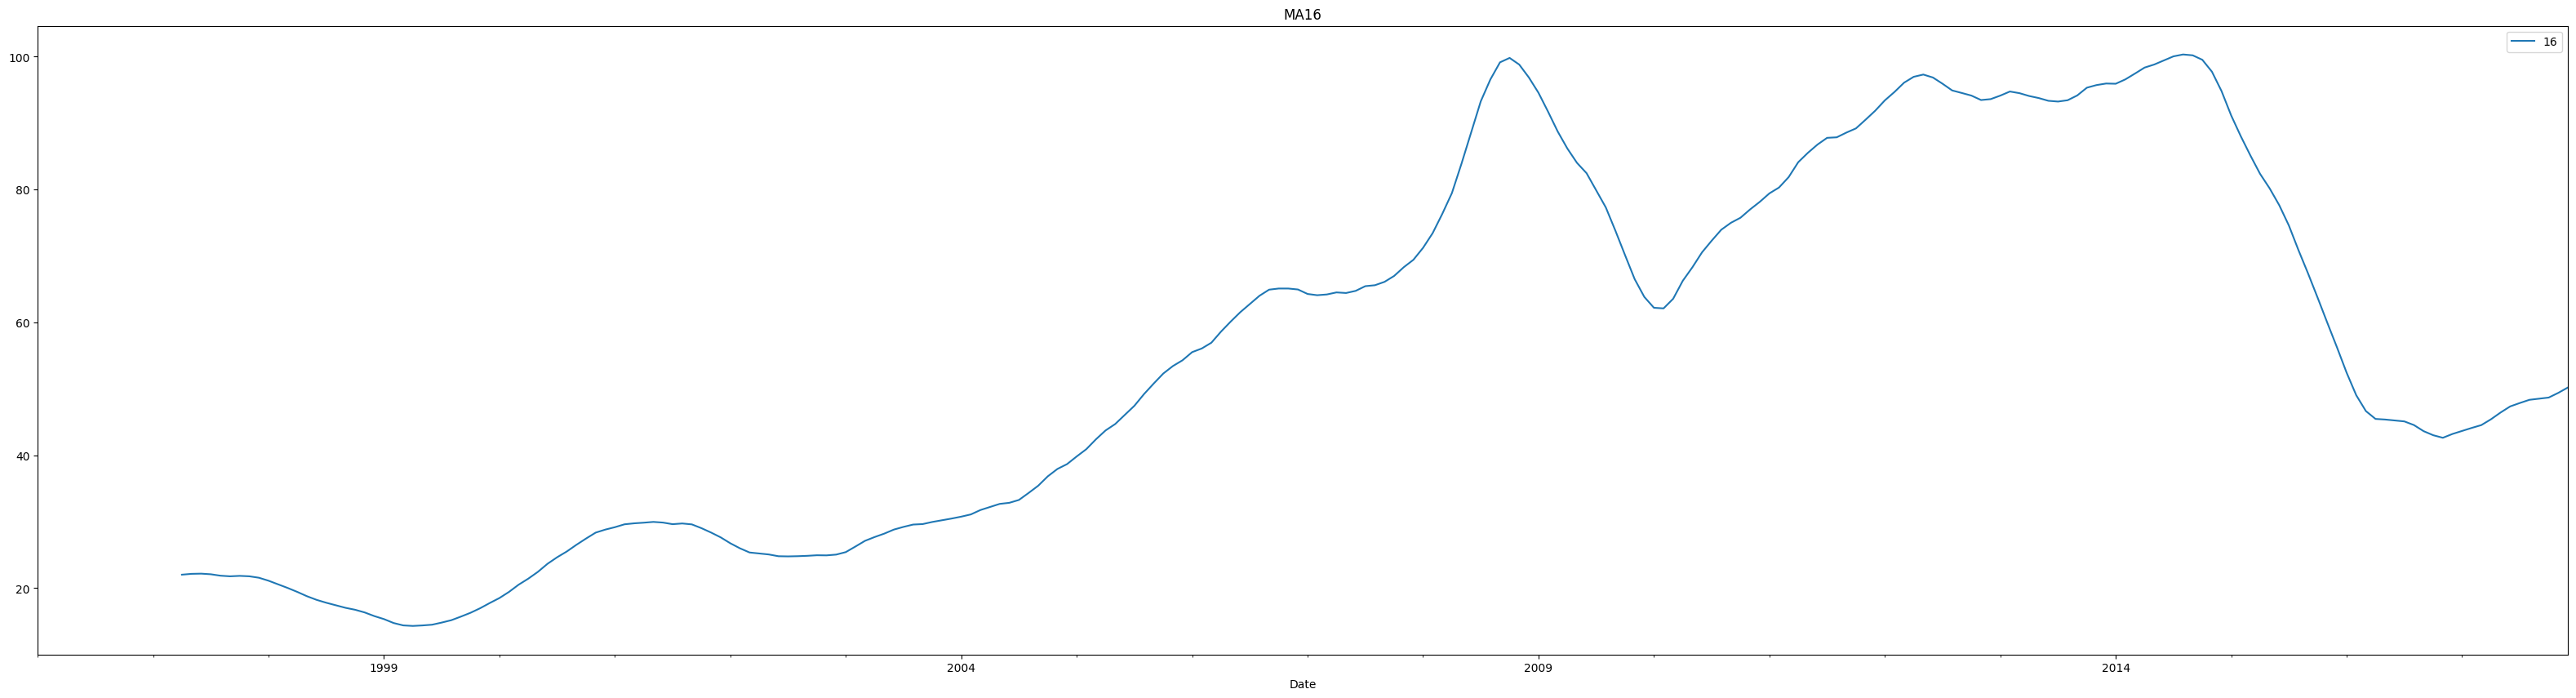

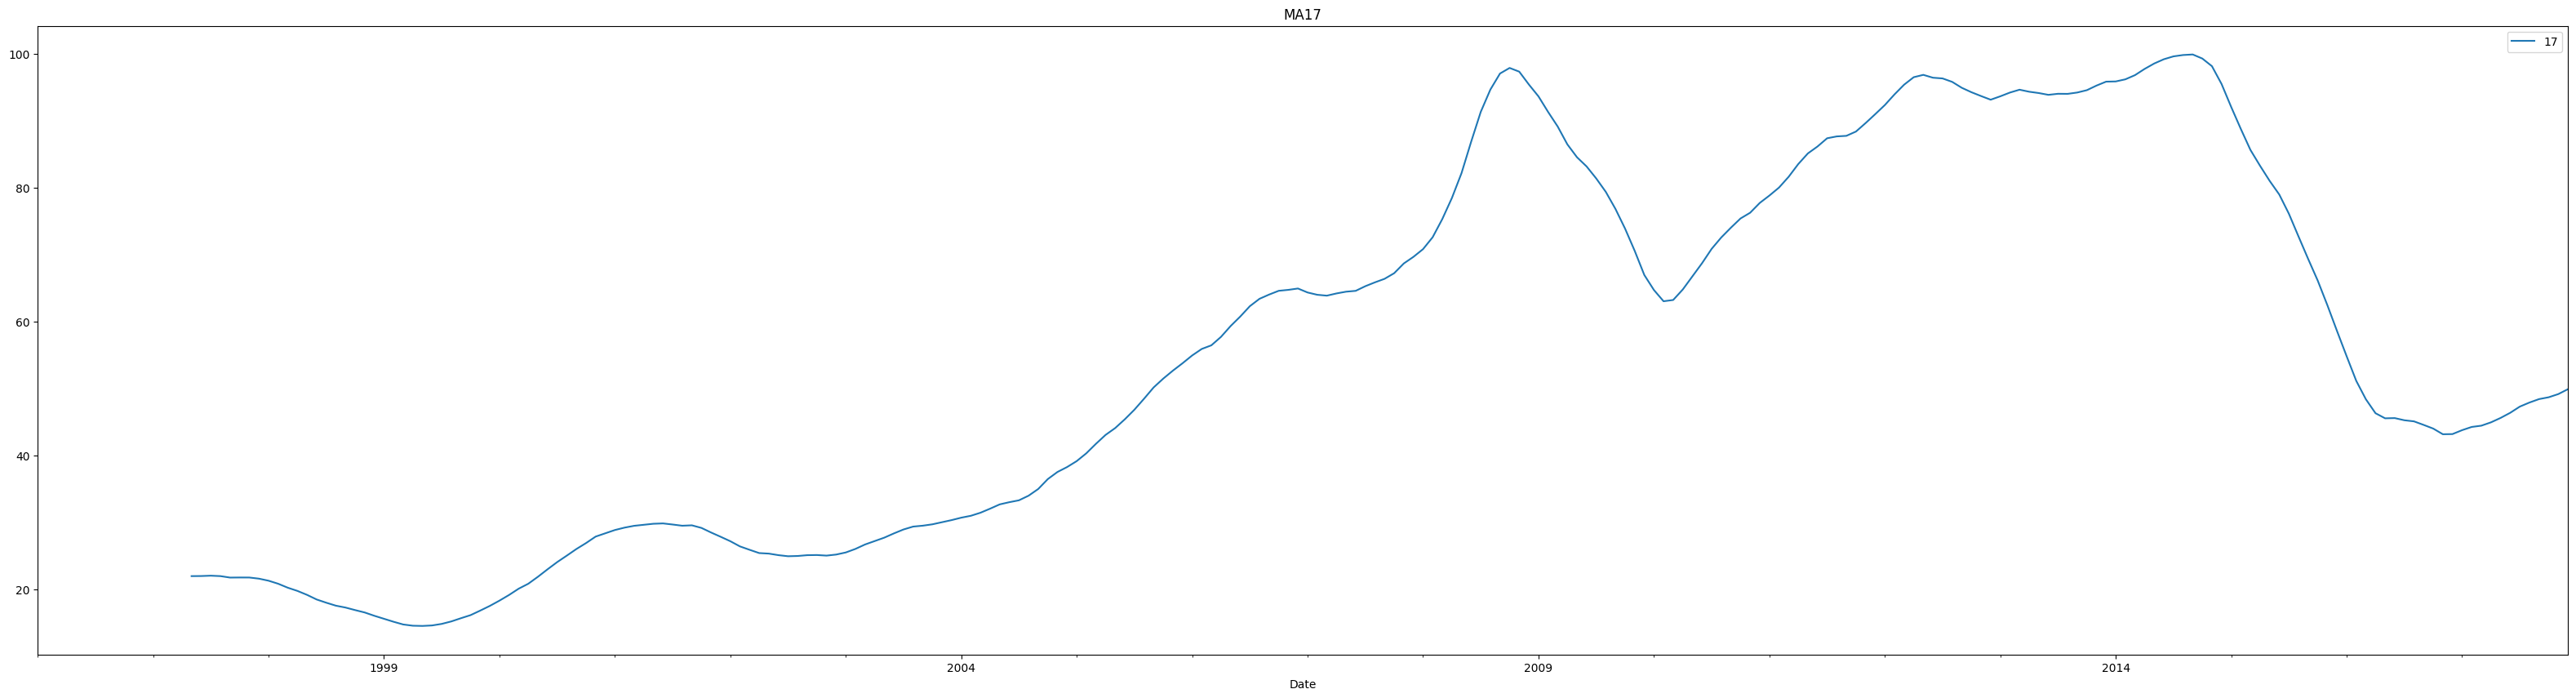

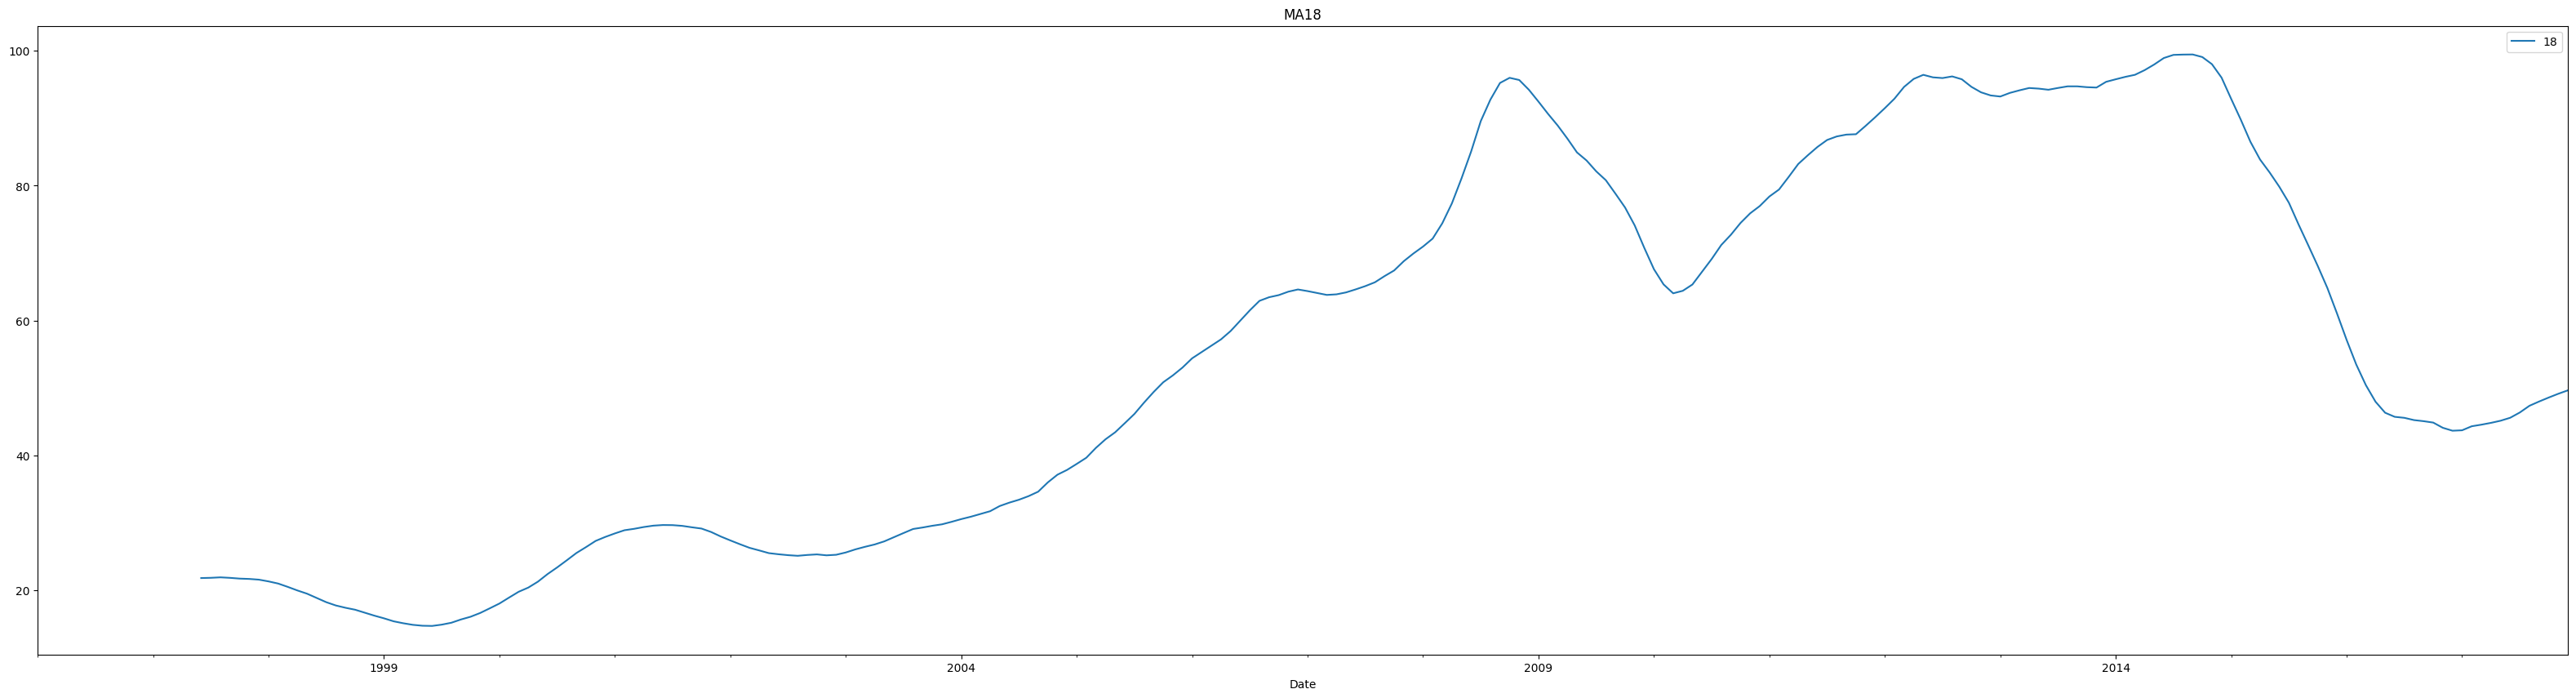

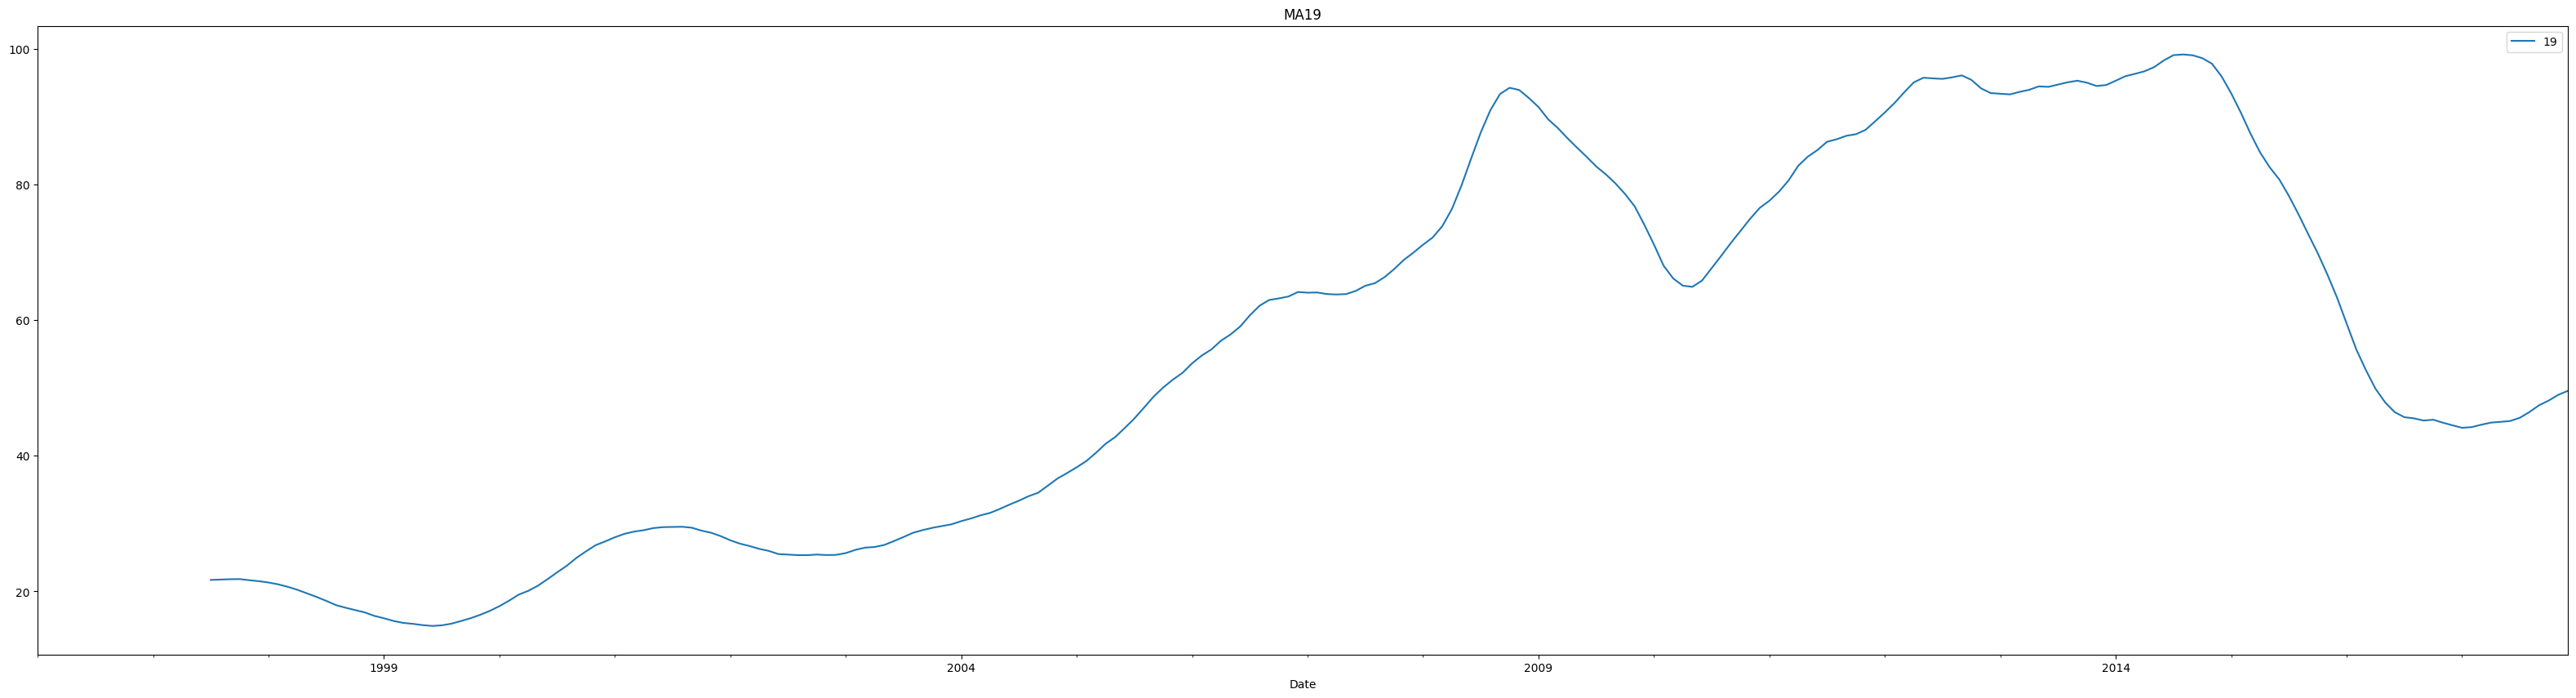

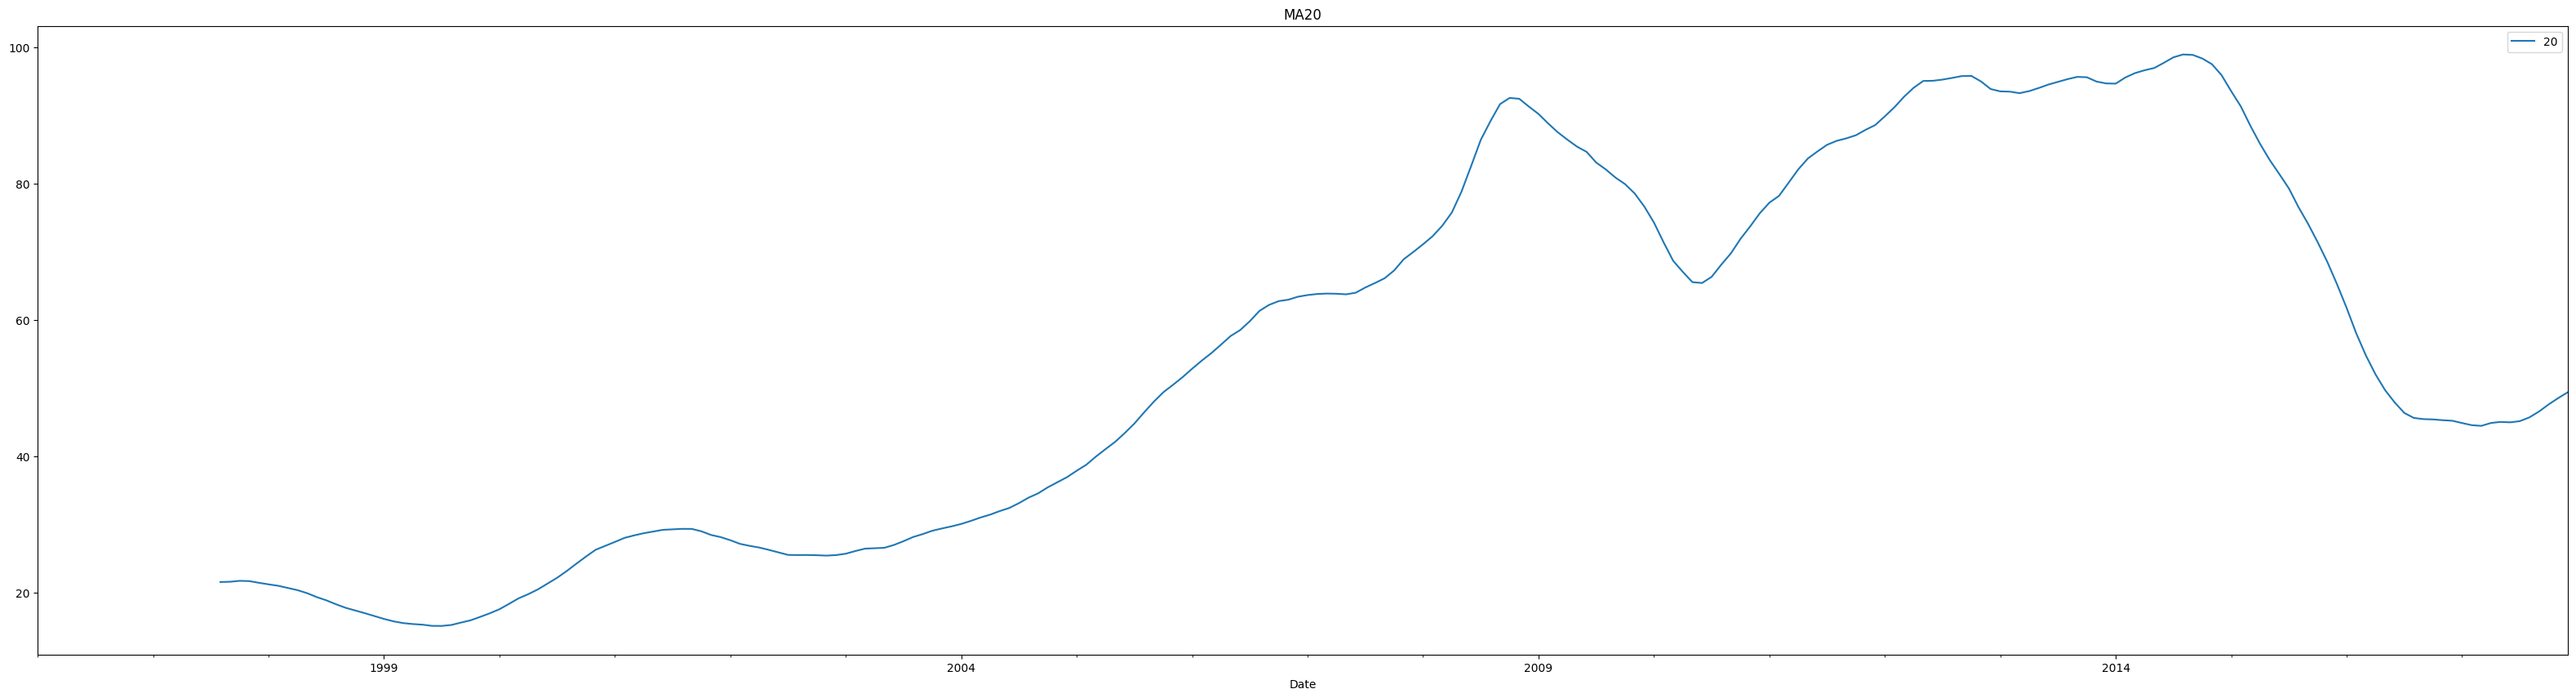

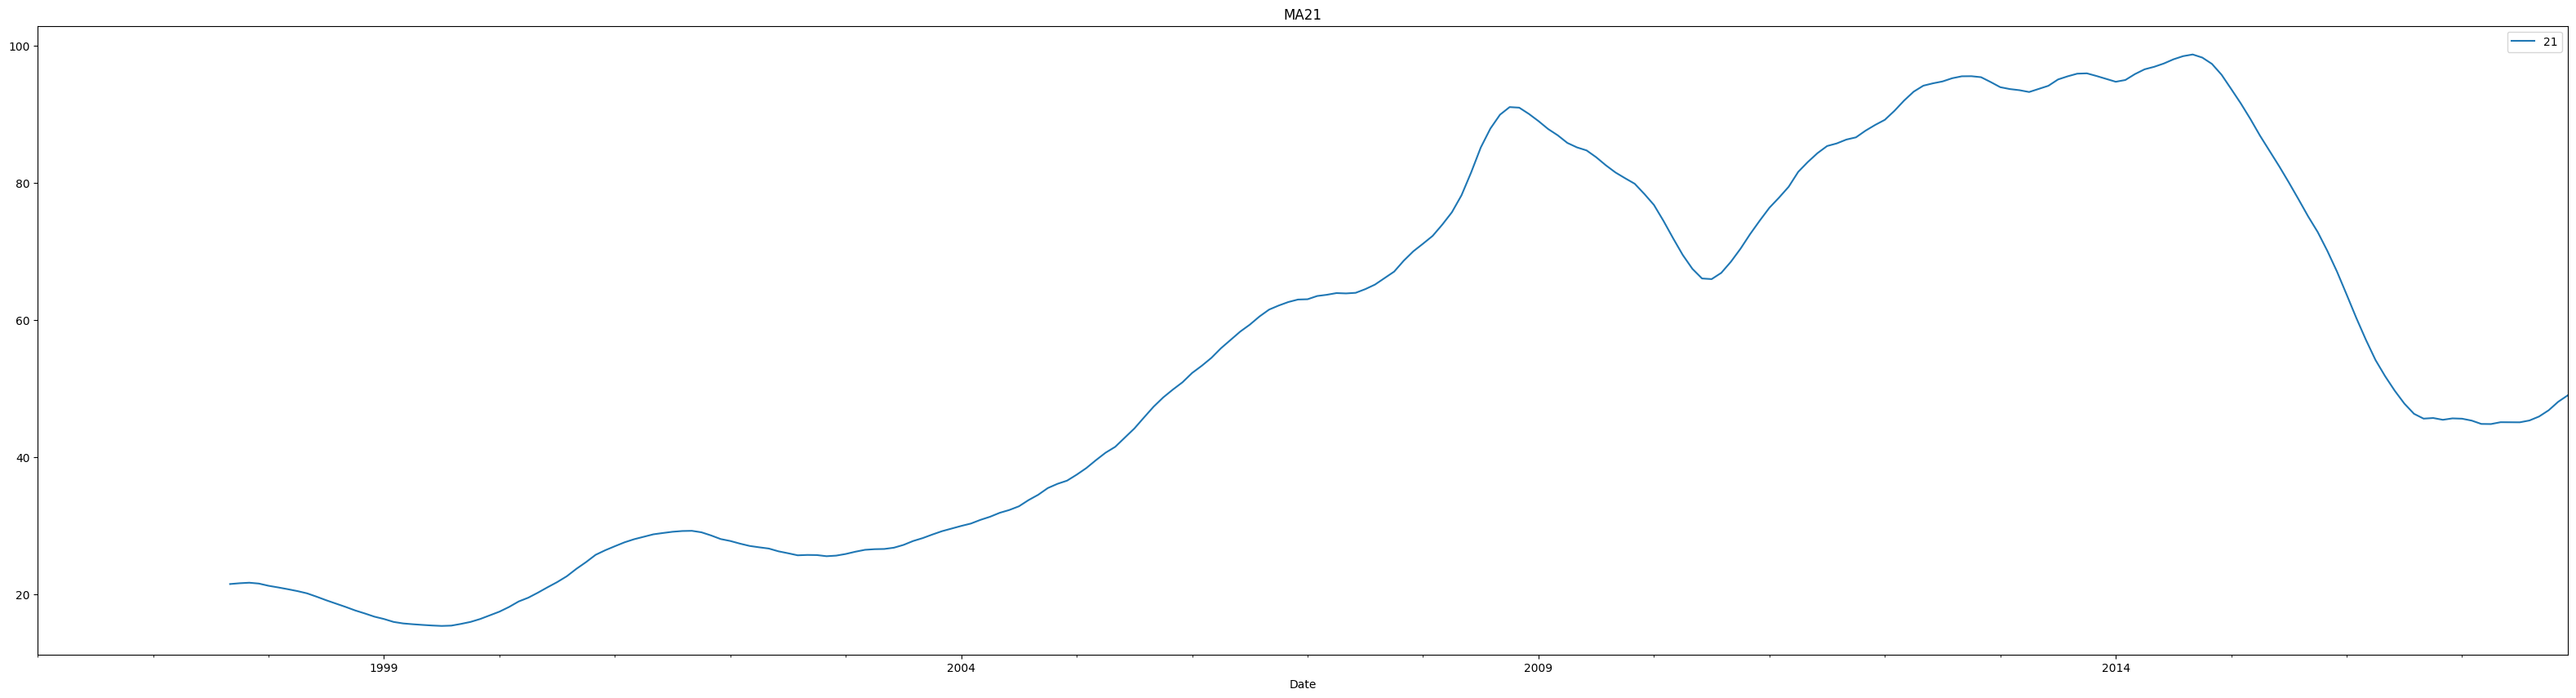

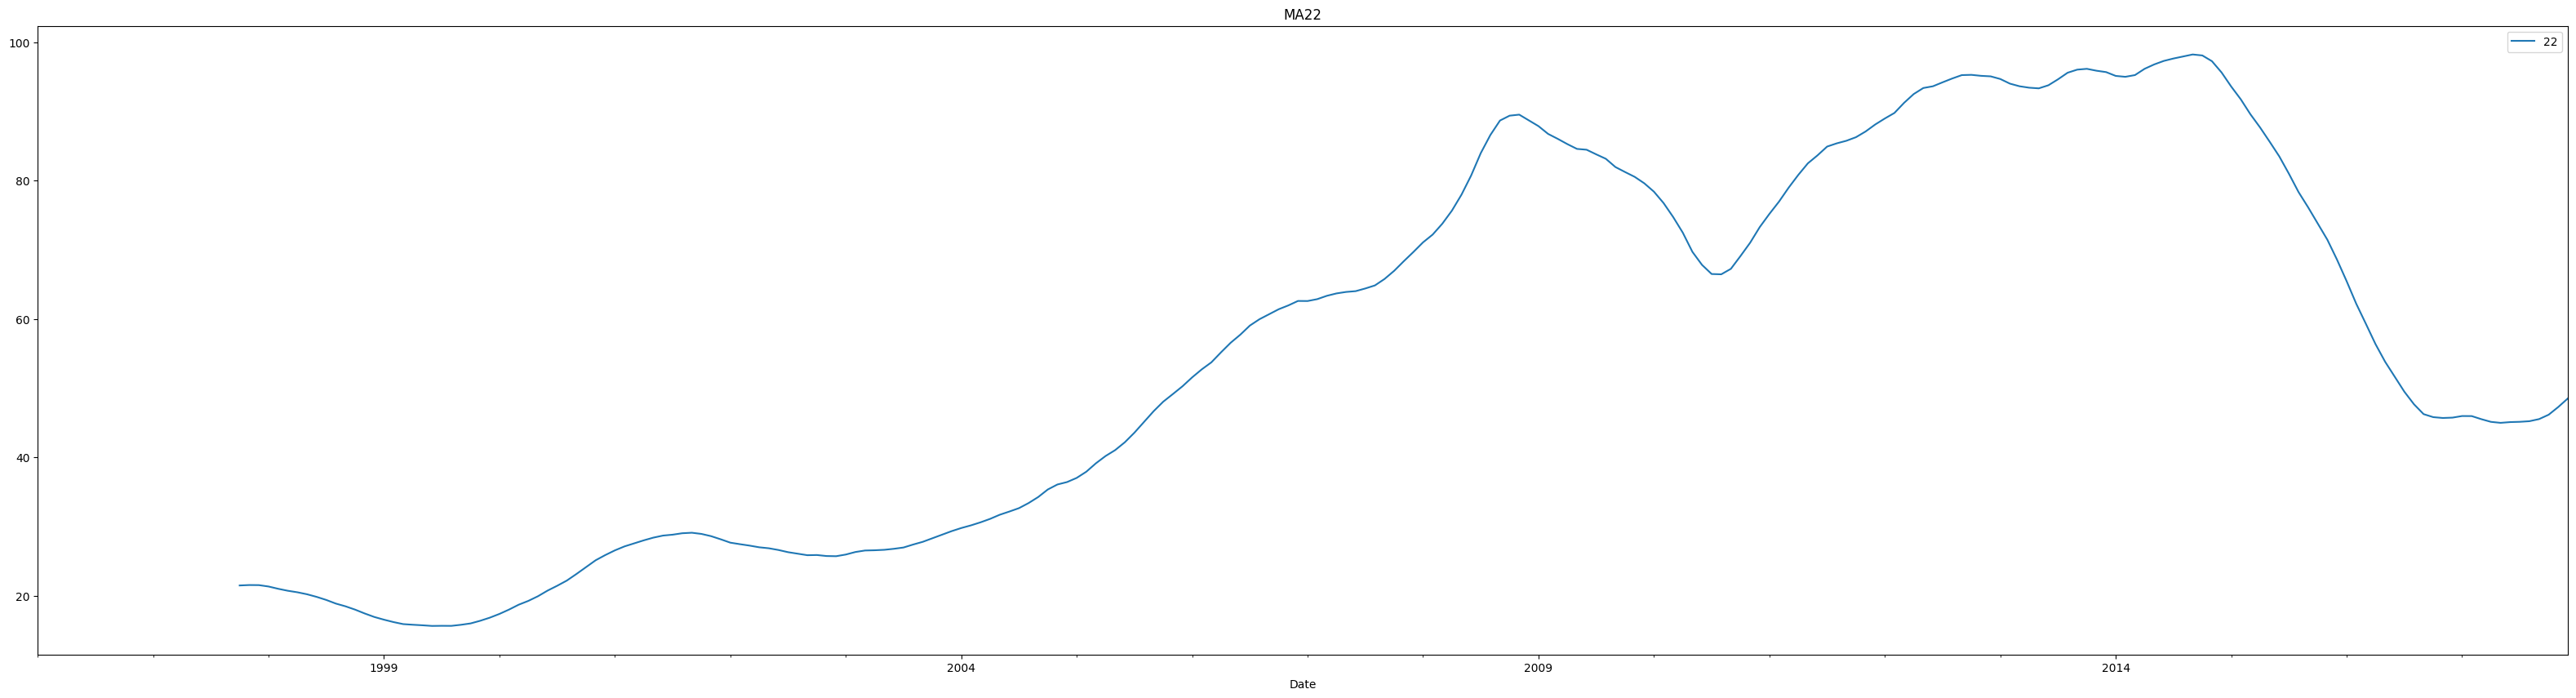

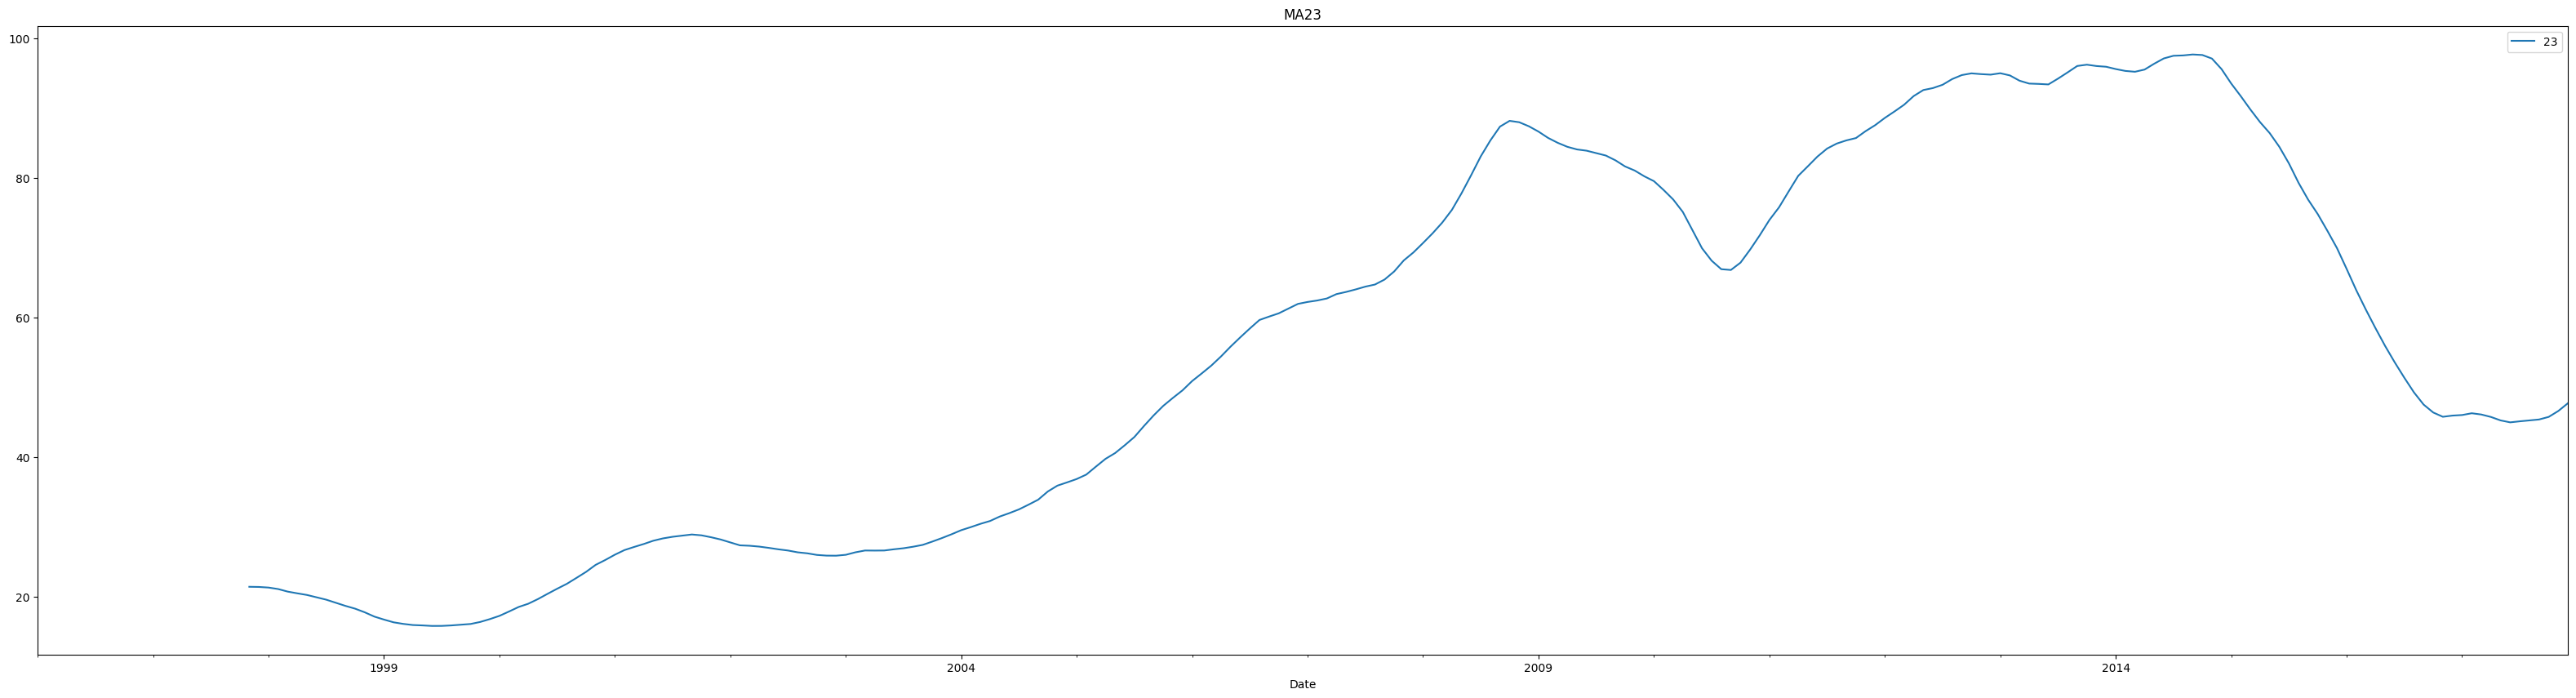

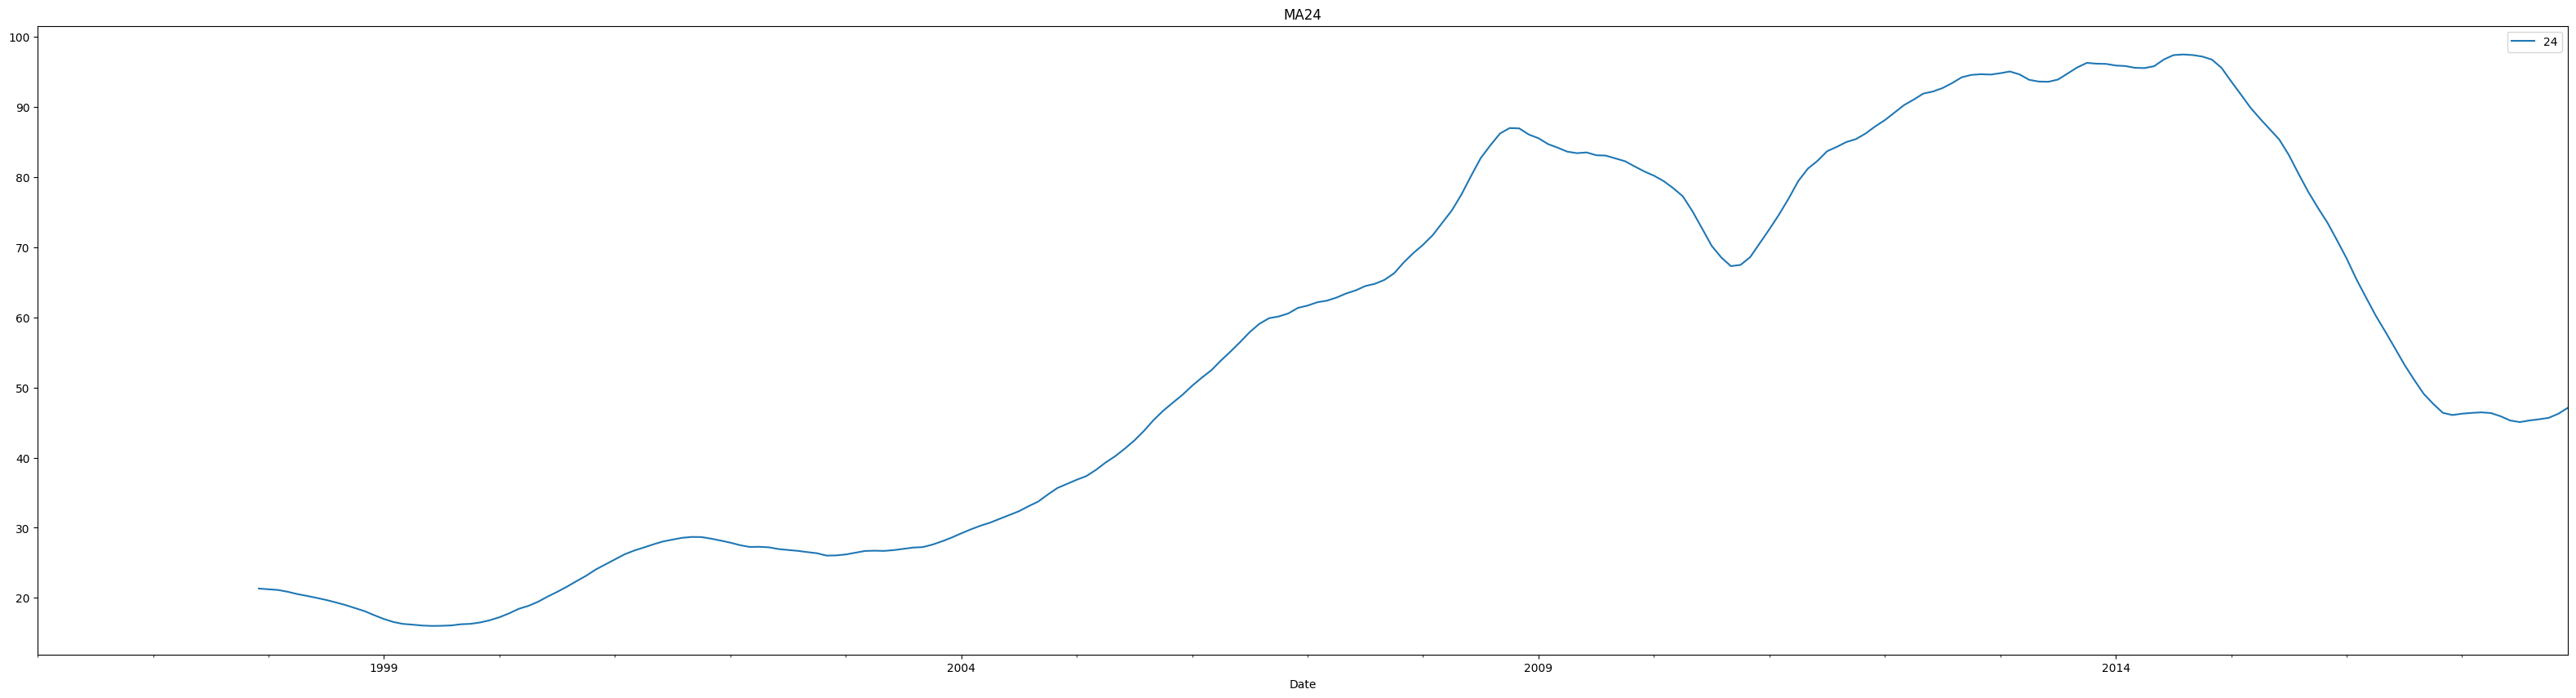

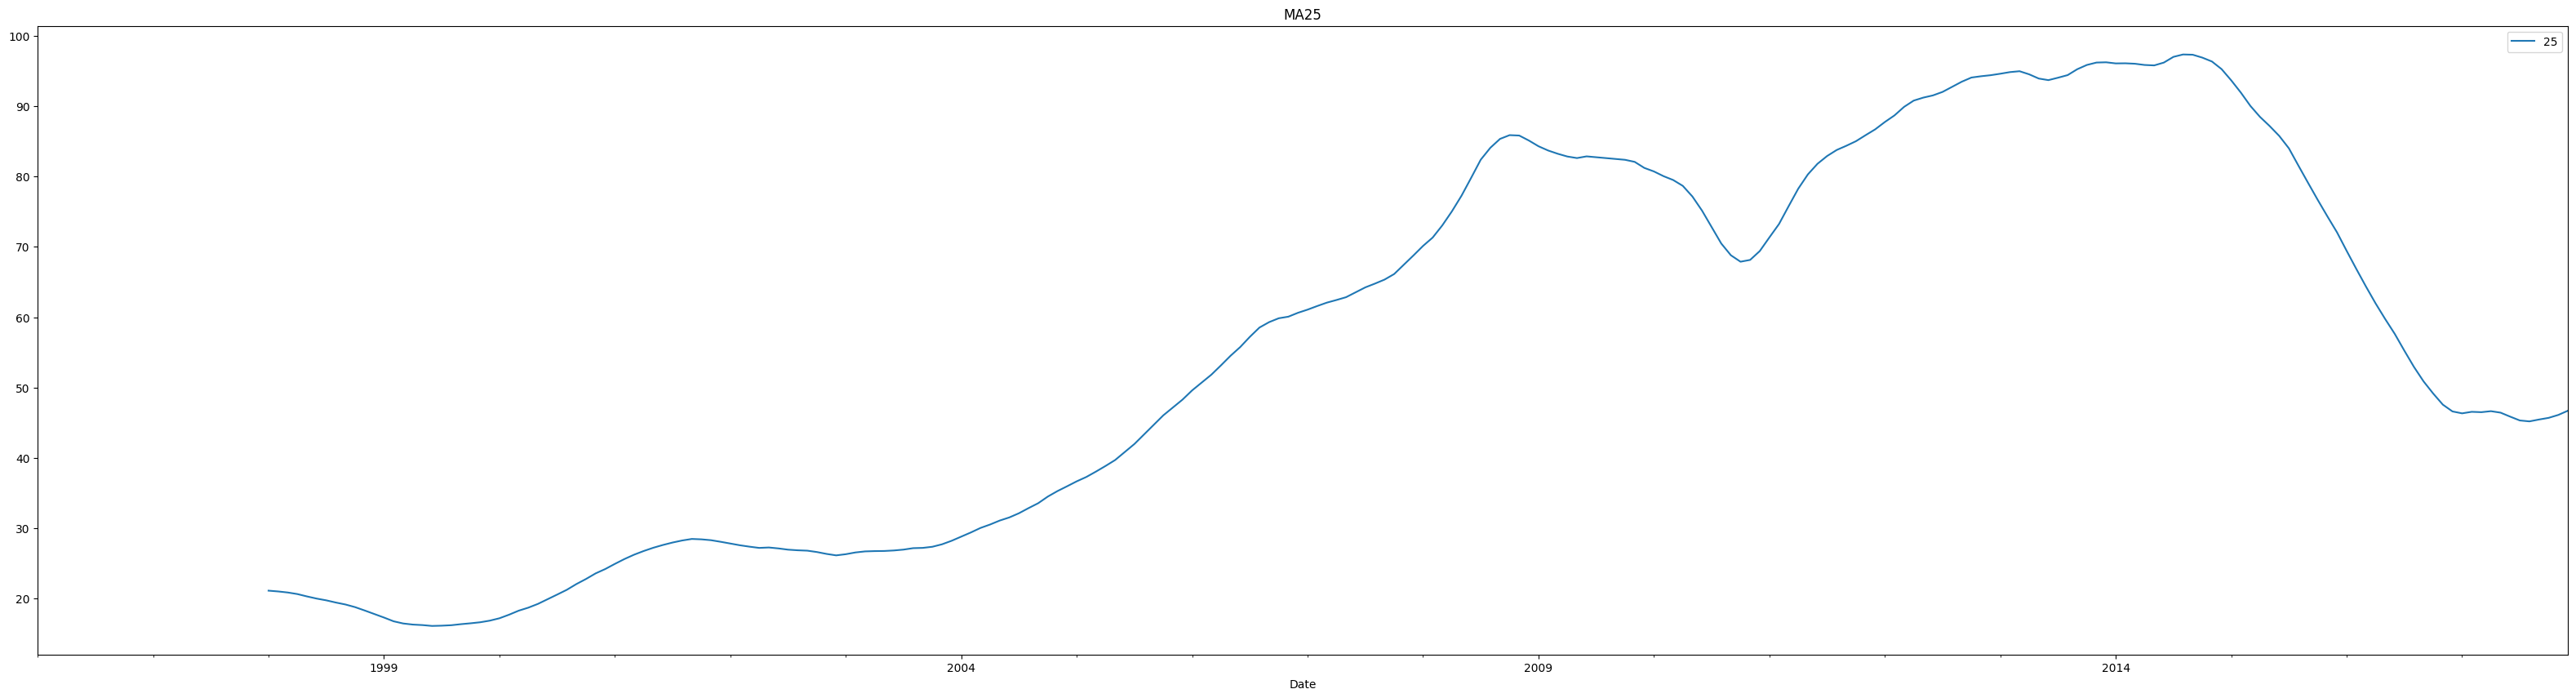

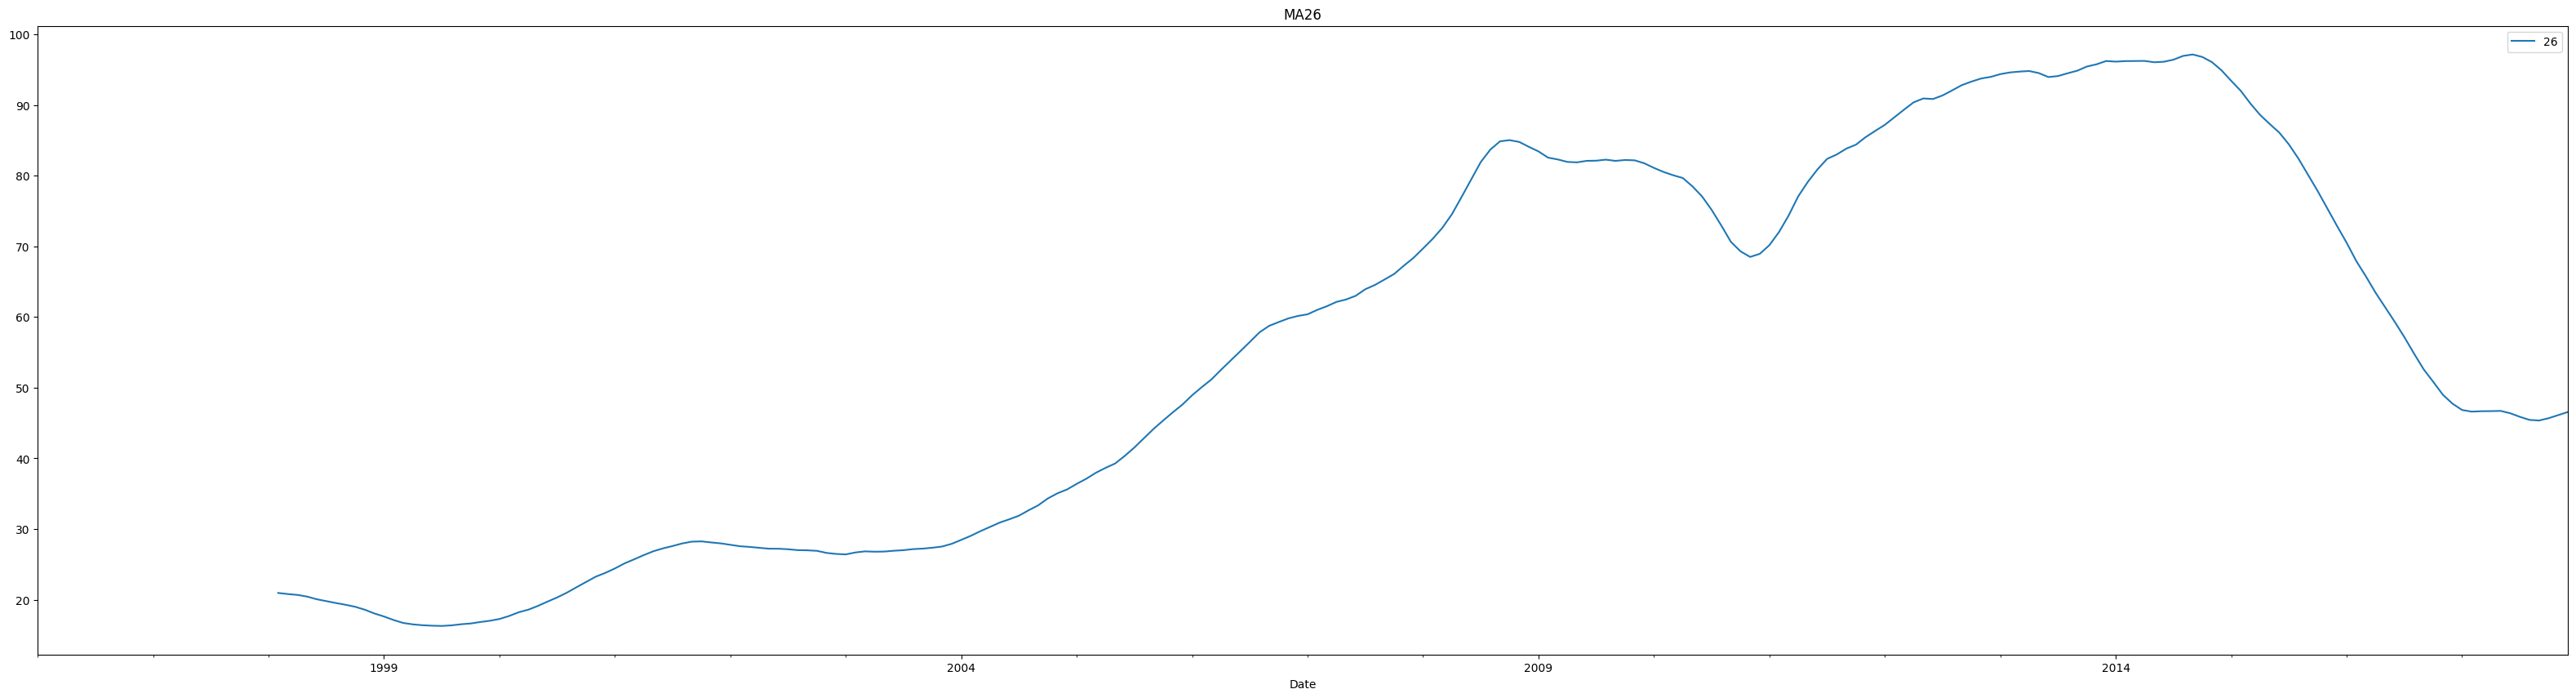

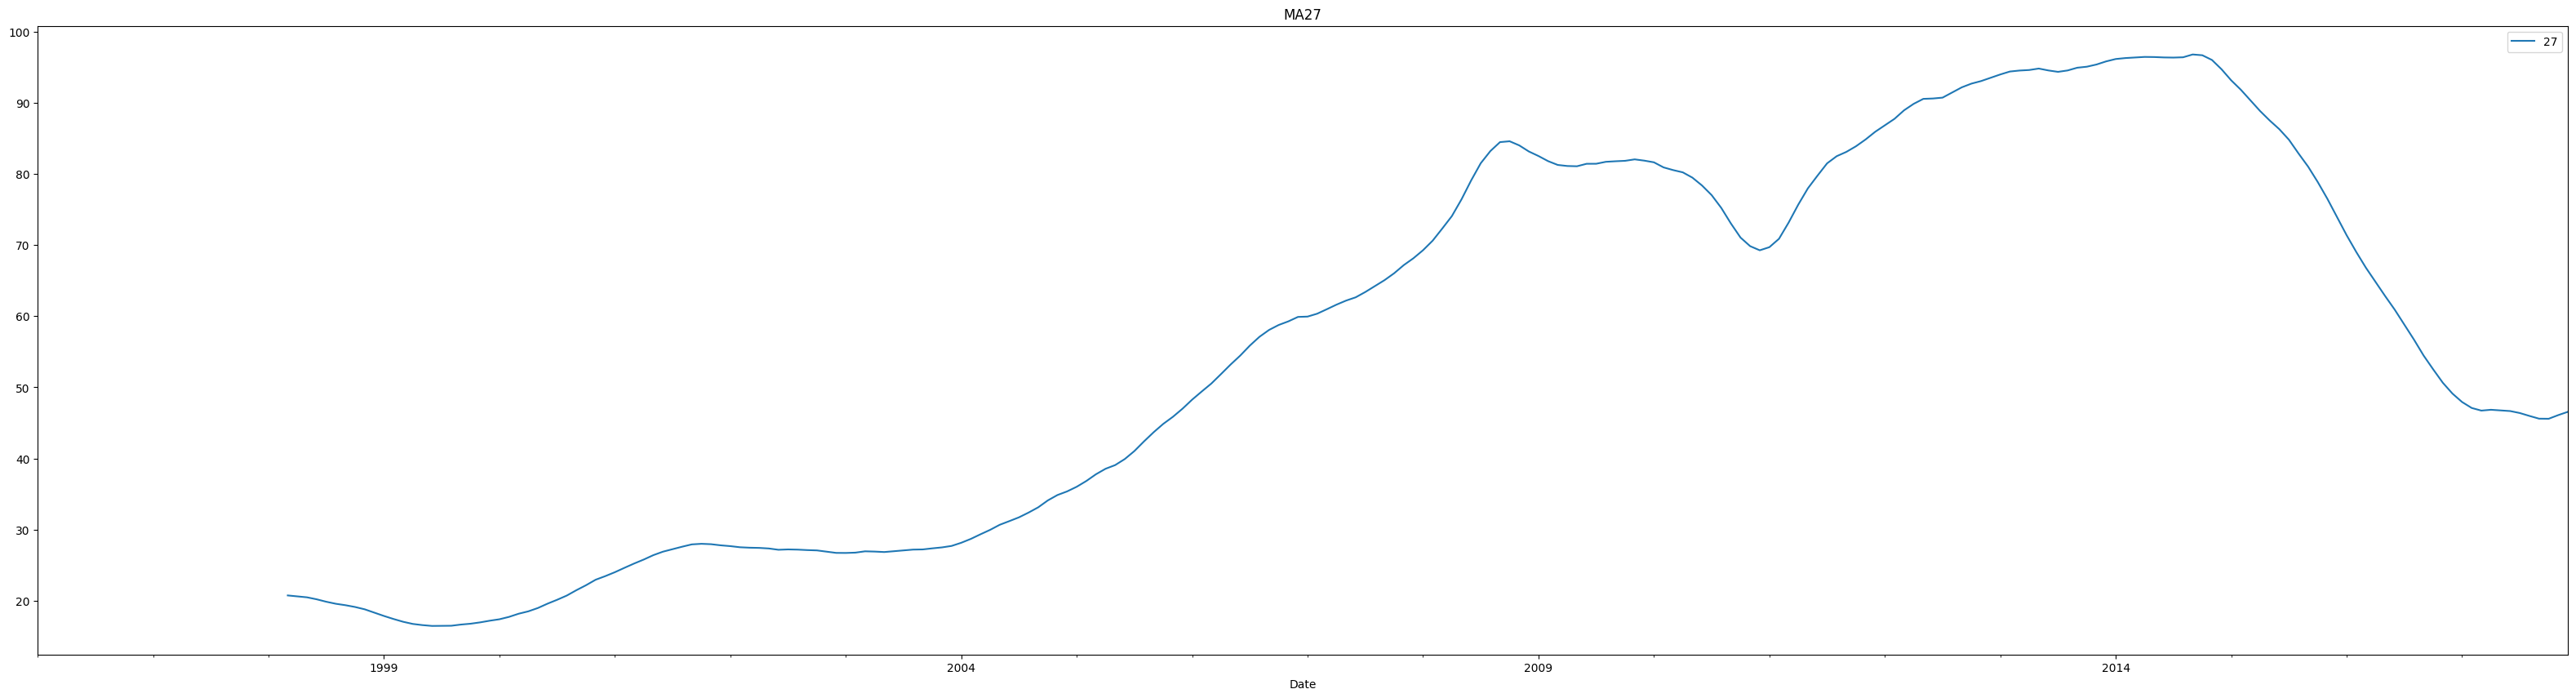

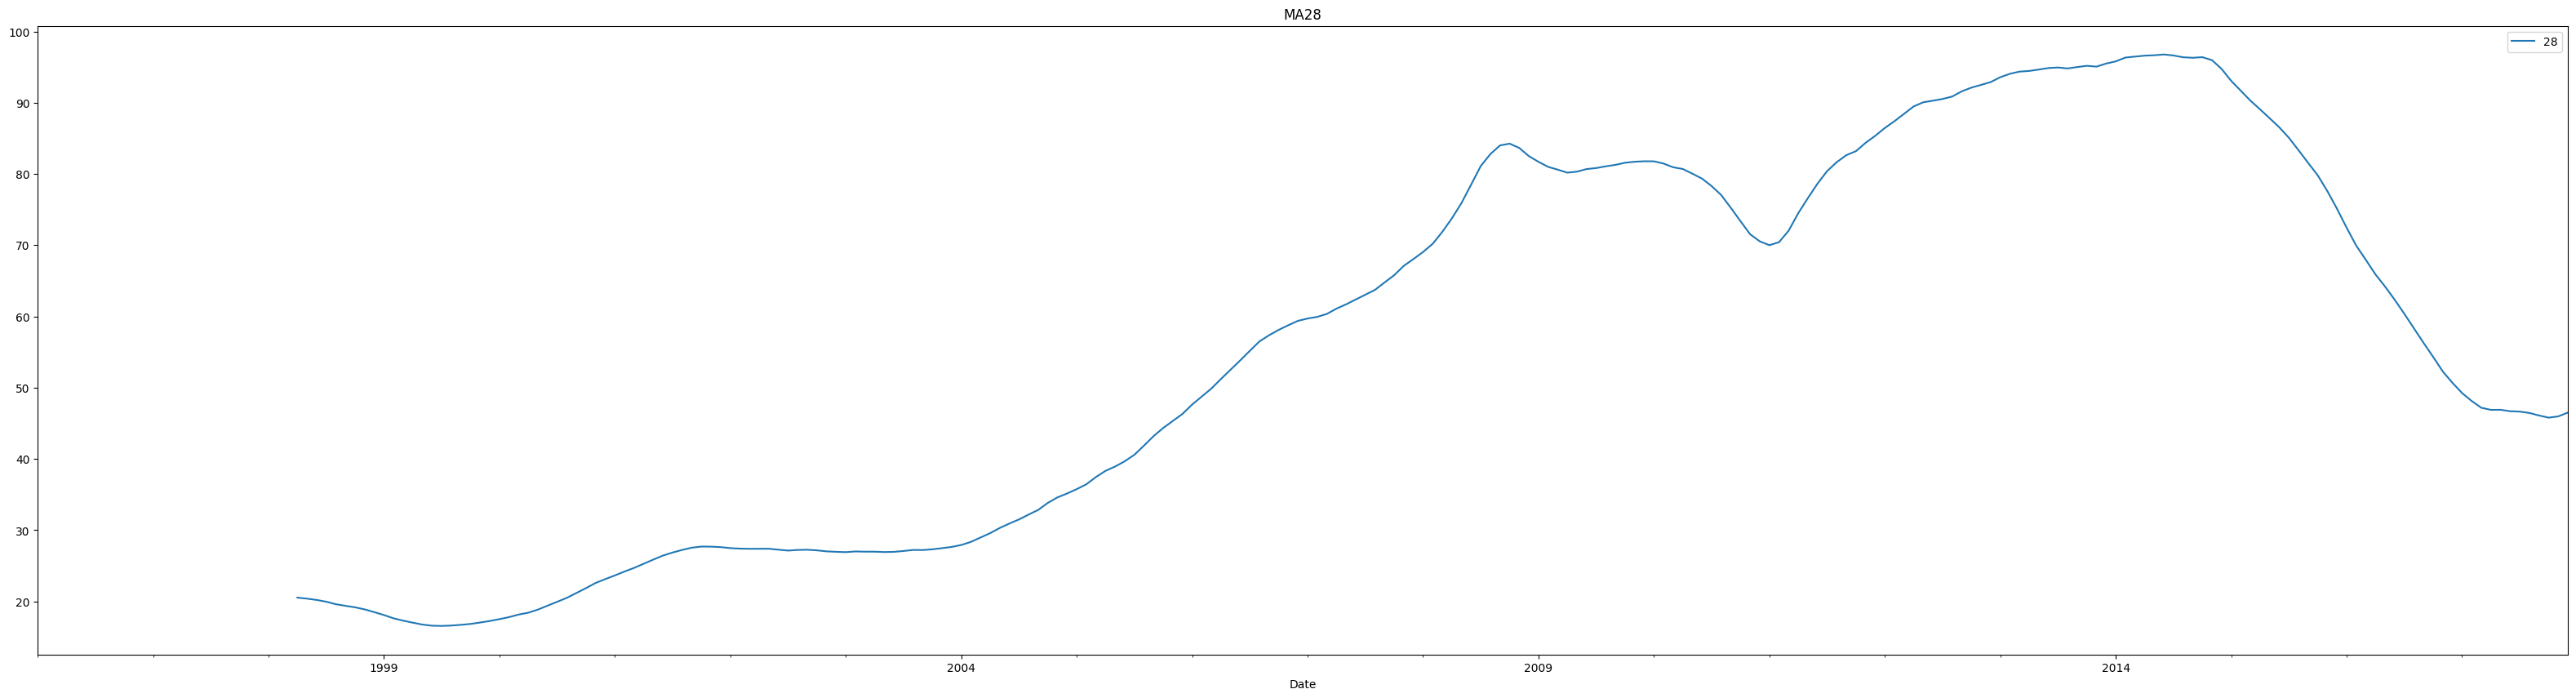

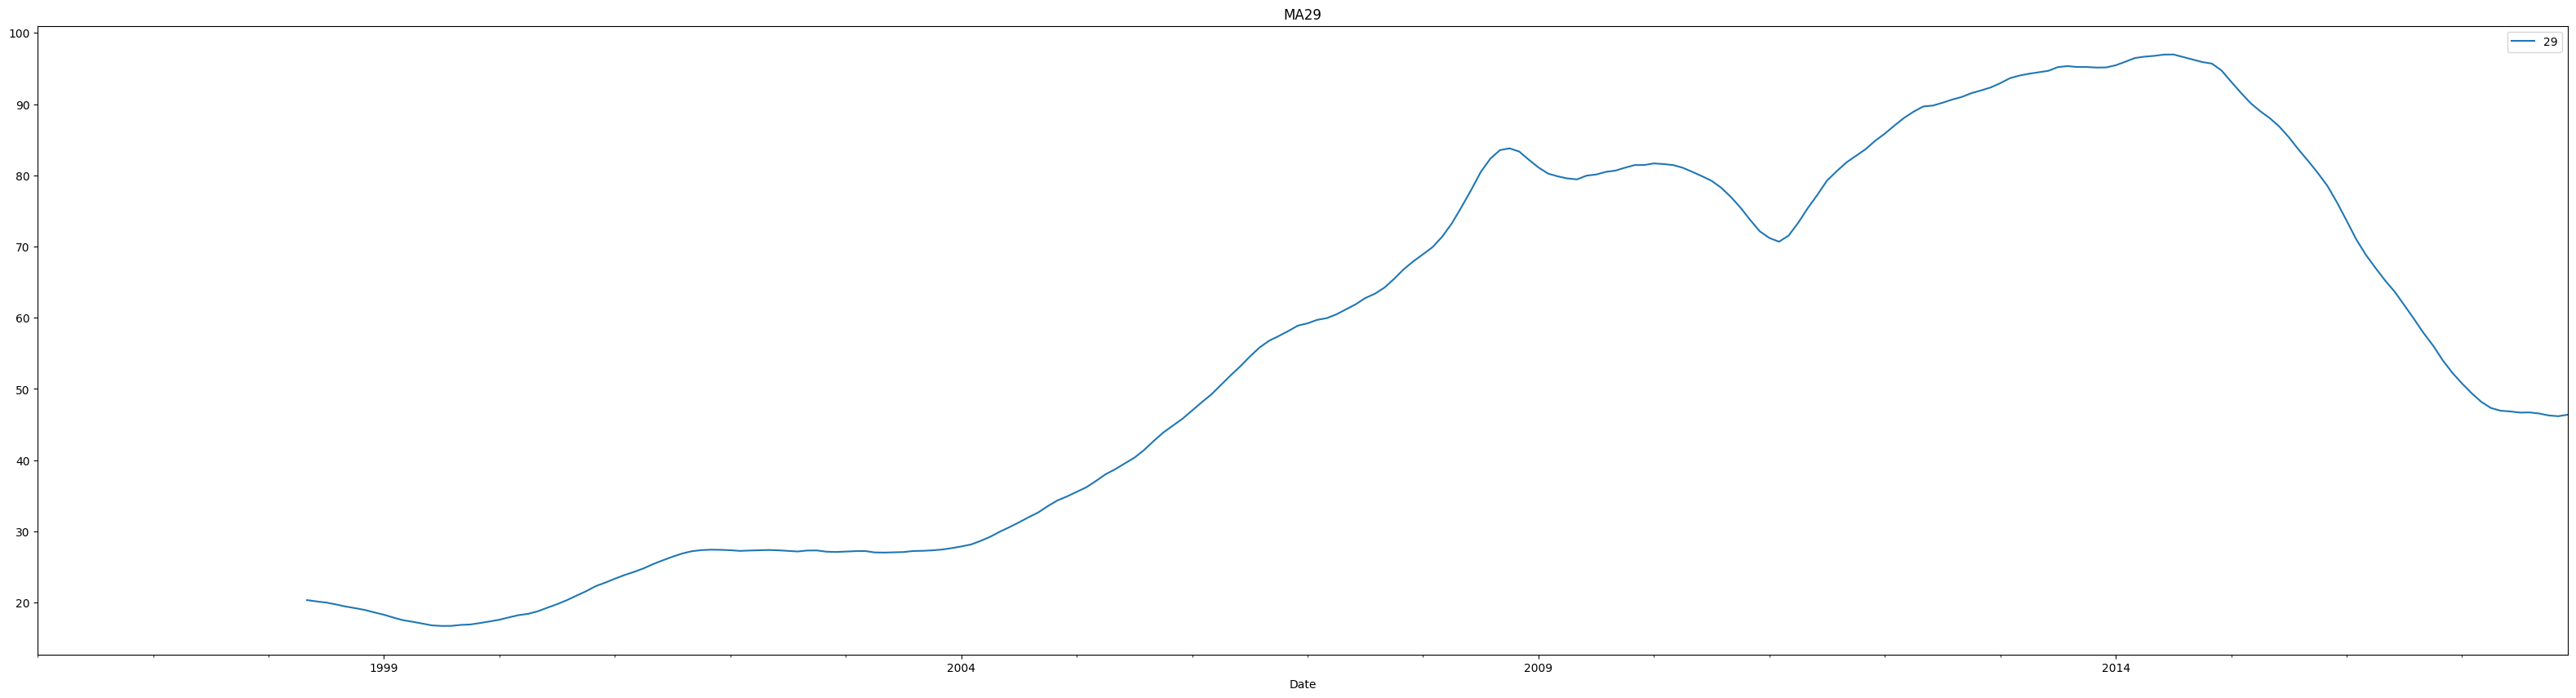

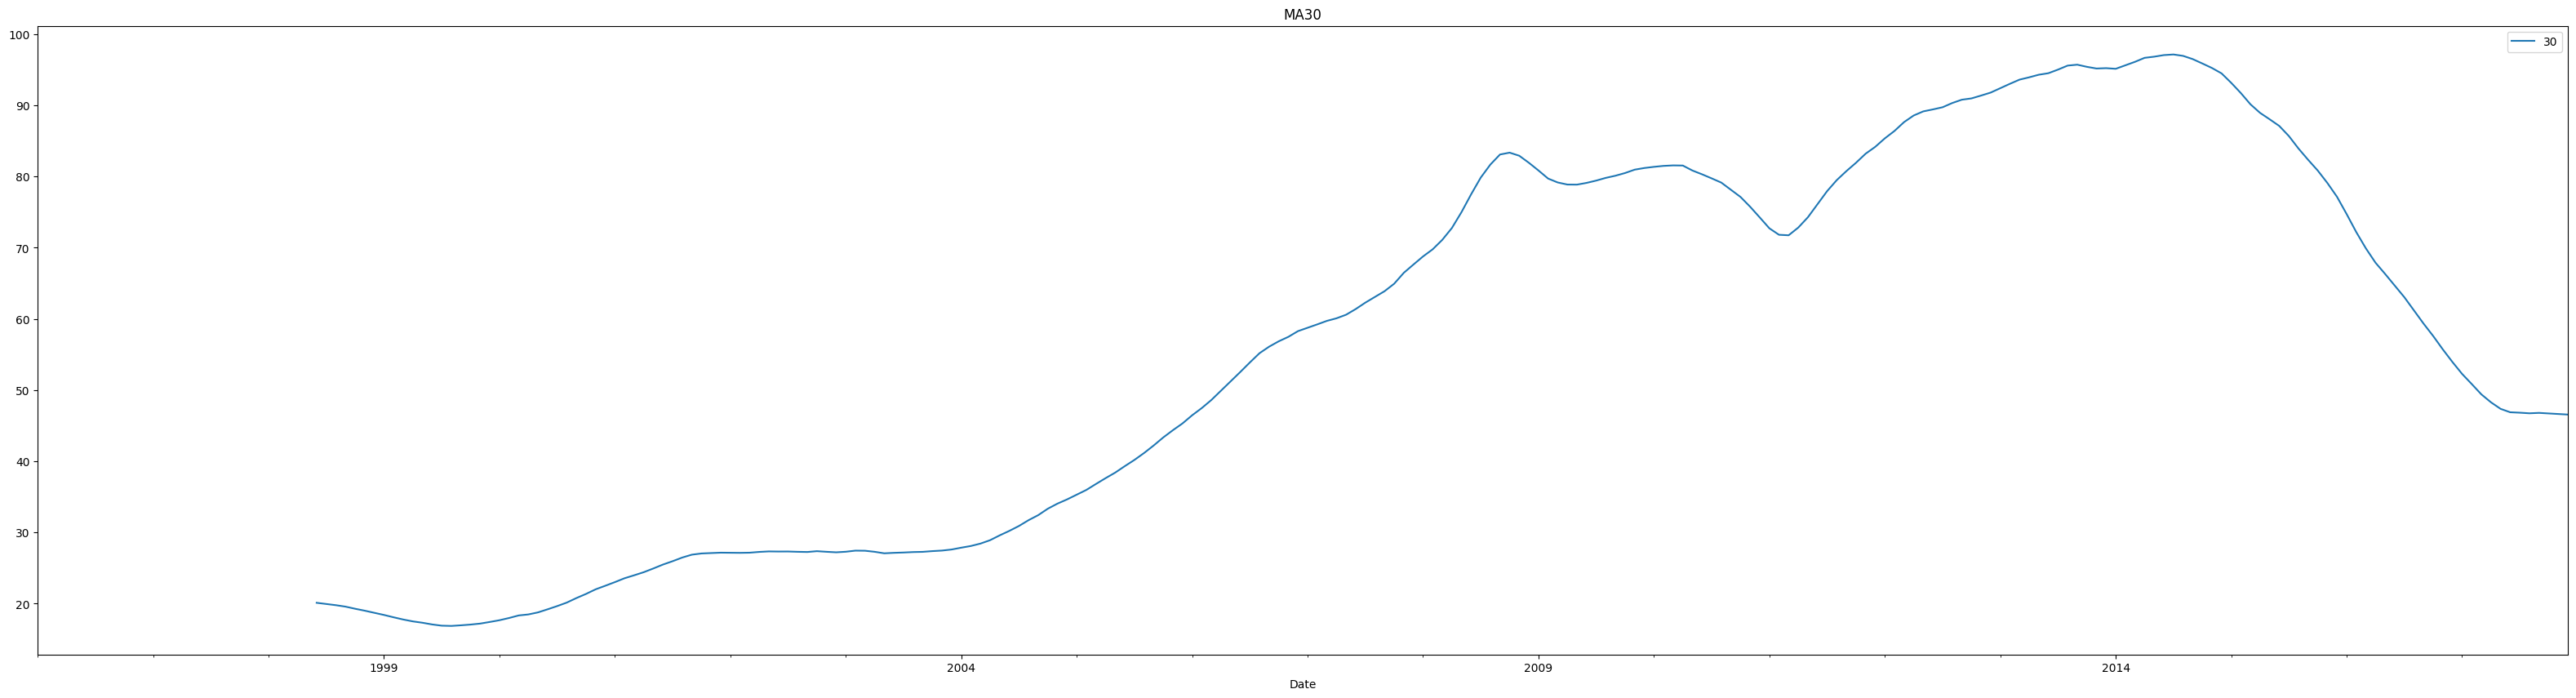

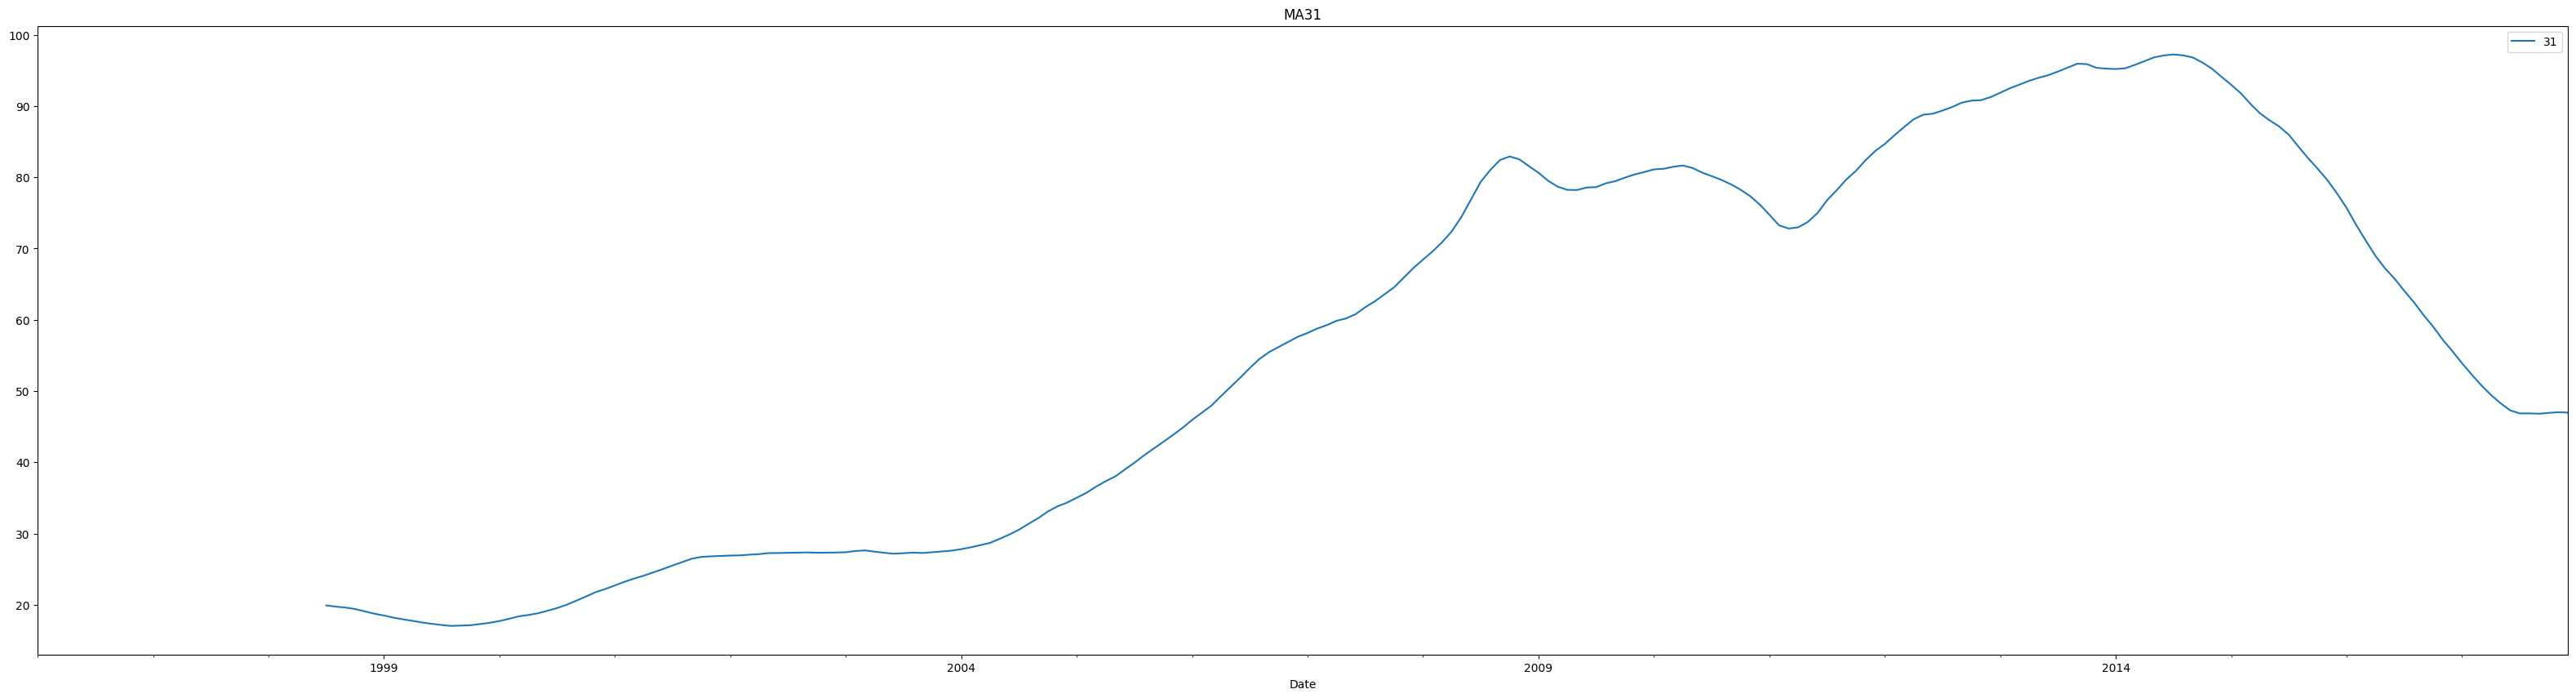

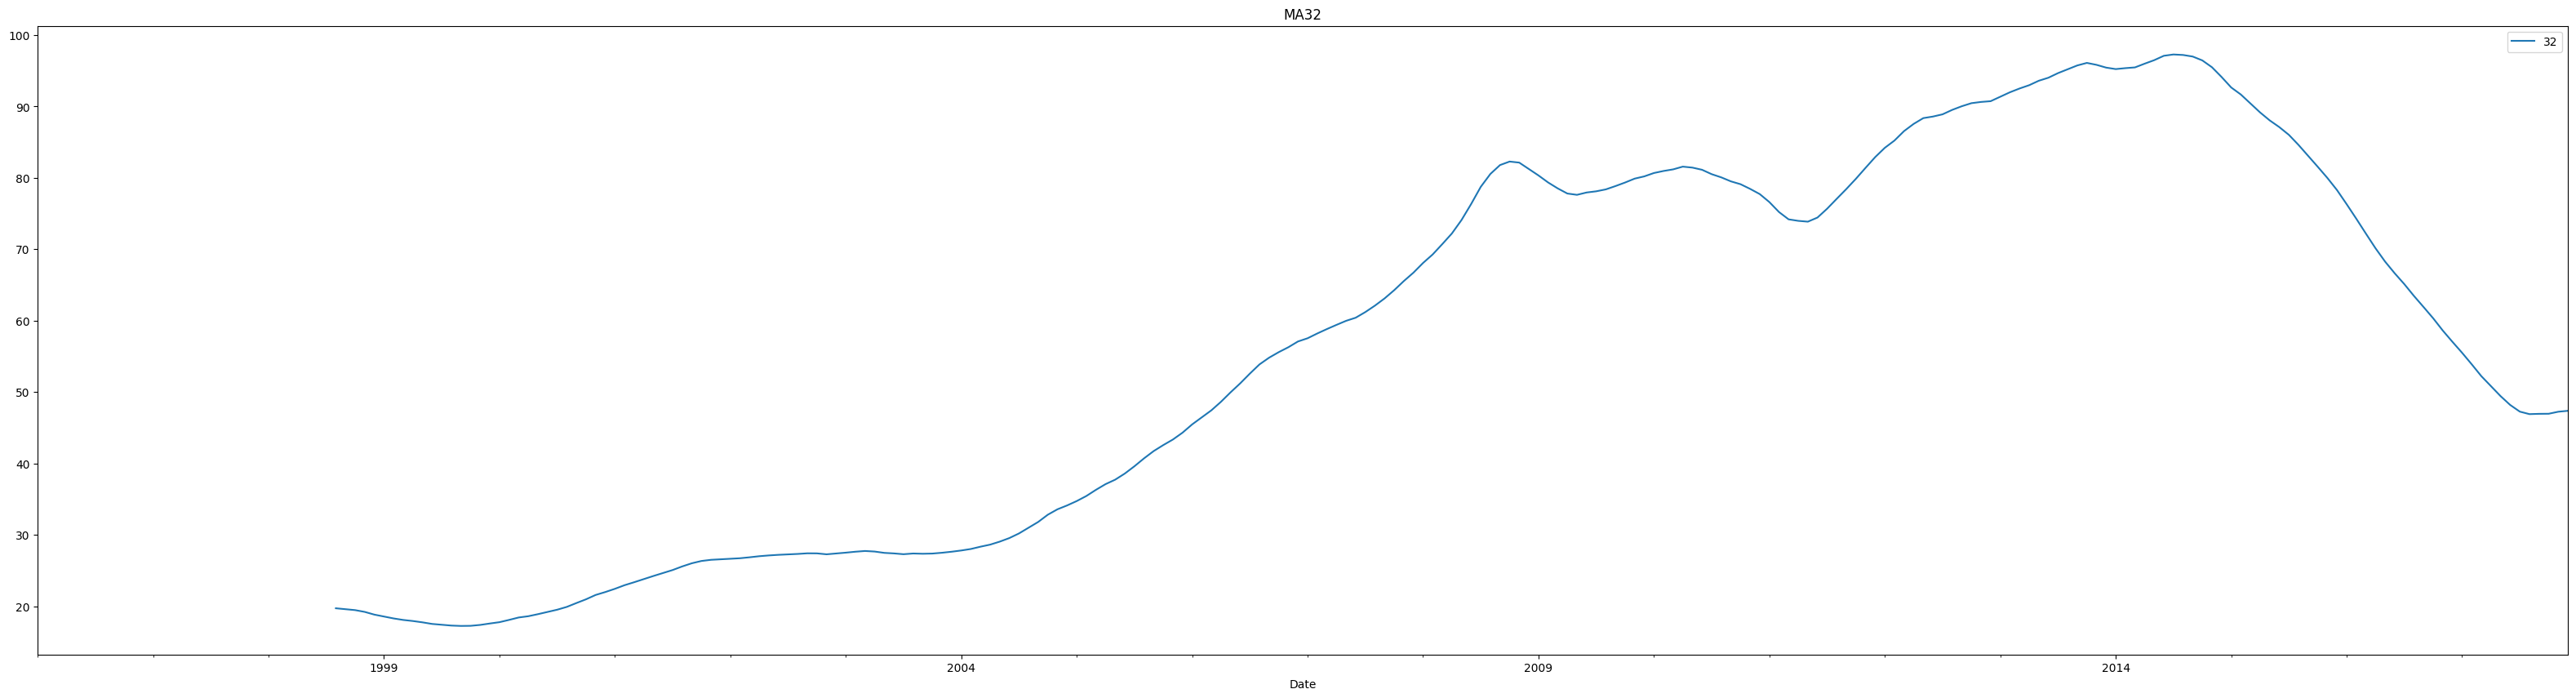

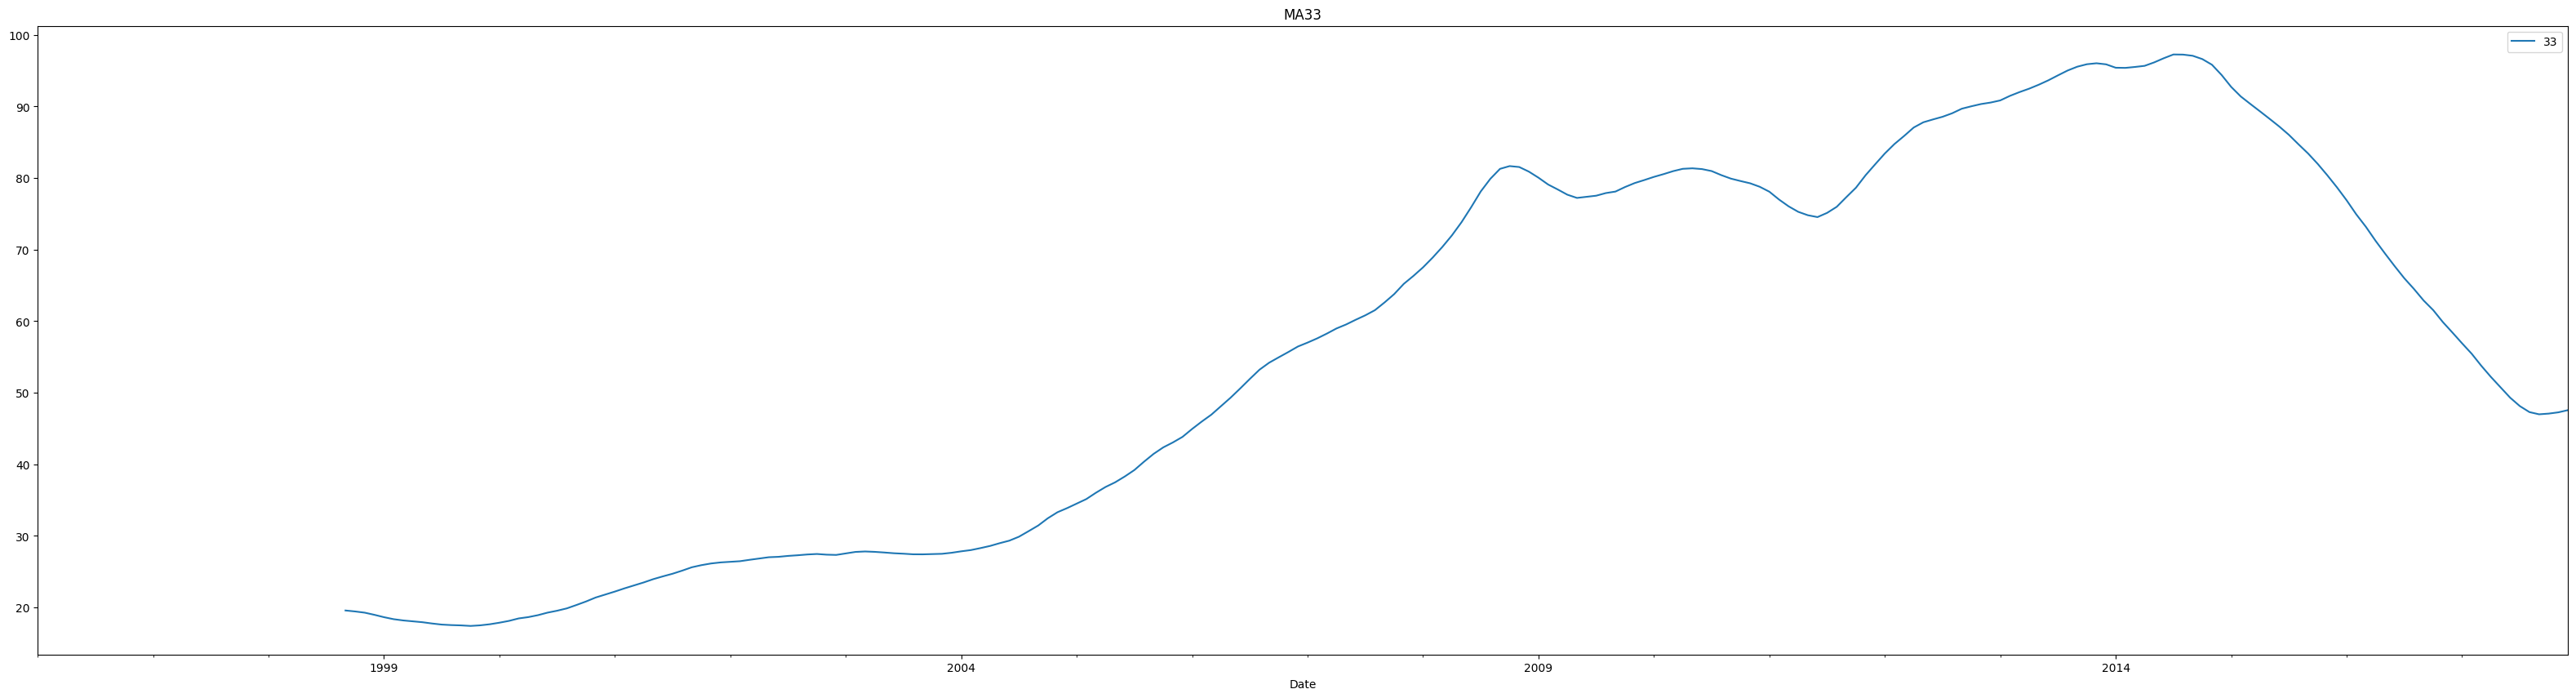

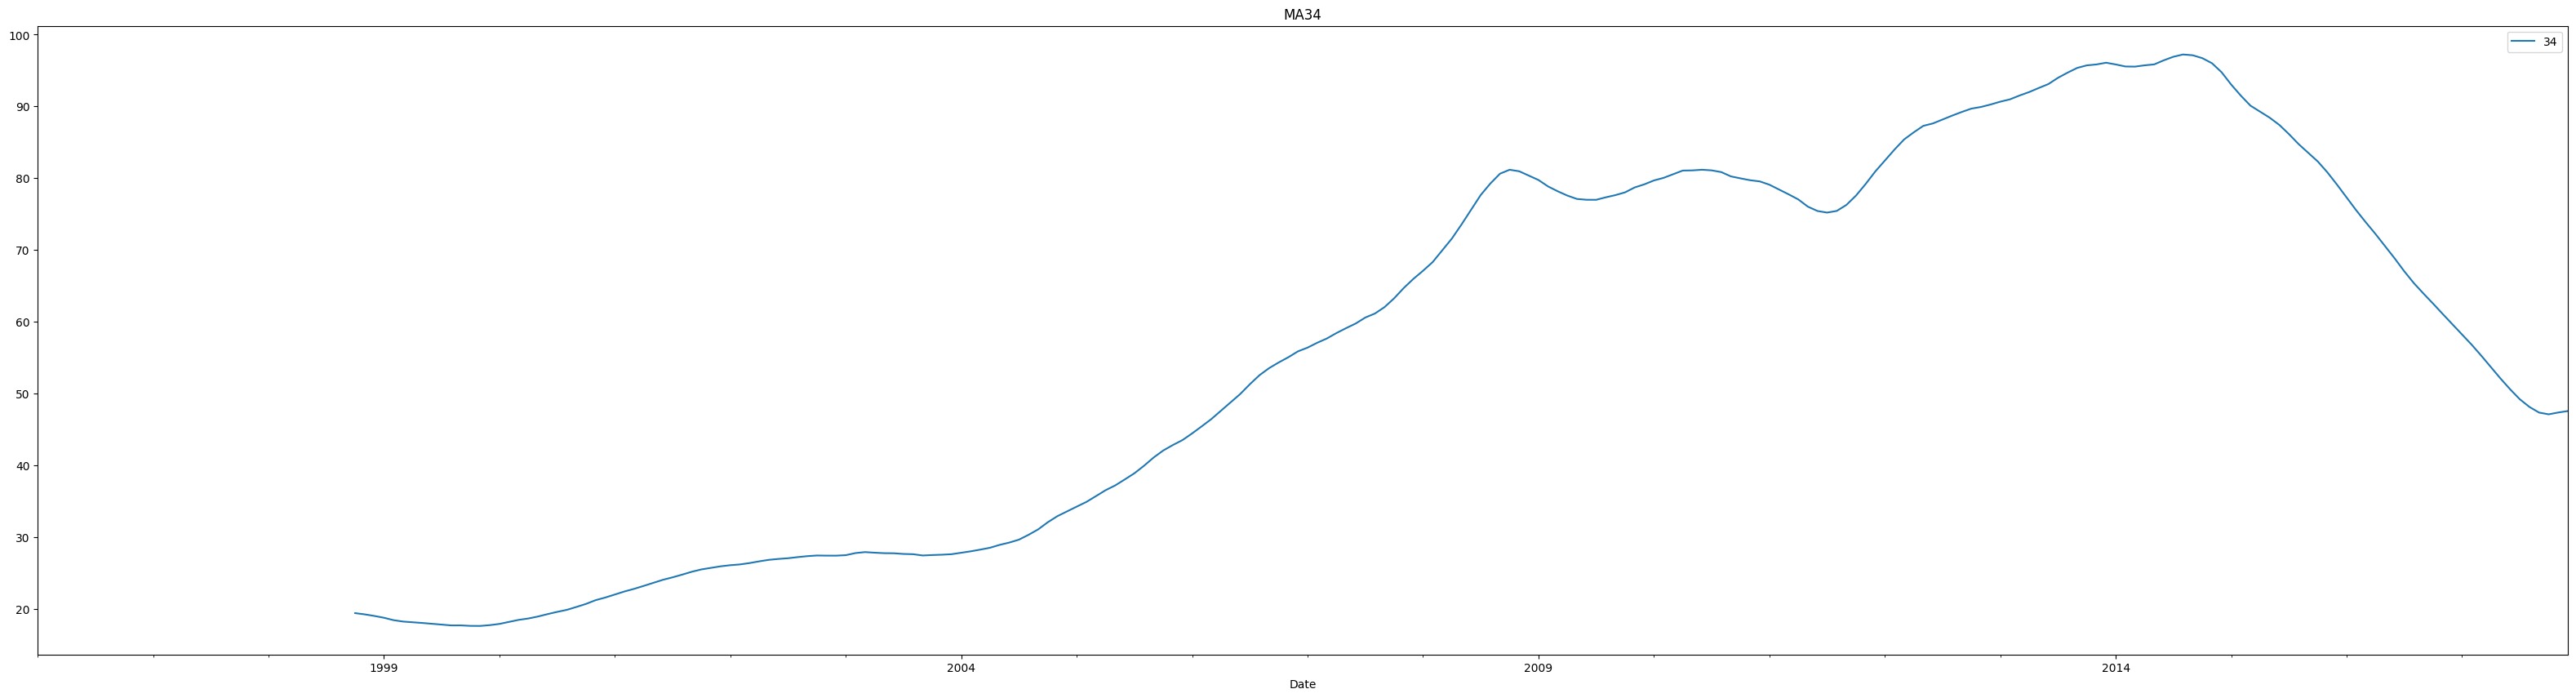

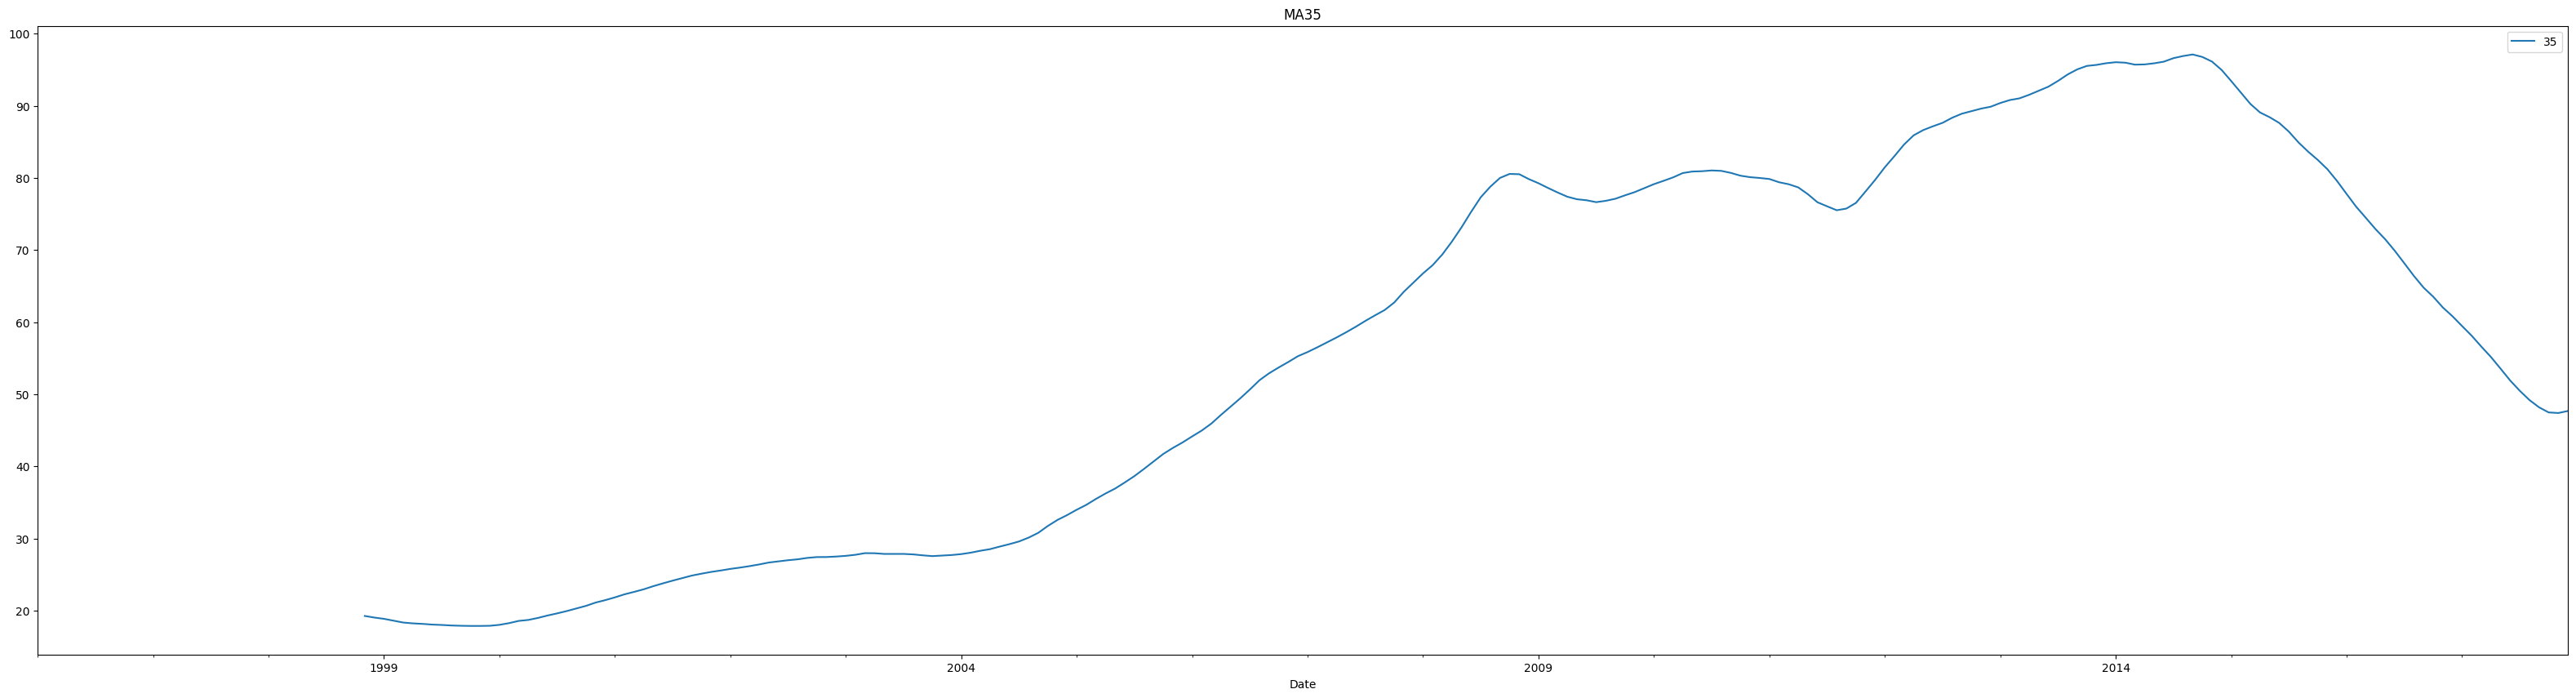

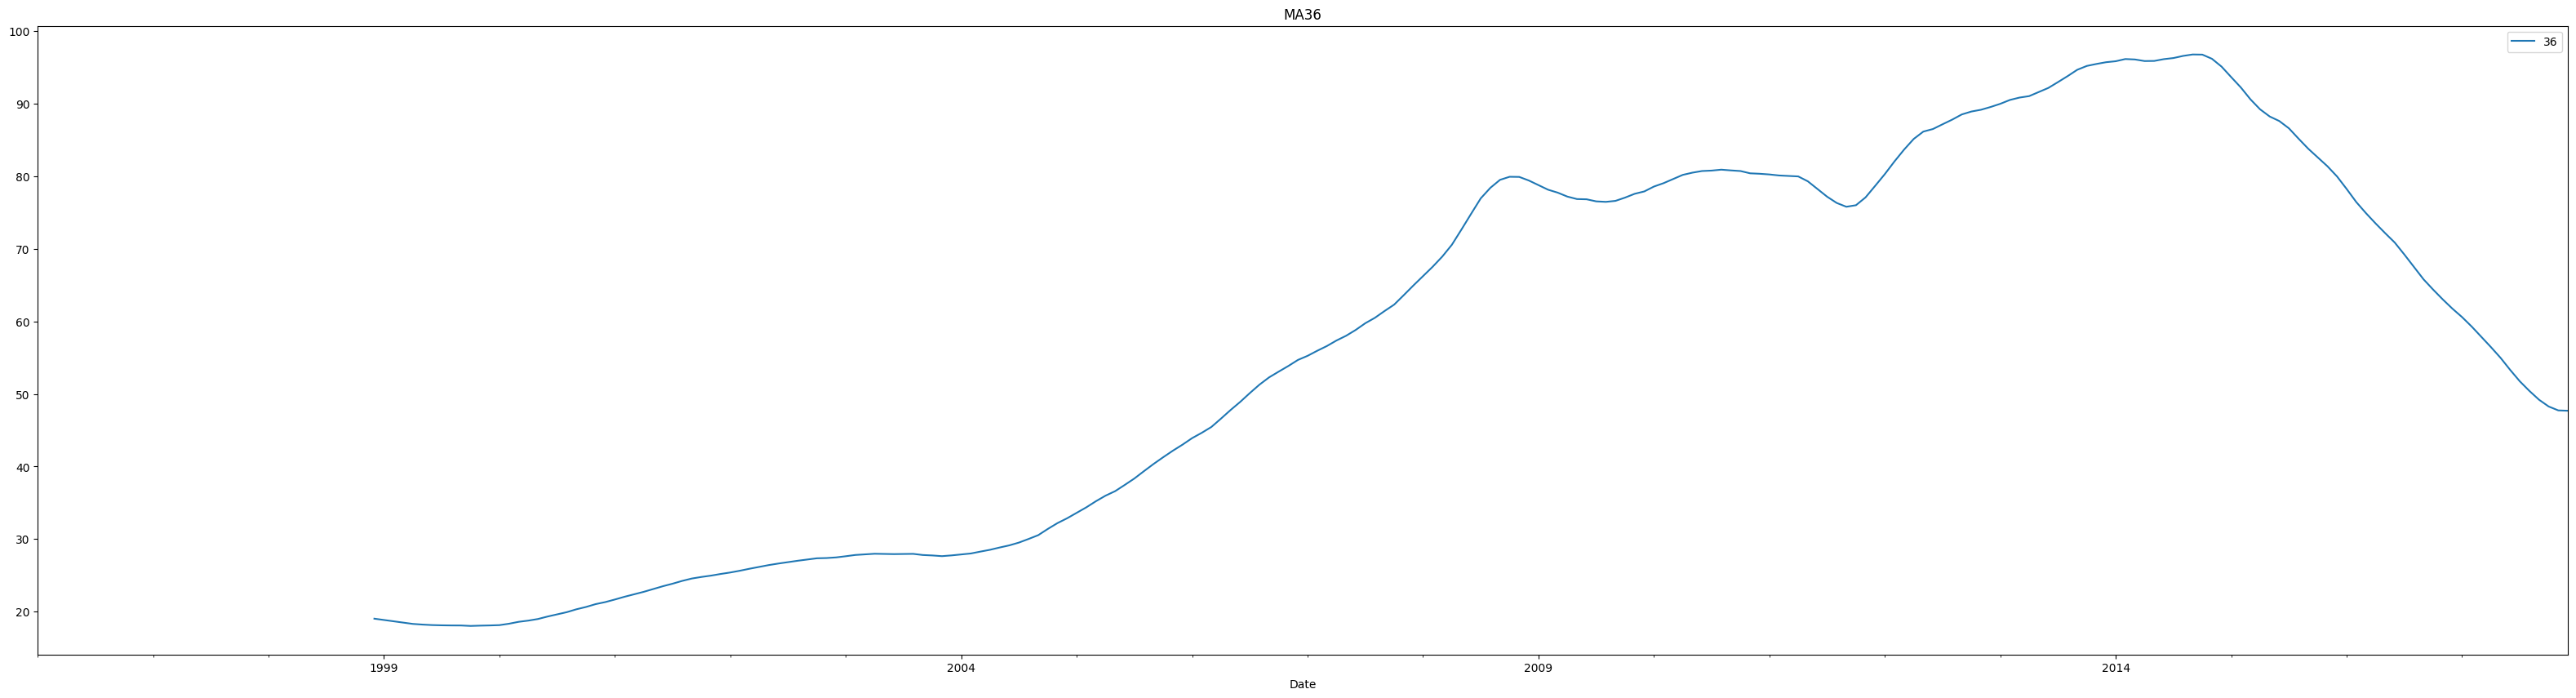

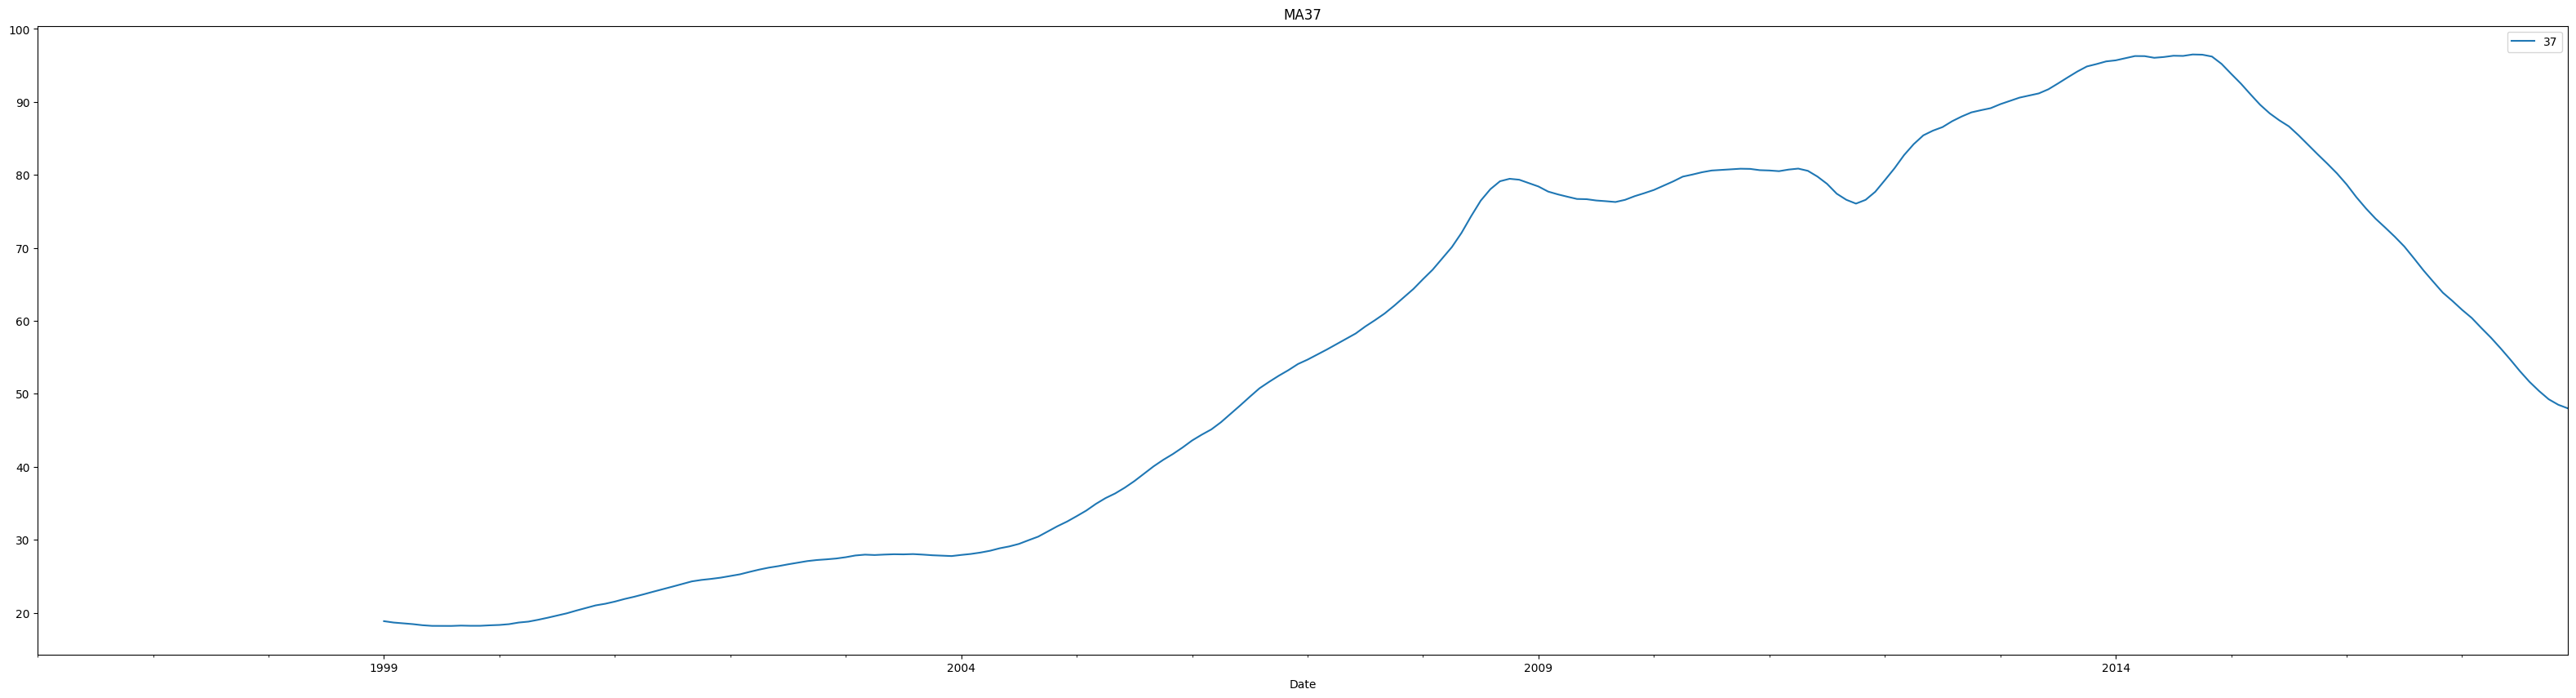

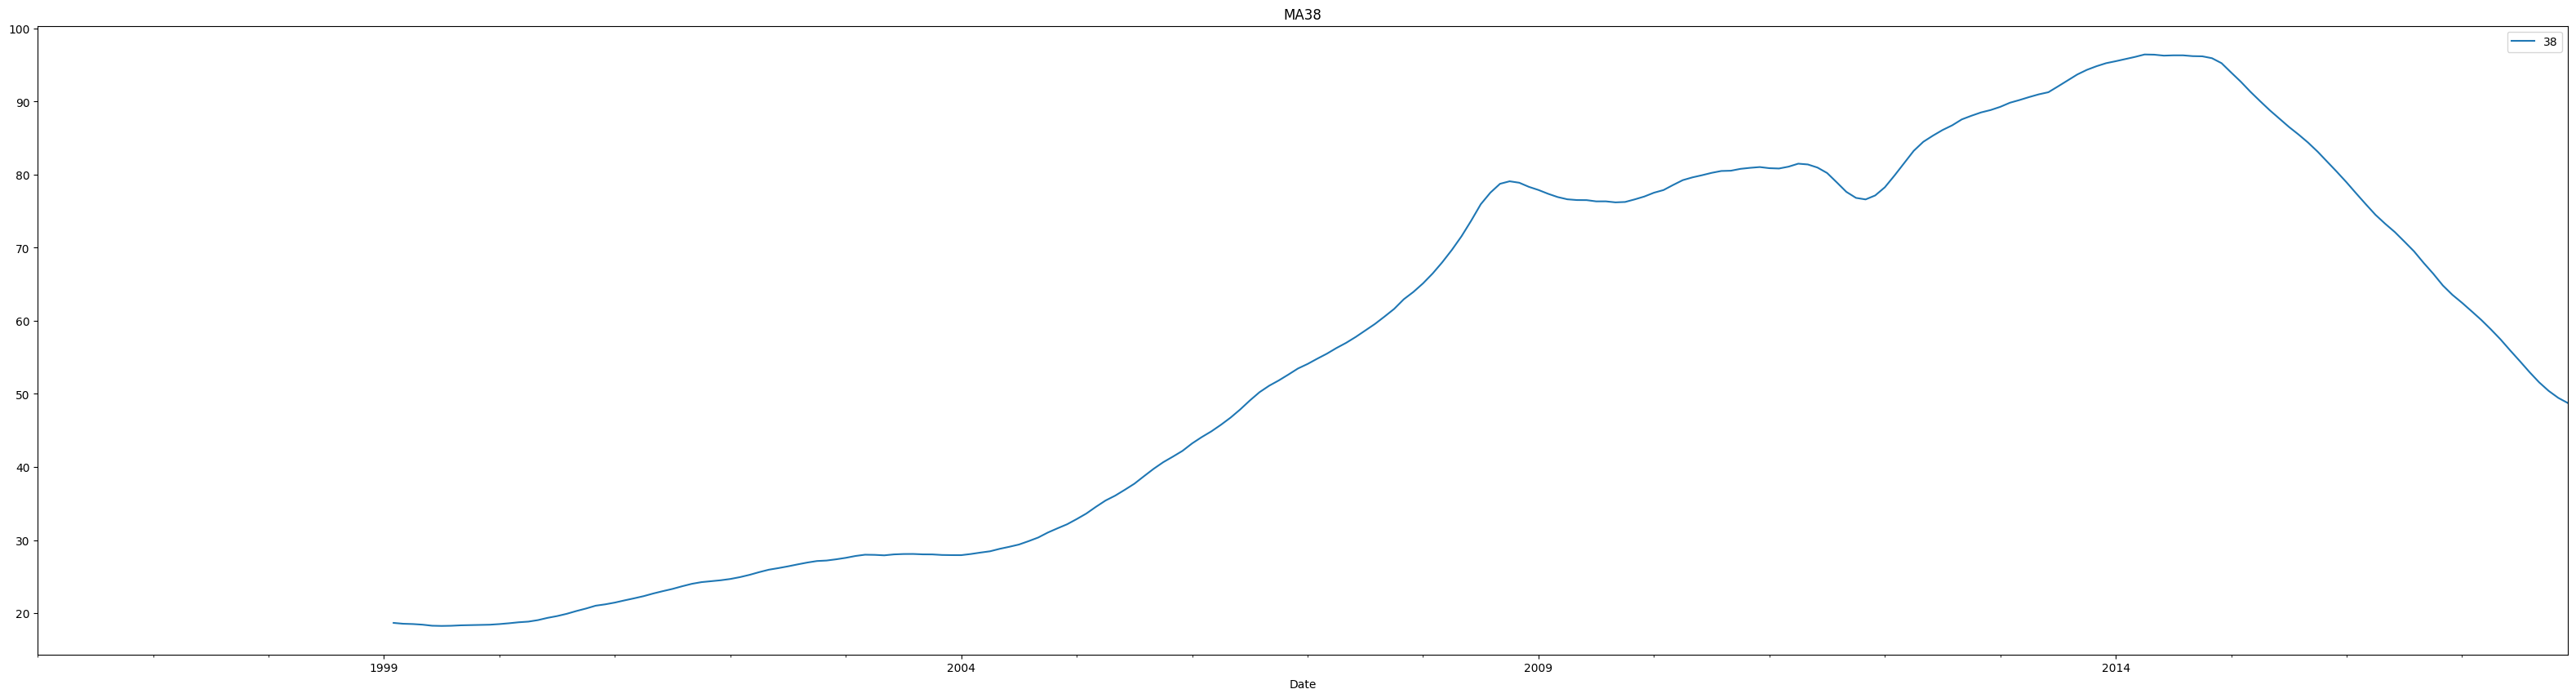

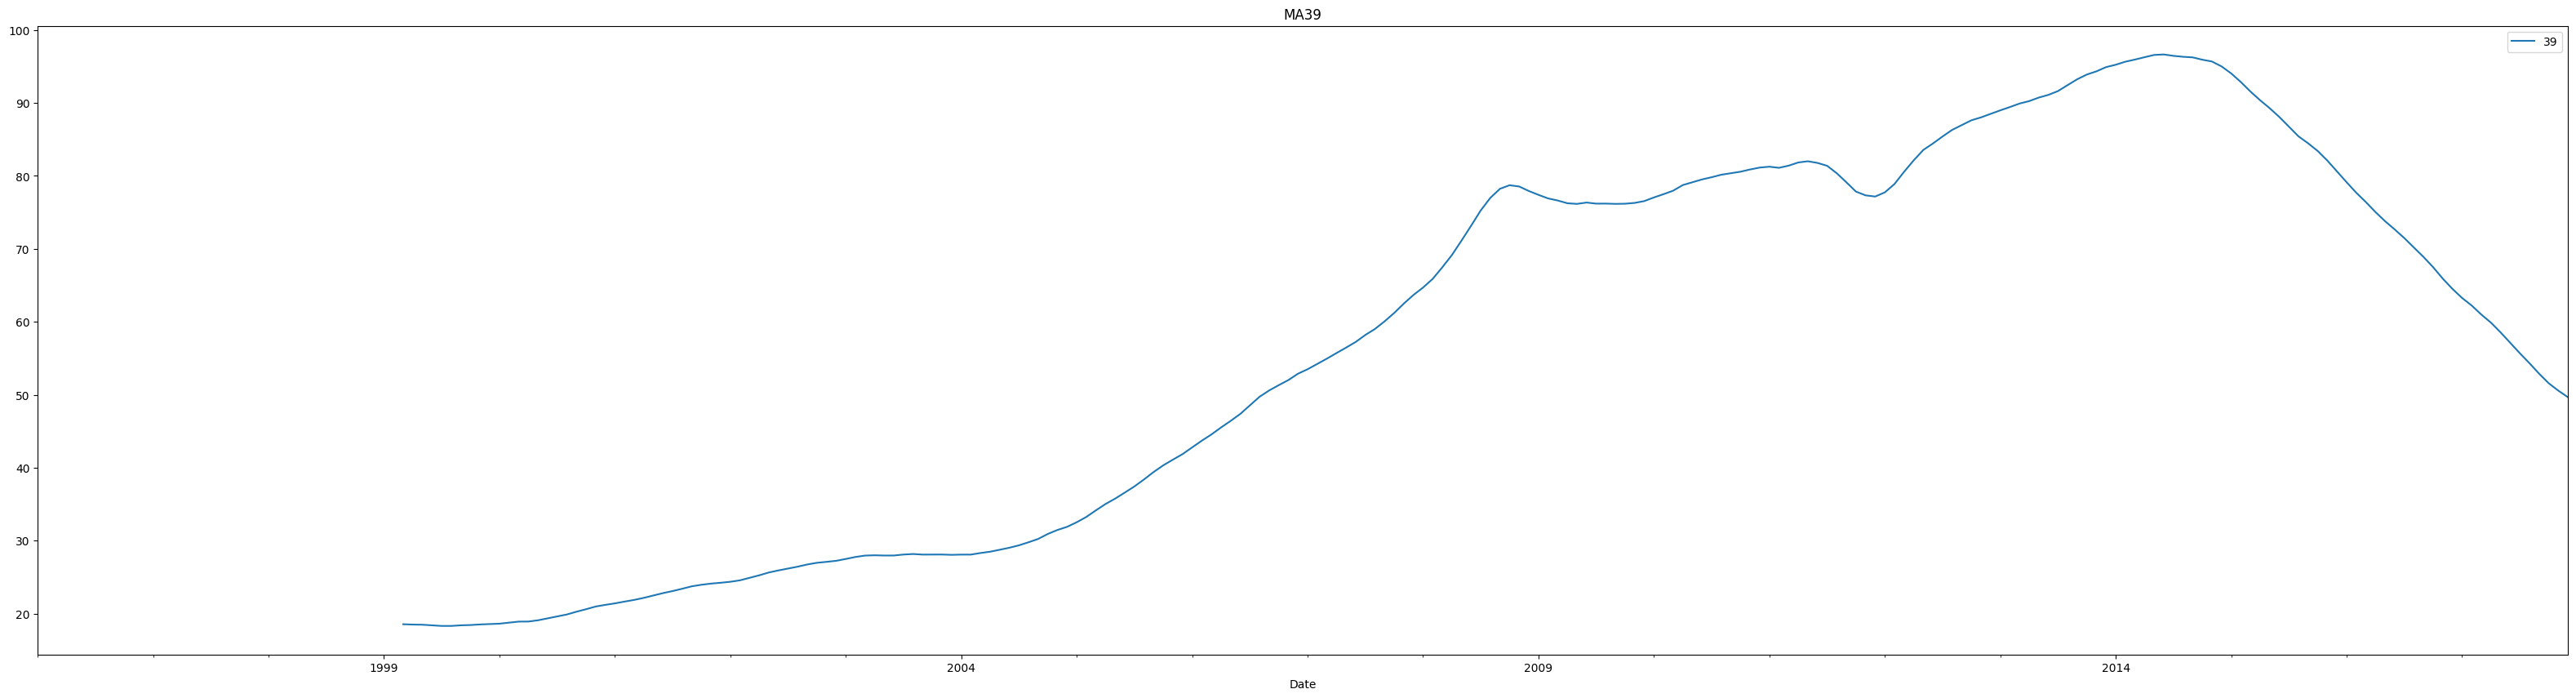

In [24]:
plt.figure(figsize=(40,10))
df_visu.Price.plot(label="org")
for i in range(2,40):
    plt.figure(figsize=(40,10))
    df_visu["Price"].rolling(i).mean().plot(label=str(i))
    plt.title("MA"+str(i))
    plt.legend(loc='best')
    plt.show()

from above visualization MA28 i.e period 28 graph is smoother as compared to other

### Time series decomposition plot
         It is use for finding proper Trends,Seasonality of Target column 

<Figure size 2400x1000 with 0 Axes>

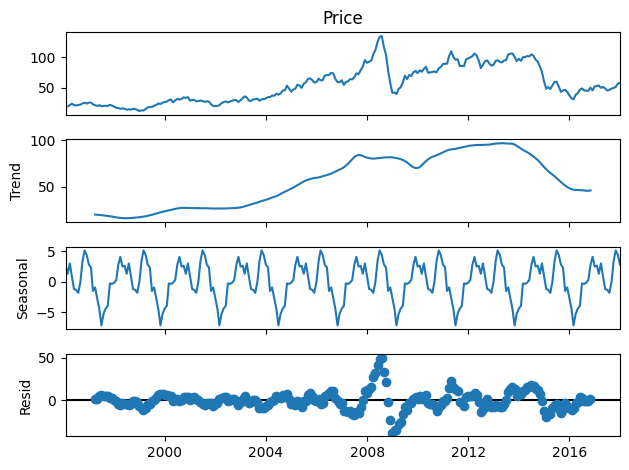

<Figure size 2400x1000 with 0 Axes>

In [25]:
plt.figure(figsize=(24,10))
decompose_ts_add = seasonal_decompose(df_visu.Price,period=28)     # with MA28
decompose_ts_add.plot()
plt.figure(figsize=(24,10))
plt.show()

It shows Trend is Polynomial and Sesonality is Additive

In [26]:
df_visu.reset_index('Date',inplace=True)

In [27]:
df_visu['Year'] = pd.to_datetime(df_visu['Date']).dt.strftime("%Y")
df_visu['Month'] = pd.to_datetime(df_visu['Date']).dt.strftime('%b')
#data['Day'] = pd.to_datetime(data['Date']).dt.strftime("%d")
df_visu.head()

Date      Price  Year Month
0 1996-01-31  18.933214  1996   Jan
1 1996-02-29  18.673929  1996   Feb
2 1996-03-31  21.047500  1996   Mar
3 1996-04-30  23.390714  1996   Apr
4 1996-05-31  21.185000  1996   May

Text(0, 0.5, 'Price')

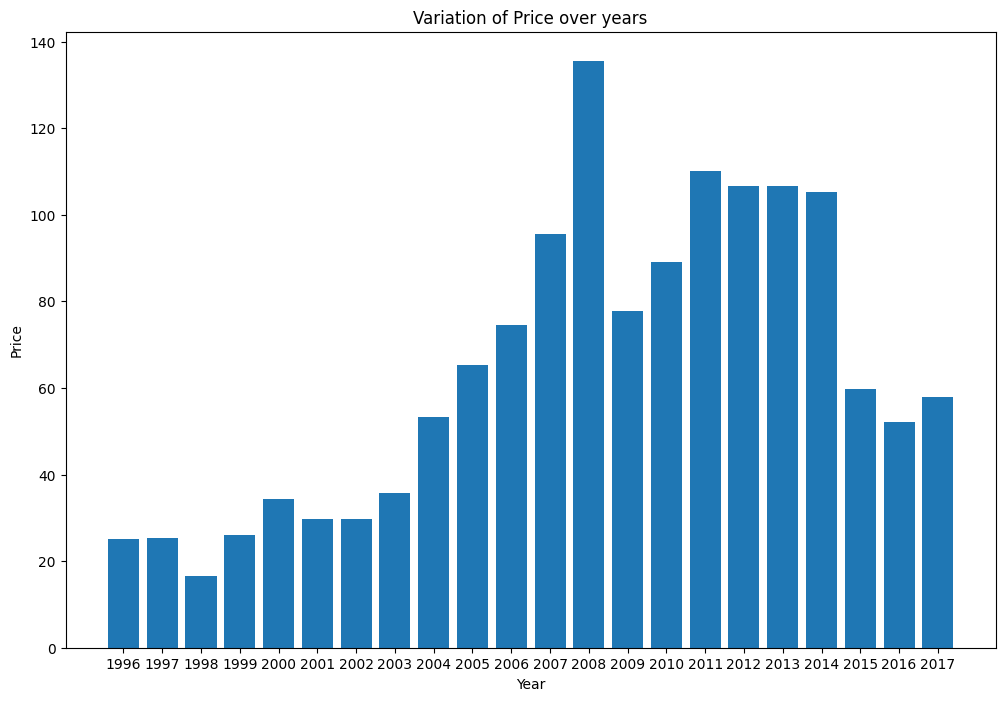

In [28]:
plt.figure(figsize=(12,8))
x=df_visu['Year']
y=df_visu['Price']
plt.bar(x,y)
plt.title('Variation of Price over years')
plt.xlabel('Year')
plt.ylabel('Price')

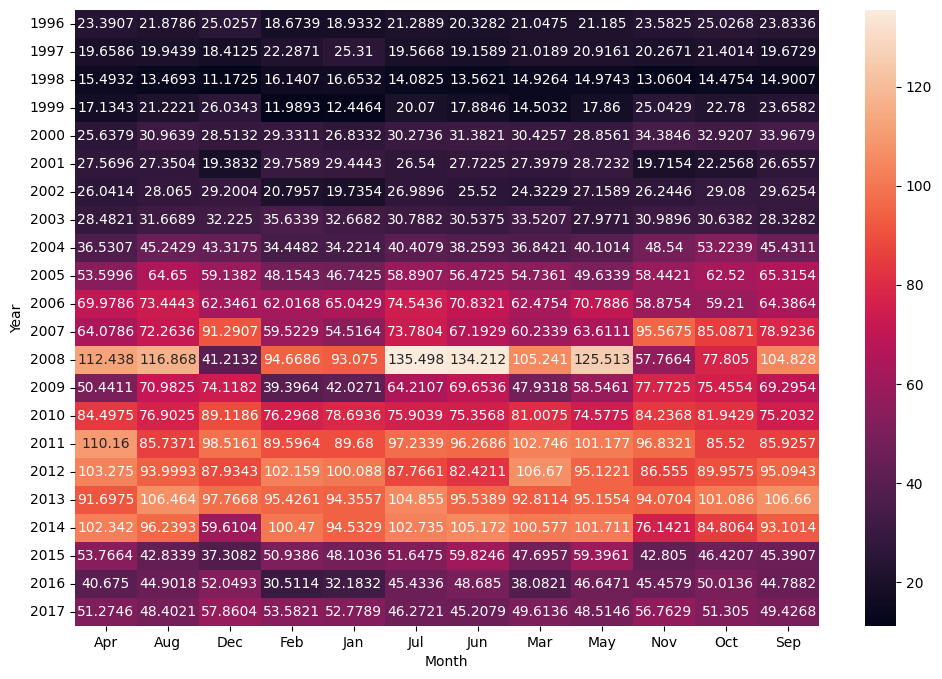

In [29]:
plt.figure(figsize=(12,8))
heatmap_y_month=pd.pivot_table(data=df_visu,values="Price",index='Year',columns="Month",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt='g')
plt.show()

from above heatmap it show that Price of oil were very high in year 2008 in June-July month.And lowest price was in year 1998 in month of December

## Checking stationarity on original treated data
               Now we will check whether the data is stationary or not. For this, we will perform a test called the Dickey-Fuller test. In the field of statistics, the Dickey-Fuller test (ADF) is used to test the null hypothesis, i.e. to check if a unit root is present in a sample of a time-series data. The alternative hypothesis is considered to be different on the version we use but is usually considered stationarity or trend-stationarity.

               Basically, we are trying to decide whether to accept the Null Hypothesis or go with the Alternative Hypothesis (that the time series has no unit root and is stationary).

               We end up deciding this based on the return of the p-value.

               A small p-value which is considered below 0.05 indicates strong evidence against the null hypothesis, thereby we reject the null hypothesis.

               A large p-value which is considered above 0.05 indicates weak or no evidence against the null hypothesis, thereby we fail to reject the null hypothesis.

               Let’s run the test:

1.Duckey fuller

In [106]:
def ad_test(dataset):
    dftest = adfuller(dataset,autolag="AIC")
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ",dftest[1])
    print("3. No of Lags : ",dftest[2])
    print("4. Num of Observations Used for ADF Regression and Critical Value Calculation : ",dftest[3])
    print("5. Critical Value : ")
    for key,val in dftest[4].items():
        print("\t",key, ":",val)

In [31]:
data

Date  Price  Year  Treated_Price
0    1996-01-01  19.55  1996          19.55
1    1996-01-02  19.81  1996          19.81
2    1996-01-03  19.89  1996          19.89
3    1996-01-04  19.91  1996          19.91
4    1996-01-05  20.26  1996          20.26
...         ...    ...   ...            ...
7387 2017-12-24  58.47  2017          58.47
7388 2017-12-25  58.59  2017          58.59
7389 2017-12-26  59.97  2017          59.97
7390 2017-12-27  59.64  2017          59.64
7391 2017-12-28  59.84  2017          59.84

[7392 rows x 4 columns]

In [32]:
 ad_test(data['Treated_Price'])

1. ADF :  -2.0692496053034706
2. P-Value :  0.2570578583570277
3. No of Lags :  36
4. Num of Observations Used for ADF Regression and Critical Value Calculation :  7355
5. Critical Value : 
	 1% : -3.431239406352867
	 5% : -2.861933049137047
	 10% : -2.5669792157603077


the p-value is greater than 0.05 so this data is non-stationary

## Converting Non-Stationary Data into Stationary Data
        Now it is clear that the data is non-stationary so we need to apply differencing to make our data stationary.
        Now let us do our first difference.

1.Differencing

In [33]:
# Apply the first difference
data['Stationary_Price'] = data['Treated_Price'].diff()

# Drop the first row since differencing introduces NaN value
data.dropna(inplace=True)

# Perform the ADF test on the stationary data
ad_test(data['Stationary_Price'])

1. ADF :  -12.536875577174591
2. P-Value :  2.361077076774596e-23
3. No of Lags :  36
4. Num of Observations Used for ADF Regression and Critical Value Calculation :  7354
5. Critical Value : 
	 1% : -3.4312395273369702
	 5% : -2.8619331025947052
	 10% : -2.566979244216616


In [34]:
data.head()

Date  Price  Year  Treated_Price  Stationary_Price
1 1996-01-02  19.81  1996          19.81              0.26
2 1996-01-03  19.89  1996          19.89              0.08
3 1996-01-04  19.91  1996          19.91              0.02
4 1996-01-05  20.26  1996          20.26              0.35
5 1996-01-06  20.26  1996          20.26              0.00

In [35]:
#data['first_diff']=data['Treated_Price']-data['Treated_Price'].shift(1)
#data.head()

In [36]:
#ad_test(data['first_diff'].dropna())

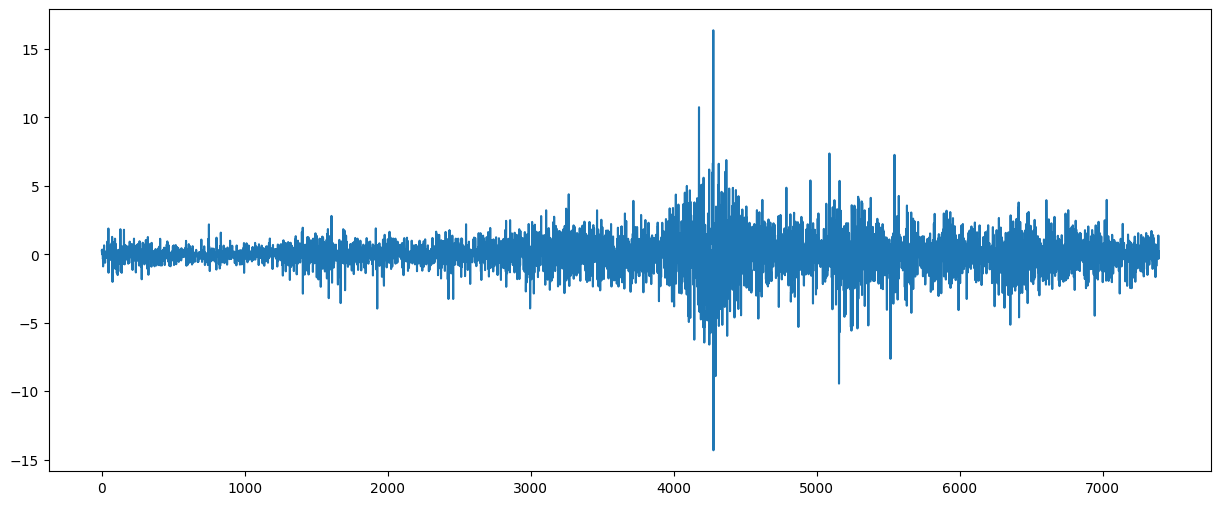

In [37]:
data['Stationary_Price'].plot(figsize=(15, 6))
plt.show()

Average Price is around 0,so Data is now Stationary

## Feature Engineering

In [38]:
data.head()

Date  Price  Year  Treated_Price  Stationary_Price
1 1996-01-02  19.81  1996          19.81              0.26
2 1996-01-03  19.89  1996          19.89              0.08
3 1996-01-04  19.91  1996          19.91              0.02
4 1996-01-05  20.26  1996          20.26              0.35
5 1996-01-06  20.26  1996          20.26              0.00

In [39]:
#data.reset_index('Date',inplace=True)
#data.tail()

In [40]:
#data['Year'] = pd.to_datetime(data['Date']).dt.strftime("%Y")
data['Month'] = pd.to_datetime(data['Date']).dt.strftime('%b')
data['Day'] = pd.to_datetime(data['Date']).dt.strftime("%d")

data.head()

Date  Price  Year  Treated_Price  Stationary_Price Month Day
1 1996-01-02  19.81  1996          19.81              0.26   Jan  02
2 1996-01-03  19.89  1996          19.89              0.08   Jan  03
3 1996-01-04  19.91  1996          19.91              0.02   Jan  04
4 1996-01-05  20.26  1996          20.26              0.35   Jan  05
5 1996-01-06  20.26  1996          20.26              0.00   Jan  06

In [41]:
#OHE
month_dummies = pd.DataFrame(pd.get_dummies(data['Month']))
data = pd.concat([data,month_dummies],axis = 1)
data.head()

Date  Price  Year  Treated_Price  Stationary_Price Month Day    Apr  \
1 1996-01-02  19.81  1996          19.81              0.26   Jan  02  False   
2 1996-01-03  19.89  1996          19.89              0.08   Jan  03  False   
3 1996-01-04  19.91  1996          19.91              0.02   Jan  04  False   
4 1996-01-05  20.26  1996          20.26              0.35   Jan  05  False   
5 1996-01-06  20.26  1996          20.26              0.00   Jan  06  False   

     Aug    Dec    Feb   Jan    Jul    Jun    Mar    May    Nov    Oct    Sep  
1  False  False  False  True  False  False  False  False  False  False  False  
2  False  False  False  True  False  False  False  False  False  False  False  
3  False  False  False  True  False  False  False  False  False  False  False  
4  False  False  False  True  False  False  False  False  False  False  False  
5  False  False  False  True  False  False  False  False  False  False  False

In [42]:
# Add the 't' column with values from 0 to 7391
data["t"] = np.arange(7391)

# Add the 't_squared' column with values calculated from 't'
data["t_squared"] = data["t"] * data["t"]

# Add the 'log_Price' column with logarithm of 'Price'
data["log_Price"] = np.log(data["Price"])

# Display the first few rows of the updated DataFrame
data.shape

(7391, 22)

In [43]:
data=data.drop(['Month','Price'],axis=1)
data=data.dropna()

In [44]:
data.tail()

Date  Year  Treated_Price  Stationary_Price Day    Apr    Aug  \
7387 2017-12-24  2017          58.47              0.00  24  False  False   
7388 2017-12-25  2017          58.59              0.12  25  False  False   
7389 2017-12-26  2017          59.97              1.38  26  False  False   
7390 2017-12-27  2017          59.64             -0.33  27  False  False   
7391 2017-12-28  2017          59.84              0.20  28  False  False   

       Dec    Feb    Jan    Jul    Jun    Mar    May    Nov    Oct    Sep  \
7387  True  False  False  False  False  False  False  False  False  False   
7388  True  False  False  False  False  False  False  False  False  False   
7389  True  False  False  False  False  False  False  False  False  False   
7390  True  False  False  False  False  False  False  False  False  False   
7391  True  False  False  False  False  False  False  False  False  False   

         t  t_squared  log_Price  
7387  7386   54552996   4.068514  
7388  7387   54567769   4.070564  
7389  7388   54582544   4.093844  
7390  7389   54597321   4.088326  
7391  7390   54612100   4.091674

##  Train - Test Split

In [45]:
train_size = int(len(data) * 0.80)  # 80% for training, 25% for testing
train = data[:train_size]
test = data[train_size:]

In [46]:
test.shape

(1479, 20)

In [47]:
train.shape

(5912, 20)

In [48]:
# Segreate the Train & Test Data
#train=data.head(5913)
#test=data.tail(1478)

## Model Building
           Their are two forcasting models
               1.Model based
               2.Data Driven models

1.Model Based

In [49]:
train.head()

Date  Year  Treated_Price  Stationary_Price Day    Apr    Aug    Dec  \
1 1996-01-02  1996          19.81              0.26  02  False  False  False   
2 1996-01-03  1996          19.89              0.08  03  False  False  False   
3 1996-01-04  1996          19.91              0.02  04  False  False  False   
4 1996-01-05  1996          20.26              0.35  05  False  False  False   
5 1996-01-06  1996          20.26              0.00  06  False  False  False   

     Feb   Jan    Jul    Jun    Mar    May    Nov    Oct    Sep  t  t_squared  \
1  False  True  False  False  False  False  False  False  False  0          0   
2  False  True  False  False  False  False  False  False  False  1          1   
3  False  True  False  False  False  False  False  False  False  2          4   
4  False  True  False  False  False  False  False  False  False  3          9   
5  False  True  False  False  False  False  False  False  False  4         16   

   log_Price  
1   2.986187  
2   2.990217  
3   2.991222  
4   3.008648  
5   3.008648

In [50]:
# try and test

###  Models
1.linear

2.Exponetial

3.Quadratic

4.Additive seosonality

5.Additive Quadratic

6.Multiplicative seosonality

7.Multiplicative additive

8.Simple Exponetial method

9.Holt

10.Holts winter exponential smoothing with additive

11.ARIMA

12.LSTM

13.RNN

### Linear Model

In [51]:
linear_model = smf.ols('Stationary_Price~t',data=train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test['t'])))                 # Predict on test data
rmse_linear = np.sqrt(np.mean((np.array(test['Stationary_Price'])-np.array(pred_linear))**2)) # Calculate RMSE --> test -predict_linear
print("RMSE Linear: ",rmse_linear)

RMSE Linear:  1.003286818716603


### Exponential Model
it is used for multipicative seasonality

In [52]:
Exp = smf.ols('log_Price~t',data=train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(test['Stationary_Price'])-np.array(np.exp(pred_Exp)))**2))
print("RMSE Exponential: ",rmse_Exp)

RMSE Exponential:  157.4685328517997


### Quadratic Model

In [53]:
Quad = smf.ols('Stationary_Price~t+t_squared',data=train).fit()
pred_Quad = pd.Series(Quad.predict(test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(test['Stationary_Price'])-np.array(pred_Quad))**2))
print("RMSE Quadratic: ",rmse_Quad)

RMSE Quadratic:  1.002764948450698


### Additive Seasonality Model

In [54]:
add_sea = smf.ols('Stationary_Price~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train).fit()
pred_add_sea = pd.Series(add_sea.predict(test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]))
rmse_add_sea = np.sqrt(np.mean((np.array(test['Stationary_Price'])-np.array(pred_add_sea))**2))
print("RMSE Additive seasonality: ",rmse_add_sea)

RMSE Additive seasonality:  1.0017793304949179


### Additive Seasonality Quadratic Model

In [55]:
add_sea_Quad = smf.ols('Stationary_Price~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(test['Stationary_Price'])-np.array(pred_add_sea_quad))**2))
print("RMSE Additive Seasonality Quadratic:",rmse_add_sea_quad )

RMSE Additive Seasonality Quadratic: 1.0017614073193823


### Multiplicative Seasonality Model

In [56]:
Mul_sea = smf.ols('log_Price~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(test['Stationary_Price'])-np.array(np.exp(pred_Mult_sea)))**2))
print("RMSE Multiplicative Seasonality:",rmse_Mult_sea)

RMSE Multiplicative Seasonality: 43.012213247960176


2. Data-Driven Models

In [57]:
#def mean_absolute_percentage_error(actual, predicted):
    #non_zero_indices = actual != 0
   # actual_non_zero = actual[non_zero_indices]
   # predicted_non_zero = predicted[non_zero_indices]
   # return np.mean(np.abs((actual_non_zero - predicted_non_zero) / actual_non_zero)) * 100

### Simple Exponential Method

In [58]:
# Fit a Simple Exponential Smoothing (SES) model to 'first_diff' column
ses_model = SimpleExpSmoothing(train["Stationary_Price"]).fit(smoothing_level=0.2)
# Make predictions using the SES model
pred_ses = ses_model.predict(start=test.index[0], end=test.index[-1])
# Calculate MAPE
#mape = mean_absolute_percentage_error(test['first_diff'].dropna(), pred_ses)
#print("MAPE:", mape)
# Calculate RMSE
rmse = np.sqrt(np.mean((np.array(test['Stationary_Price']) - np.array(pred_ses)) ** 2))
rmse

1.0026247354180753

### Holt method

In [59]:
# Holt method 
# Fit a Holt model to 'first_diff' column
hw_model = Holt(train["Stationary_Price"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
# Make predictions using the Holt model
pred_hw = hw_model.predict(start=test.index[0], end=test.index[-1])
# Calculate MAPE
#mape = mean_absolute_percentage_error(test['first_diff'].dropna(), pred_hw)
#print("MAPE:", mape)
# Calculate RMSE
rmse1 = np.sqrt(np.mean((np.array(test['Stationary_Price']) - np.array(pred_hw)) ** 2))
rmse1

76.50145053463136

### Holts winter exponential smoothing with additive seasonality and additive trend

In [60]:
# Fit an ExponentialSmoothing model with additive seasonality and additive trend to 'first_diff' column
hwe_model_add_add = ExponentialSmoothing(train["Stationary_Price"], seasonal="add", trend="add", seasonal_periods=23).fit()
# Make predictions using the Holt-Winters' additive model
pred_hwe_add_add = hwe_model_add_add.predict(start=test.index[0], end=test.index[-1])
# Calculate MAPE
#mape = mean_absolute_percentage_error(test['first_diff'].dropna(), pred_hwe_add_add)
#print("MAPE:", mape)
# Calculate RMSE
rmse2 = np.sqrt(np.mean((np.array(test['Stationary_Price']) - np.array(pred_hwe_add_add)) ** 2))
rmse2

1.0073845150868823

 ACF & PACF plot
 
           ACF -Autocorrelation plot
           PACF-Partial auto-correlation function

<Figure size 4000x1400 with 0 Axes>

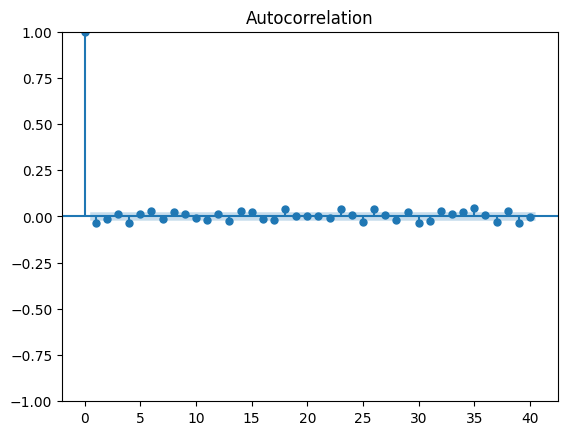

In [61]:
# ACF plot
plt.figure(figsize=(40,14))
tsa_plots.plot_acf(data.Stationary_Price,lags=40)
plt.show()

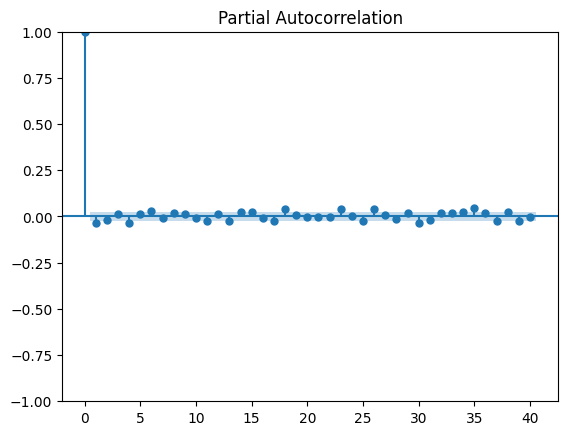

In [62]:
#PACF
tsa_plots.plot_pacf(data.Stationary_Price,lags=40)
plt.show()

### ARIMA

In [63]:
data.head()

Date  Year  Treated_Price  Stationary_Price Day    Apr    Aug    Dec  \
1 1996-01-02  1996          19.81              0.26  02  False  False  False   
2 1996-01-03  1996          19.89              0.08  03  False  False  False   
3 1996-01-04  1996          19.91              0.02  04  False  False  False   
4 1996-01-05  1996          20.26              0.35  05  False  False  False   
5 1996-01-06  1996          20.26              0.00  06  False  False  False   

     Feb   Jan    Jul    Jun    Mar    May    Nov    Oct    Sep  t  t_squared  \
1  False  True  False  False  False  False  False  False  False  0          0   
2  False  True  False  False  False  False  False  False  False  1          1   
3  False  True  False  False  False  False  False  False  False  2          4   
4  False  True  False  False  False  False  False  False  False  3          9   
5  False  True  False  False  False  False  False  False  False  4         16   

   log_Price  
1   2.986187  
2   2.990217  
3   2.991222  
4   3.008648  
5   3.008648

In [64]:
data.columns

Index(['Date', 'Year', 'Treated_Price', 'Stationary_Price', 'Day', 'Apr',
       'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct',
       'Sep', 't', 't_squared', 'log_Price'],
      dtype='object')

In [65]:
data=data.drop(['Year', 'Day', 'Apr',
       'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct',
       'Sep', 't', 't_squared', 'log_Price'],axis=1)


In [66]:
data.head()

Date  Treated_Price  Stationary_Price
1 1996-01-02          19.81              0.26
2 1996-01-03          19.89              0.08
3 1996-01-04          19.91              0.02
4 1996-01-05          20.26              0.35
5 1996-01-06          20.26              0.00

'''From ACF plot we can predict upto 22 month i.e in daywise upto 730 days..so value for order 'q' is 730.However, it is important to note that selecting a large value of q without careful consideration can lead to overfitting and poor model performance.It is generally recommended to consider other factors and diagnostic tools, such as the partial autocorrelation function (PACF), information criteria (e.g., AIC, BIC), and model diagnostics, to determine the optimal order of the MA model.The PACF helps identify the direct relationship between the current observation and the observation at a specific lag, while the AIC and BIC provide measures of model goodness-of-fit and parsimony. '''

In [72]:
# Auto arima

import pmdarima as pm
# Fit the auto ARIMA model
model_auto = pm.auto_arima(train['Stationary_Price'], seasonal=False, trace=True, suppress_warnings=True)

# Print the model summary
print(model_auto.summary())

# Make predictions
n_periods = 10  # Number of periods to forecast
forecast, conf_int = model_auto.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecasted values
print("Forecasted values:")
print(forecast)

# Print the confidence intervals
print("Confidence intervals:")
print(conf_int)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=18363.474, Time=4.55 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=18400.549, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=18397.171, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=18397.004, Time=0.19 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=18396.030, Time=0.75 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=18395.649, Time=0.69 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=18365.222, Time=3.77 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=18365.214, Time=4.41 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=18397.720, Time=0.61 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=18397.058, Time=1.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=18396.383, Time=1.09 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=18367.027, Time=3.39 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=18364.464, Time=6.98 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 27.672 seconds
        

In [73]:
from statsmodels.tsa.arima.model import ARIMA

# Create an ARIMA model and fit it to the data
arima = ARIMA(train['Stationary_Price'], order=(2, 0, 2))
model_fit = arima.fit()

# Use the fitted model to predict the next 1478 steps ahead
forecast = model_fit.forecast(steps=1479)
forecast.head()


5912    0.080301
5913    0.056593
5914   -0.092698
5915    0.087910
5916    0.041037
Name: predicted_mean, dtype: float64

In [74]:
# Reverse the differencing process
forecast_original = train['Treated_Price'].iloc[-1] + forecast.cumsum()

# Display the first 10 forecasted values in the original form
forecast_original

5912    106.640301
5913    106.696893
5914    106.604195
5915    106.692106
5916    106.733143
           ...    
7386    128.363356
7387    128.378098
7388    128.392841
7389    128.407583
7390    128.422325
Name: predicted_mean, Length: 1479, dtype: float64

In [75]:
# Add 'forecast_original' column to 'data'
data['forecast_original'] = forecast_original

In [76]:
y=test['Stationary_Price']
mse = mean_squared_error(y, forecast)
rmse_arima = math.sqrt(mse)
print("RMSE:", rmse_arima)

RMSE: 1.0028045030292758


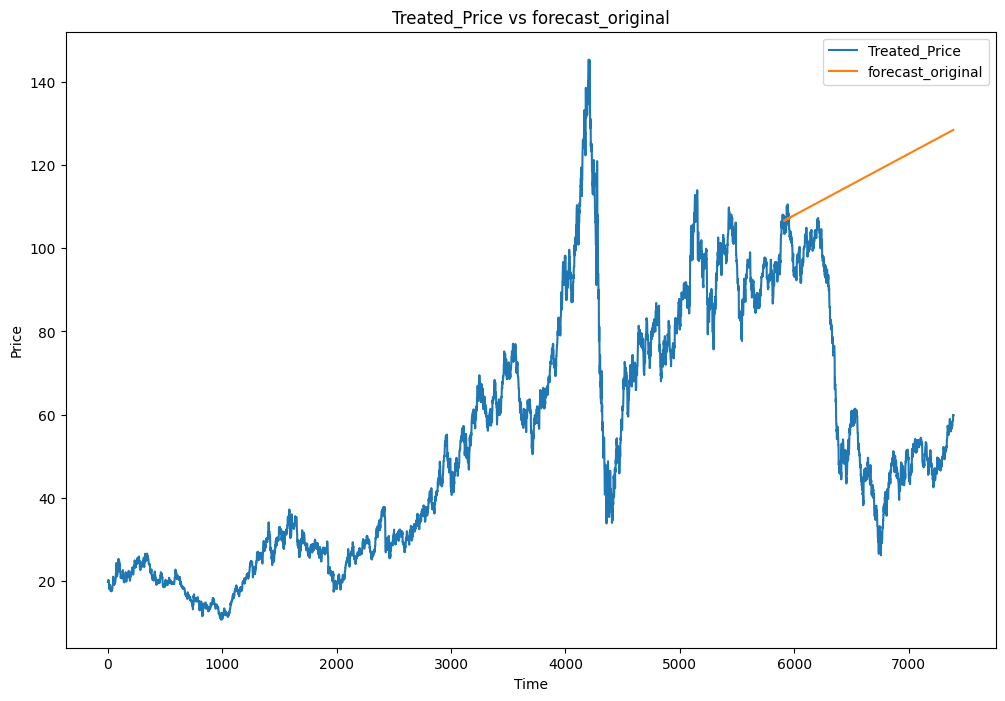

In [77]:
import matplotlib.pyplot as plt

# Assuming you have the 'Treated_Price' and 'forecast_original' columns in your DataFrame or Series

# Plot 'Treated_Price' and 'forecast_original'
plt.figure(figsize=(12, 8))
plt.plot(data['Treated_Price'], label='Treated_Price')
plt.plot(data['forecast_original'], label='forecast_original')
plt.title('Treated_Price vs forecast_original')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


### LSTM
              (Long Short-Term Memory) neural network for time series forecasting.

In [78]:
data

Date  Treated_Price  Stationary_Price  forecast_original
1    1996-01-02          19.81              0.26                NaN
2    1996-01-03          19.89              0.08                NaN
3    1996-01-04          19.91              0.02                NaN
4    1996-01-05          20.26              0.35                NaN
5    1996-01-06          20.26              0.00                NaN
...         ...            ...               ...                ...
7387 2017-12-24          58.47              0.00         128.378098
7388 2017-12-25          58.59              0.12         128.392841
7389 2017-12-26          59.97              1.38         128.407583
7390 2017-12-27          59.64             -0.33         128.422325
7391 2017-12-28          59.84              0.20                NaN

[7391 rows x 4 columns]

In [79]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

# Assuming you have the necessary imports and the data is already preprocessed and split into train_data and test_data

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data['Stationary_Price'].values.reshape(-1, 1))

# Split the data into train and test sets
train_size = int(len(scaled_data) * 0.80)  # 80% for training, 20% for testing
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Define the function to create input and output sequences for LSTM
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Set the sequence length and create sequences for training
sequence_length = 10
X_train, y_train = create_sequences(train_data, sequence_length)

# Create the LSTM model
model1 = Sequential()
model1.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
model1.add(LSTM(units=50, return_sequences=False))
model1.add(Dense(units=1))
model1.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model1.fit(X_train, y_train, epochs=10, batch_size=16)

# Make predictions on the test set
X_test, y_test = create_sequences(test_data, sequence_length)
y_pred = model1.predict(X_test)

# Inverse scale the predictions and the actual values
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
print(y_pred_inv)
print(y_test_inv)


Epoch 1/10
369/369 [==============================] - 12s 12ms/step - loss: 0.0046
Epoch 2/10
369/369 [==============================] - 4s 11ms/step - loss: 0.0015
Epoch 3/10
369/369 [==============================] - 4s 10ms/step - loss: 0.0016
Epoch 4/10
369/369 [==============================] - 4s 11ms/step - loss: 0.0015
Epoch 5/10
369/369 [==============================] - 4s 10ms/step - loss: 0.0016
Epoch 6/10
369/369 [==============================] - 4s 10ms/step - loss: 0.0015
Epoch 7/10
369/369 [==============================] - 4s 11ms/step - loss: 0.0015
Epoch 8/10
369/369 [==============================] - 4s 12ms/step - loss: 0.0015
Epoch 9/10
369/369 [==============================] - 4s 11ms/step - loss: 0.0015
Epoch 10/10
46/46 [==============================] - 2s 5ms/step
[[-0.7337454 ]
 [-0.70995075]
 [-0.696799  ]
 ...
 [-0.7309466 ]
 [-0.7224936 ]
 [-0.71352214]]
[[ 0.13]
 [ 0.  ]
 [ 0.  ]
 ...
 [ 1.38]
 [-0.33]
 [ 0.2 ]]


In [80]:
# Assuming you have the 'train' DataFrame, the last observed value in the original form is stored in 'train['Treated_Price'].iloc[-1]', and the inverse-scaled predictions are stored in 'y_pred_inv'

# Reverse the differencing process
lstm_original = train['Treated_Price'].iloc[-1] + y_pred_inv.cumsum()

# Display the shape of the resulting series
print(lstm_original.shape)


(1469,)


In [81]:
test.shape

(1479, 20)

In [82]:
data.shape

(7391, 4)

In [83]:
# Create a new DataFrame with 'lstm_original' series
lstm_data = pd.DataFrame({'lstm_original': lstm_original})
lstm_data

lstm_original
0        105.826256
1        105.116302
2        104.419502
3        103.731262
4        103.002762
...             ...
1464   -1016.095764
1465   -1016.823181
1466   -1017.554138
1467   -1018.276672
1468   -1018.990173

[1469 rows x 1 columns]

In [84]:
# Set the new index range from 5913 to 7319
new_index = range(5913, 7314)  # Adjust the range to match the length of 'lstm_data'

# Truncate 'lstm_data' to match the length of the new index range
lstm_data = lstm_data[:len(new_index)]

# Change the index of 'lstm_data' DataFrame
lstm_data.index = new_index

# Display the updated DataFrame
print(lstm_data)


      lstm_original
5913     105.826256
5914     105.116302
5915     104.419502
5916     103.731262
5917     103.002762
...             ...
7309    -965.878479
7310    -966.626770
7311    -967.365417
7312    -968.090759
7313    -968.823303

[1401 rows x 1 columns]


In [85]:
da = pd.concat([test.iloc[:1469], lstm_data['lstm_original']], axis=1)
da=da.dropna()
da.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1401 entries, 5913 to 7313
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              1401 non-null   datetime64[ns]
 1   Year              1401 non-null   int32         
 2   Treated_Price     1401 non-null   float64       
 3   Stationary_Price  1401 non-null   float64       
 4   Day               1401 non-null   object        
 5   Apr               1401 non-null   bool          
 6   Aug               1401 non-null   bool          
 7   Dec               1401 non-null   bool          
 8   Feb               1401 non-null   bool          
 9   Jan               1401 non-null   bool          
 10  Jul               1401 non-null   bool          
 11  Jun               1401 non-null   bool          
 12  Mar               1401 non-null   bool          
 13  May               1401 non-null   bool          
 14  Nov               1401 non

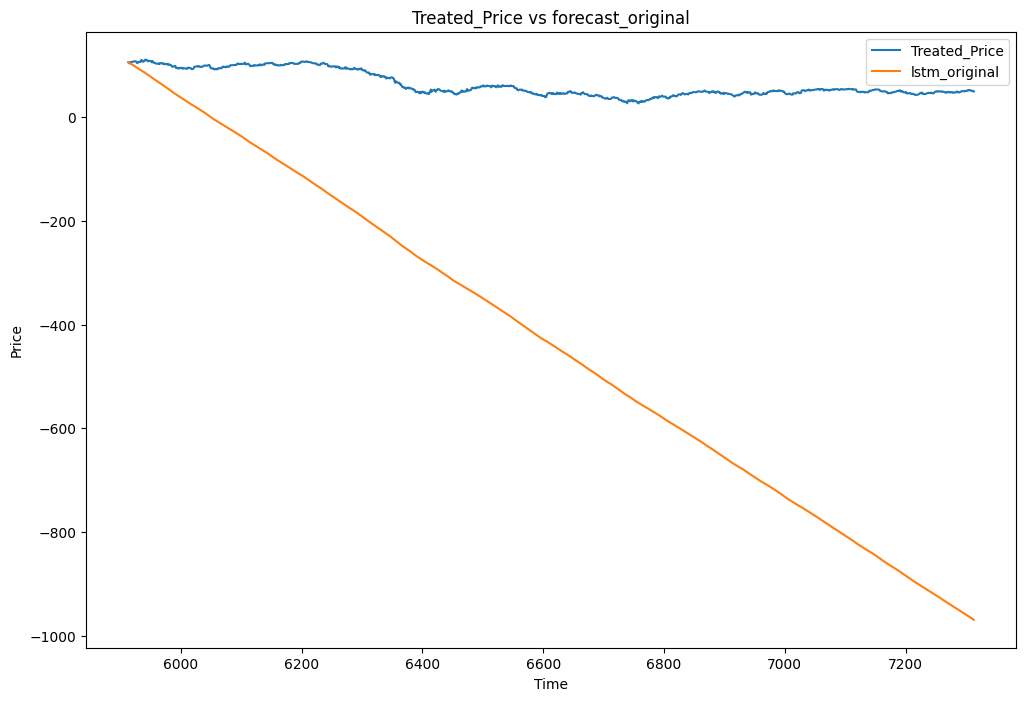

In [86]:
plt.figure(figsize=(12, 8))
plt.plot(da['Treated_Price'], label='Treated_Price')
plt.plot(da['lstm_original'], label='lstm_original')
plt.title('Treated_Price vs forecast_original')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [87]:
#import matplotlib.pyplot as plt

# Plot the predictions and actual values
#plt.figure(figsize=(12, 8))
#plt.plot(y_test_inv, label='Actual Values')
#plt.plot(y_pred_inv, label='Predictions')
#plt.xlabel('Time')
#plt.ylabel('Value')
#plt.title('LSTM Model Predictions vs Actual Values')
#plt.legend()
#plt.show()

In [88]:
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse_lstm = math.sqrt(mse)
print("RMSE:", rmse_lstm)

RMSE: 1.2411878769054463


### RNN
           (Recurrent Neural Network) 

In [89]:
# Normalize the data
scaler1 = MinMaxScaler()
scaled_data1 = scaler1.fit_transform(data['Stationary_Price'].values.reshape(-1, 1))

# Split the data into train and test sets
train_size = int(len(scaled_data1) * 0.80)  # 75% for training, 25% for testing
train_data = scaled_data1[:train_size]
test_data = scaled_data1[train_size:]


# Define the function to create input and output sequences for RNN
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Set the sequence length and create sequences for training
sequence_length = 10
X_train, y_train = create_sequences(train_data, sequence_length)

# Create the RNN model
model = Sequential()
model.add(SimpleRNN(units=50, input_shape=(sequence_length, 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=16)

# Make predictions on the test set
X_test, y_test = create_sequences(test_data, sequence_length)
y_pred1 = model.predict(X_test)

# Inverse scale the predictions and the actual values
y_pred_inv1 = scaler.inverse_transform(y_pred1)
y_test_inv1 = scaler.inverse_transform(y_test)

# Print the predictions and actual values
print("Predictions:", y_pred_inv1)
print("Actual Values:", y_test_inv1)

Epoch 1/10
369/369 [==============================] - 3s 3ms/step - loss: 0.0101
Epoch 2/10
369/369 [==============================] - 1s 4ms/step - loss: 0.0016
Epoch 3/10
369/369 [==============================] - 1s 4ms/step - loss: 0.0015
Epoch 4/10
369/369 [==============================] - 1s 4ms/step - loss: 0.0015
Epoch 5/10
369/369 [==============================] - 1s 4ms/step - loss: 0.0016
Epoch 6/10
369/369 [==============================] - 1s 4ms/step - loss: 0.0015
Epoch 7/10
369/369 [==============================] - 1s 4ms/step - loss: 0.0016
Epoch 8/10
369/369 [==============================] - 2s 5ms/step - loss: 0.0016
Epoch 9/10
369/369 [==============================] - 1s 4ms/step - loss: 0.0016
Epoch 10/10
46/46 [==============================] - 0s 2ms/step
Predictions: [[-0.45146084]
 [-0.39293057]
 [-0.30427387]
 ...
 [-0.43620515]
 [-0.4776163 ]
 [-0.40308702]]
Actual Values: [[ 0.13]
 [ 0.  ]
 [ 0.  ]
 ...
 [ 1.38]
 [-0.33]
 [ 0.2 ]]


In [90]:
# Assuming you have the 'train' DataFrame, the last observed value in the original form is stored in 'train['Treated_Price'].iloc[-1]', and the inverse-scaled predictions are stored in 'y_pred_inv'

# Reverse the differencing process
rnn_original = train['Treated_Price'].iloc[-1] + y_pred_inv1.cumsum()

# Display the shape of the resulting series
print(rnn_original.shape)


(1469,)


In [91]:
# Create a new DataFrame with 'lstm_original' series
rnn_data = pd.DataFrame({'rnn_original': rnn_original})
rnn_data

rnn_original
0       106.108536
1       105.715607
2       105.411331
3       104.961304
4       104.560341
...            ...
1464   -595.636902
1465   -596.056458
1466   -596.492676
1467   -596.970276
1468   -597.373352

[1469 rows x 1 columns]

In [92]:
# Set the new index range from 5913 to 7319
new_index = range(5913, 7314)  # Adjust the range to match the length of 'lstm_data'

# Truncate 'lstm_data' to match the length of the new index range
rnn_data = rnn_data[:len(new_index)]

# Change the index of 'lstm_data' DataFrame
rnn_data.index = new_index

# Display the updated DataFrame
print(rnn_data)


      rnn_original
5913    106.108536
5914    105.715607
5915    105.411331
5916    104.961304
5917    104.560341
...            ...
7309   -565.485779
7310   -565.831787
7311   -566.370117
7312   -566.869812
7313   -567.178650

[1401 rows x 1 columns]


In [93]:
da1 = pd.concat([test.iloc[:1469], rnn_data['rnn_original']], axis=1)
da1=da1.dropna()
da1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1401 entries, 5913 to 7313
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              1401 non-null   datetime64[ns]
 1   Year              1401 non-null   int32         
 2   Treated_Price     1401 non-null   float64       
 3   Stationary_Price  1401 non-null   float64       
 4   Day               1401 non-null   object        
 5   Apr               1401 non-null   bool          
 6   Aug               1401 non-null   bool          
 7   Dec               1401 non-null   bool          
 8   Feb               1401 non-null   bool          
 9   Jan               1401 non-null   bool          
 10  Jul               1401 non-null   bool          
 11  Jun               1401 non-null   bool          
 12  Mar               1401 non-null   bool          
 13  May               1401 non-null   bool          
 14  Nov               1401 non

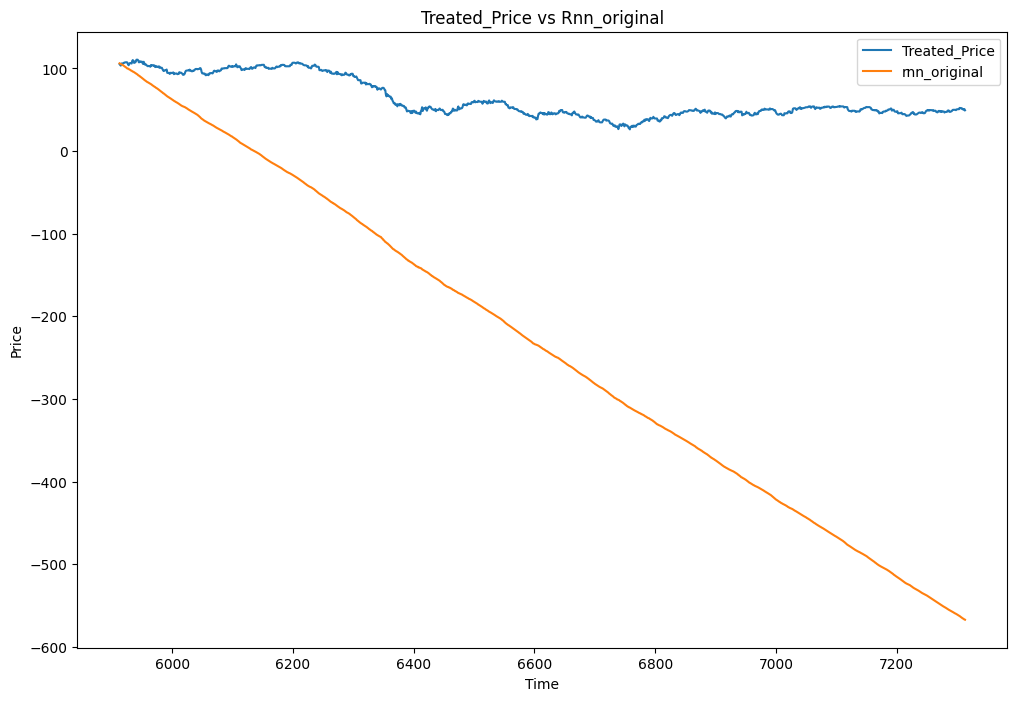

In [94]:
plt.figure(figsize=(12, 8))
plt.plot(da1['Treated_Price'], label='Treated_Price')
plt.plot(da1['rnn_original'], label='rnn_original')
plt.title('Treated_Price vs Rnn_original')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [95]:
#import matplotlib.pyplot as plt

# Plot the predictions and actual values
#plt.figure(figsize=(12, 8))
#plt.plot(y_test_inv1, label='Actual Values')
#plt.plot(y_pred_inv1, label='Predictions')
#plt.xlabel('Time')
#plt.ylabel('Value')
#plt.title('RNN Model Predictions vs Actual Values')
#plt.legend()
#plt.show()


In [96]:
mse = mean_squared_error(y_test_inv1, y_pred_inv1)
rmse_rnn = math.sqrt(mse)
print("RMSE:", rmse_rnn)

RMSE: 1.0963488604127354


### Prophet model

In [97]:
data.shape

(7391, 4)

In [98]:
# Rename the columns to match Prophet's requirements
data = data.rename(columns={'Date': 'ds', 'Stationary_Price': 'y'})
data.head()

ds  Treated_Price     y  forecast_original
1 1996-01-02          19.81  0.26                NaN
2 1996-01-03          19.89  0.08                NaN
3 1996-01-04          19.91  0.02                NaN
4 1996-01-05          20.26  0.35                NaN
5 1996-01-06          20.26  0.00                NaN

In [104]:
train_size = int(len(data) * 0.80)  # 80% for training, 25% for testing
train = data[:train_size]
test = data[train_size:]

In [105]:
from fbprophet import Prophet

ModuleNotFoundError: No module named 'fbprophet'

In [100]:
# Create a new Prophet instance
model_pro = Prophet()

# Fit the model to the data
model_pro.fit(train)

# Define the number of periods to forecast
future_periods = 10

# Generate future dates
future_dates = model_pro.make_future_dataframe(periods=future_periods)

# Perform the forecast
forecast = model_pro.predict(future_dates)

# Extract the actual values from the dataset
actual_values = data['y'].values[-future_periods:]

# Extract the predicted values from the forecast
predicted_values = forecast['yhat'].values[-future_periods:]

# Calculate RMSE
rmse_pro = np.sqrt(mean_squared_error(actual_values, predicted_values))

# Print RMSE
print("RMSE:", rmse_pro)


NameError: name 'Prophet' is not defined

In [ ]:
#Creating Table of rmse's
table= {"MODEL_BASED":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad",
                           "rmse_Mult_sea","Simple_Exp","Hold_method","HWESAA",]),
        "RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,
                                 rmse_Mult_sea,rmse,rmse1,rmse2])}
table_rmse=pd.DataFrame(table)
table_rmse

In [ ]:
#Creating Table of rmse's for DATA_DRIVEN_MODELs
table1= {"DATA_DRIVEN_MODEL":pd.Series(["ARIMA","LSTM","RNN","Prophet"]),
        "RMSE_Values":pd.Series([rmse_arima,
                                 rmse_lstm,rmse_rnn,rmse_pro])}
table_rmse1=pd.DataFrame(table1)
table_rmse1

The RMSE values scores indicate the performance of each model in predicting the test data. Lower RMSE values indicate better predictive accuracy. Based on the values, the models with the lowest RMSE is the Prophet model.

In [ ]:
import pickle
filename = 'Forcasting_Prophet.pkl'
pickle.dump(model_pro, open(filename,'wb'))
model=pickle.load(open('Forcasting_Prophet.pkl','rb'))
